In [1]:
import warnings 
warnings.filterwarnings("ignore")

from monai.transforms import (
    AddChanneld,
    AsChannelFirstd,
    AsChannelLastd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Invertd,
    LoadImaged,
    LabelToMaskd,
    Lambdad,
    RandFlipd,
    RandSpatialCropd,
    RandZoomd,
    RepeatChanneld,
    Resized,
    ScaleIntensityd,
    ScaleIntensityRanged,
    SpatialCrop,
    SpatialCropd,
    SplitChanneld,
    SqueezeDimd,
    ThresholdIntensityd,
    ToTensord,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import DynUNet, UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
import monai.utils as utils

import torch

import matplotlib.pyplot as plt

import os
from glob import glob

import numpy as np

import itk

import site
site.addsitedir('../../ARGUS')
from ARGUSUtils_Transforms import *

In [2]:
img1_dir = "../../Data/VFoldData/ROIData/"

all_images = sorted(glob(os.path.join(img1_dir, '*Class[NS]*.roi.nii.gz')))
all_labels = sorted(glob(os.path.join(img1_dir, '*Class[NS]*.roi.overlay.nii.gz')))

num_classes = 2

num_slices = 48

num_workers_tr = 24
batch_size_tr = 24
num_workers_vl = 24
batch_size_vl = 8

model_filename_base = "BAMC_PTX_2DROI_3DUNet-4Class.best_model.vfold"

num_images = len(all_images)

print(num_images)

num_folds = 15

ns_prefix = ['025ns','026ns','027ns','035ns','048ns','055ns','117ns',
             '135ns','193ns','210ns','215ns','218ns','219ns','221ns','247ns']
s_prefix = ['004s','019s','030s','034s','037s','043s','065s','081s',
            '206s','208s','211s','212s','224s','228s','236s','237s']

fold_prefix_list = []
ns_count = 0
s_count = 0
for i in range(num_folds):
    if i%2 == 0:
        num_ns = 1
        num_s = 1
        if i > num_folds-3:
            num_s = 2
    else:
        num_ns = 1
        num_s = 1
    f = []
    for ns in range(num_ns):
        f.append([ns_prefix[ns_count+ns]])
    ns_count += num_ns
    for s in range(num_s):
        f.append([s_prefix[s_count+s]])
    s_count += num_s
    fold_prefix_list.append(f)
        
train_files = []
val_files = []
test_files = []
for i in range(num_folds):
    tr_folds = []
    for f in range(i,i+num_folds-2):
        tr_folds.append(fold_prefix_list[f%num_folds])
    tr_folds = list(np.concatenate(tr_folds).flat)
    va_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-2) % num_folds]).flat)
    te_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-1) % num_folds]).flat)
    train_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in tr_folds)],
                    [se for se in all_labels if any(pref in se for pref in tr_folds)])
            ]
        )
    val_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in va_folds)],
                    [se for se in all_labels if any(pref in se for pref in va_folds)])
            ]
        )
    test_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in te_folds)],
                    [se for se in all_labels if any(pref in se for pref in te_folds)])
            ]
        )
    print(len(train_files[i]),len(val_files[i]),len(test_files[i]))

108
94 6 8
91 8 9
92 9 7
95 7 6
94 6 8
96 8 4
98 4 6
95 6 7
96 7 5
90 5 13
90 13 5
96 5 7
92 7 9
91 9 8
94 8 6


In [3]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys='image'),
        AsChannelFirstd(keys='label'),
        Lambdad(
            func=lambda x: np.where(x==2,1,0),
            keys=['label']),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=[num_slices,1],
            axis=0,
            reduce_to_statistics=[True,False],
            keys=['image', 'label']),
        ScaleIntensityd(
            channel_wise=True,
            keys=["image"]),
        RandFlipd(prob=0.5, 
            spatial_axis=1,
            keys=['image', 'label']),
        RandZoomd(prob=0.5, 
            min_zoom=1.0,
            max_zoom=1.2,
            keep_size=True,
            mode=['bilinear', 'nearest'],
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys='image'),
        AsChannelFirstd(keys='label'),
        Lambdad(
            func=lambda x: np.where(x==2,1,0),
            keys=['label']),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=[num_slices,1],
            axis=0,
            center_slice=30,
            reduce_to_statistics=[True,False],
            keys=['image', 'label']),
        ScaleIntensityd(
            channel_wise=True,
            keys=["image"]),
        ToTensord(keys=["image", "label"]),
    ]
)

../../Data/VFoldData/ROIData/004s_iimage_73815992352100_clean_ClassS_70-198.roi.nii.gz
../../Data/VFoldData/ROIData/004s_iimage_73815992352100_clean_ClassS_70-198.roi.overlay.nii.gz
(61, 224, 128)
0 2


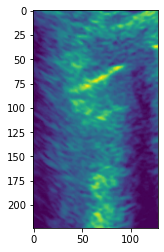

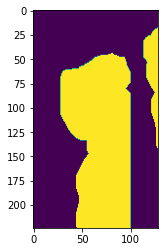

In [5]:
imgnum = 1 #10 for ns, 0 for s

print(train_files[0][imgnum]["image"])
print(train_files[0][imgnum]["label"])

img = itk.imread(train_files[0][imgnum]["image"])
arrimg = itk.GetArrayFromImage(img)
img = itk.imread(train_files[0][imgnum]["label"])
arrlbl = itk.GetArrayFromImage(img)

print(arrimg.shape)
print(arrlbl.min(), arrlbl.max())
roi_size = (arrlbl.shape[0], arrlbl.shape[1])

plt.subplots()
plt.imshow(arrimg[0,:,:])
plt.subplots()
plt.imshow(arrlbl[0,:,:])


In [6]:
train_ds = [CacheDataset(data=train_files[i], transform=train_transforms,cache_rate=1.0, num_workers=None)
            for i in range(num_folds)]
train_loader = [DataLoader(train_ds[i], batch_size=batch_size_tr, shuffle=True, num_workers=num_workers_tr) 
                for i in range(num_folds)]

val_ds = [CacheDataset(data=val_files[i], transform=val_transforms, cache_rate=1.0, num_workers=None)
          for i in range(num_folds)]
val_loader = [DataLoader(val_ds[i], batch_size=batch_size_vl, num_workers=num_workers_vl)
              for i in range(num_folds)]

Loading dataset: 100%|████████████████████████████| 8/8 [00:00<00:00, 53.64it/s]


In [7]:
imgnum = 2
lbl = utils.first(train_loader[0])["label"]
m = lbl[imgnum,0,:,:].max()
print(m)
if m == 1:
    img = utils.first(train_loader[0])["image"]
    plt.subplots()
    plt.imshow(img[imgnum,0,:,:])
    plt.subplots()
    plt.imshow(lbl[imgnum,0,:,:])
print("Data Size =", lbl.shape)
roi_size = lbl.shape[2:]
print("ROI Size =", roi_size)

tensor(0)
Data Size = torch.Size([24, 1, 128, 224])
ROI Size = torch.Size([128, 224])


In [8]:
device = torch.device("cuda:1")

#def get_kernels_strides():
#    sizes, spacings = [224,128], [1, 1]
#    strides, kernels = [], []

#    while True:
#        spacing_ratio = [sp / min(spacings) for sp in spacings]
#        stride = [
#            2 if ratio <= 2 and size >= 8 else 1
#            for (ratio, size) in zip(spacing_ratio, sizes)
#        ]
#        kernel = [3 if ratio <= 2 else 1 for ratio in spacing_ratio]
#        if all(s == 1 for s in stride):
#            break
#        sizes = [i / j for i, j in zip(sizes, stride)]
#        spacings = [i * j for i, j in zip(spacings, stride)]
#        kernels.append(kernel)
#        strides.append(stride)
#    strides.insert(0, len(spacings) * [1])
#    kernels.append(len(spacings) * [3])
#    return kernels, strides

#kernels, strides = get_kernels_strides()

def vfold_train(vfold_num, train_loader, val_loader):
    #model = DynUNet(
    #    spatial_dims=2,
    #    in_channels=2,
    #    out_channels=num_classes,
    #    kernel_size=kernels,
    #    strides=strides,
    #    upsample_kernel_size=strides[1:],
    #    norm_name="instance",
    #    deep_supervision=False,  #True,
    #    #deep_supr_num=deep_supr_num[task_id],
    #)
    model = UNet(
        dimensions=2,
        in_channels=2,
        out_channels=num_classes,
        channels=(32, 64, 128, 32),
        strides=(1, 2, 2),
        num_res_units=2,
        norm=Norm.BATCH,
    ).to(device)
    loss_function = DiceLoss(to_onehot_y=True, softmax=True)
    optimizer = torch.optim.Adam(model.parameters(), 1e-5)
    #optimizer = torch.optim.SGD(
        #model.parameters(),
        #lr=1e-4, #learning_rate,
        #momentum=0.99,
        #weight_decay=3e-5,
        #nesterov=True,
    #)
    dice_metric = DiceMetric(include_background=False, reduction="mean")


    max_epochs = 1000
    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []
    post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, num_classes=num_classes)])
    post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, num_classes=num_classes)])

    root_dir = "."

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"{vfold_num}: epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(
                f"{step}/{len(train_ds) // train_loader.batch_size}, "
                f"train_loss: {loss.item():.4f}")
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"{vfold_num} epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )
                    sw_batch_size = batch_size_vl
                    val_outputs = sliding_window_inference(
                        val_inputs, roi_size, sw_batch_size, model)
                    val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                    val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                    # compute metric for current iteration
                    dice_metric(y_pred=val_outputs, y=val_labels)

                # aggregate the final mean dice result
                metric = dice_metric.aggregate().item()
                # reset the status for next validation round
                dice_metric.reset()

                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(
                        root_dir, model_filename_base+'_'+str(vfold_num)+'.pth'))
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )

    np.save(model_filename_base+"_loss_"+str(vfold_num)+".npy", epoch_loss_values)
    np.save(model_filename_base+"_val_dice_"+str(vfold_num)+".npy", metric_values)

# In[ ]:


for i in range(6,num_folds):
    vfold_train(i, train_loader[i], val_loader[i])


# In[ ]:

----------
6: epoch 1/1000
1/0, train_loss: 0.5916
2/0, train_loss: 0.5664
3/0, train_loss: 0.5643
4/0, train_loss: 0.6062
5/0, train_loss: 0.5757
6 epoch 1 average loss: 0.5808
----------
6: epoch 2/1000
1/0, train_loss: 0.5978
2/0, train_loss: 0.5656
3/0, train_loss: 0.5625
4/0, train_loss: 0.5829
5/0, train_loss: 0.4927
6 epoch 2 average loss: 0.5603
saved new best metric model
current epoch: 2 current mean dice: 0.3815
best mean dice: 0.3815 at epoch: 2
----------
6: epoch 3/1000
1/0, train_loss: 0.6051
2/0, train_loss: 0.5464
3/0, train_loss: 0.5446
4/0, train_loss: 0.5831
5/0, train_loss: 0.5653
6 epoch 3 average loss: 0.5689
----------
6: epoch 4/1000
1/0, train_loss: 0.5888
2/0, train_loss: 0.5801
3/0, train_loss: 0.5568
4/0, train_loss: 0.5432
5/0, train_loss: 0.4667
6 epoch 4 average loss: 0.5471
saved new best metric model
current epoch: 4 current mean dice: 0.4196
best mean dice: 0.4196 at epoch: 4
----------
6: epoch 5/1000
1/0, train_loss: 0.5515
2/0, train_loss: 0.5728
3

saved new best metric model
current epoch: 36 current mean dice: 0.6813
best mean dice: 0.6813 at epoch: 36
----------
6: epoch 37/1000
1/0, train_loss: 0.5153
2/0, train_loss: 0.4949
3/0, train_loss: 0.4818
4/0, train_loss: 0.4837
5/0, train_loss: 0.4856
6 epoch 37 average loss: 0.4923
----------
6: epoch 38/1000
1/0, train_loss: 0.5049
2/0, train_loss: 0.4812
3/0, train_loss: 0.5048
4/0, train_loss: 0.4876
5/0, train_loss: 0.4915
6 epoch 38 average loss: 0.4940
current epoch: 38 current mean dice: 0.6572
best mean dice: 0.6813 at epoch: 36
----------
6: epoch 39/1000
1/0, train_loss: 0.4995
2/0, train_loss: 0.5024
3/0, train_loss: 0.4937
4/0, train_loss: 0.4900
5/0, train_loss: 0.3550
6 epoch 39 average loss: 0.4681
----------
6: epoch 40/1000
1/0, train_loss: 0.4586
2/0, train_loss: 0.4925
3/0, train_loss: 0.5064
4/0, train_loss: 0.5160
5/0, train_loss: 0.5053
6 epoch 40 average loss: 0.4958
current epoch: 40 current mean dice: 0.6239
best mean dice: 0.6813 at epoch: 36
----------
6

1/0, train_loss: 0.4630
2/0, train_loss: 0.5355
3/0, train_loss: 0.4670
4/0, train_loss: 0.4460
5/0, train_loss: 0.6708
6 epoch 74 average loss: 0.5165
current epoch: 74 current mean dice: 0.6241
best mean dice: 0.6813 at epoch: 36
----------
6: epoch 75/1000
1/0, train_loss: 0.5125
2/0, train_loss: 0.4361
3/0, train_loss: 0.4959
4/0, train_loss: 0.4810
5/0, train_loss: 0.5086
6 epoch 75 average loss: 0.4868
----------
6: epoch 76/1000
1/0, train_loss: 0.5062
2/0, train_loss: 0.4780
3/0, train_loss: 0.4977
4/0, train_loss: 0.4550
5/0, train_loss: 0.3947
6 epoch 76 average loss: 0.4663
current epoch: 76 current mean dice: 0.5955
best mean dice: 0.6813 at epoch: 36
----------
6: epoch 77/1000
1/0, train_loss: 0.5074
2/0, train_loss: 0.4661
3/0, train_loss: 0.4848
4/0, train_loss: 0.4713
5/0, train_loss: 0.3425
6 epoch 77 average loss: 0.4544
----------
6: epoch 78/1000
1/0, train_loss: 0.5161
2/0, train_loss: 0.4359
3/0, train_loss: 0.4941
4/0, train_loss: 0.4748
5/0, train_loss: 0.3310


1/0, train_loss: 0.4436
2/0, train_loss: 0.5140
3/0, train_loss: 0.4435
4/0, train_loss: 0.4939
5/0, train_loss: 0.4660
6 epoch 111 average loss: 0.4722
----------
6: epoch 112/1000
1/0, train_loss: 0.4631
2/0, train_loss: 0.4501
3/0, train_loss: 0.4880
4/0, train_loss: 0.4857
5/0, train_loss: 0.4600
6 epoch 112 average loss: 0.4694
current epoch: 112 current mean dice: 0.5664
best mean dice: 0.6813 at epoch: 36
----------
6: epoch 113/1000
1/0, train_loss: 0.4782
2/0, train_loss: 0.4722
3/0, train_loss: 0.5064
4/0, train_loss: 0.4402
5/0, train_loss: 0.3266
6 epoch 113 average loss: 0.4447
----------
6: epoch 114/1000
1/0, train_loss: 0.4240
2/0, train_loss: 0.5169
3/0, train_loss: 0.4545
4/0, train_loss: 0.4812
5/0, train_loss: 0.4364
6 epoch 114 average loss: 0.4626
current epoch: 114 current mean dice: 0.5540
best mean dice: 0.6813 at epoch: 36
----------
6: epoch 115/1000
1/0, train_loss: 0.4504
2/0, train_loss: 0.4553
3/0, train_loss: 0.4802
4/0, train_loss: 0.4792
5/0, train_los

1/0, train_loss: 0.5021
2/0, train_loss: 0.4279
3/0, train_loss: 0.4978
4/0, train_loss: 0.4312
5/0, train_loss: 0.4220
6 epoch 148 average loss: 0.4562
current epoch: 148 current mean dice: 0.6238
best mean dice: 0.7005 at epoch: 122
----------
6: epoch 149/1000
1/0, train_loss: 0.3745
2/0, train_loss: 0.4803
3/0, train_loss: 0.4910
4/0, train_loss: 0.4959
5/0, train_loss: 0.6661
6 epoch 149 average loss: 0.5016
----------
6: epoch 150/1000
1/0, train_loss: 0.5174
2/0, train_loss: 0.4388
3/0, train_loss: 0.4461
4/0, train_loss: 0.4589
5/0, train_loss: 0.4410
6 epoch 150 average loss: 0.4604
saved new best metric model
current epoch: 150 current mean dice: 0.7485
best mean dice: 0.7485 at epoch: 150
----------
6: epoch 151/1000
1/0, train_loss: 0.4468
2/0, train_loss: 0.4188
3/0, train_loss: 0.4515
4/0, train_loss: 0.5060
5/0, train_loss: 0.6696
6 epoch 151 average loss: 0.4985
----------
6: epoch 152/1000
1/0, train_loss: 0.4920
2/0, train_loss: 0.4611
3/0, train_loss: 0.4382
4/0, tra

current epoch: 184 current mean dice: 0.6591
best mean dice: 0.7485 at epoch: 150
----------
6: epoch 185/1000
1/0, train_loss: 0.4371
2/0, train_loss: 0.4591
3/0, train_loss: 0.4481
4/0, train_loss: 0.4585
5/0, train_loss: 0.6665
6 epoch 185 average loss: 0.4939
----------
6: epoch 186/1000
1/0, train_loss: 0.4683
2/0, train_loss: 0.4083
3/0, train_loss: 0.4728
4/0, train_loss: 0.4716
5/0, train_loss: 0.4625
6 epoch 186 average loss: 0.4567
current epoch: 186 current mean dice: 0.6718
best mean dice: 0.7485 at epoch: 150
----------
6: epoch 187/1000
1/0, train_loss: 0.4172
2/0, train_loss: 0.4800
3/0, train_loss: 0.4294
4/0, train_loss: 0.4765
5/0, train_loss: 0.6719
6 epoch 187 average loss: 0.4950
----------
6: epoch 188/1000
1/0, train_loss: 0.4174
2/0, train_loss: 0.4456
3/0, train_loss: 0.4682
4/0, train_loss: 0.4996
5/0, train_loss: 0.4313
6 epoch 188 average loss: 0.4524
current epoch: 188 current mean dice: 0.5999
best mean dice: 0.7485 at epoch: 150
----------
6: epoch 189/10

3/0, train_loss: 0.4260
4/0, train_loss: 0.4887
5/0, train_loss: 0.3143
6 epoch 221 average loss: 0.4291
----------
6: epoch 222/1000
1/0, train_loss: 0.4529
2/0, train_loss: 0.4275
3/0, train_loss: 0.5039
4/0, train_loss: 0.4331
5/0, train_loss: 0.4514
6 epoch 222 average loss: 0.4537
current epoch: 222 current mean dice: 0.6606
best mean dice: 0.7600 at epoch: 200
----------
6: epoch 223/1000
1/0, train_loss: 0.4554
2/0, train_loss: 0.3948
3/0, train_loss: 0.4560
4/0, train_loss: 0.5058
5/0, train_loss: 0.4059
6 epoch 223 average loss: 0.4436
----------
6: epoch 224/1000
1/0, train_loss: 0.4337
2/0, train_loss: 0.4265
3/0, train_loss: 0.4910
4/0, train_loss: 0.4539
5/0, train_loss: 0.4529
6 epoch 224 average loss: 0.4516
current epoch: 224 current mean dice: 0.6549
best mean dice: 0.7600 at epoch: 200
----------
6: epoch 225/1000
1/0, train_loss: 0.4827
2/0, train_loss: 0.4531
3/0, train_loss: 0.4302
4/0, train_loss: 0.4352
5/0, train_loss: 0.4752
6 epoch 225 average loss: 0.4553
---

3/0, train_loss: 0.4039
4/0, train_loss: 0.4855
5/0, train_loss: 0.6626
6 epoch 258 average loss: 0.4847
current epoch: 258 current mean dice: 0.6059
best mean dice: 0.7600 at epoch: 200
----------
6: epoch 259/1000
1/0, train_loss: 0.4052
2/0, train_loss: 0.4459
3/0, train_loss: 0.5283
4/0, train_loss: 0.4187
5/0, train_loss: 0.2850
6 epoch 259 average loss: 0.4166
----------
6: epoch 260/1000
1/0, train_loss: 0.4256
2/0, train_loss: 0.4740
3/0, train_loss: 0.4487
4/0, train_loss: 0.4356
5/0, train_loss: 0.4280
6 epoch 260 average loss: 0.4424
current epoch: 260 current mean dice: 0.7499
best mean dice: 0.7600 at epoch: 200
----------
6: epoch 261/1000
1/0, train_loss: 0.4797
2/0, train_loss: 0.4352
3/0, train_loss: 0.4597
4/0, train_loss: 0.4165
5/0, train_loss: 0.4647
6 epoch 261 average loss: 0.4512
----------
6: epoch 262/1000
1/0, train_loss: 0.5003
2/0, train_loss: 0.4244
3/0, train_loss: 0.4816
4/0, train_loss: 0.3985
5/0, train_loss: 0.2899
6 epoch 262 average loss: 0.4189
cur

1/0, train_loss: 0.4655
2/0, train_loss: 0.4590
3/0, train_loss: 0.4473
4/0, train_loss: 0.4036
5/0, train_loss: 0.2674
6 epoch 295 average loss: 0.4086
----------
6: epoch 296/1000
1/0, train_loss: 0.5046
2/0, train_loss: 0.3847
3/0, train_loss: 0.3991
4/0, train_loss: 0.4475
5/0, train_loss: 0.6626
6 epoch 296 average loss: 0.4797
current epoch: 296 current mean dice: 0.6727
best mean dice: 0.7600 at epoch: 200
----------
6: epoch 297/1000
1/0, train_loss: 0.3878
2/0, train_loss: 0.4435
3/0, train_loss: 0.4926
4/0, train_loss: 0.4285
5/0, train_loss: 0.4571
6 epoch 297 average loss: 0.4419
----------
6: epoch 298/1000
1/0, train_loss: 0.5136
2/0, train_loss: 0.4511
3/0, train_loss: 0.3582
4/0, train_loss: 0.4509
5/0, train_loss: 0.4401
6 epoch 298 average loss: 0.4428
current epoch: 298 current mean dice: 0.6729
best mean dice: 0.7600 at epoch: 200
----------
6: epoch 299/1000
1/0, train_loss: 0.3855
2/0, train_loss: 0.4400
3/0, train_loss: 0.4951
4/0, train_loss: 0.4395
5/0, train_l

1/0, train_loss: 0.3772
2/0, train_loss: 0.4972
3/0, train_loss: 0.4487
4/0, train_loss: 0.4263
5/0, train_loss: 0.4700
6 epoch 332 average loss: 0.4439
current epoch: 332 current mean dice: 0.6073
best mean dice: 0.7600 at epoch: 200
----------
6: epoch 333/1000
1/0, train_loss: 0.3691
2/0, train_loss: 0.4496
3/0, train_loss: 0.4689
4/0, train_loss: 0.4676
5/0, train_loss: 0.4356
6 epoch 333 average loss: 0.4382
----------
6: epoch 334/1000
1/0, train_loss: 0.4241
2/0, train_loss: 0.4696
3/0, train_loss: 0.4212
4/0, train_loss: 0.4133
5/0, train_loss: 0.4754
6 epoch 334 average loss: 0.4407
current epoch: 334 current mean dice: 0.6222
best mean dice: 0.7600 at epoch: 200
----------
6: epoch 335/1000
1/0, train_loss: 0.4174
2/0, train_loss: 0.4516
3/0, train_loss: 0.4177
4/0, train_loss: 0.4640
5/0, train_loss: 0.3306
6 epoch 335 average loss: 0.4163
----------
6: epoch 336/1000
1/0, train_loss: 0.4674
2/0, train_loss: 0.3665
3/0, train_loss: 0.5096
4/0, train_loss: 0.4018
5/0, train_l

6 epoch 368 average loss: 0.4315
current epoch: 368 current mean dice: 0.6939
best mean dice: 0.8029 at epoch: 356
----------
6: epoch 369/1000
1/0, train_loss: 0.4425
2/0, train_loss: 0.4347
3/0, train_loss: 0.3782
4/0, train_loss: 0.4784
5/0, train_loss: 0.4468
6 epoch 369 average loss: 0.4361
----------
6: epoch 370/1000
1/0, train_loss: 0.3678
2/0, train_loss: 0.3801
3/0, train_loss: 0.4691
4/0, train_loss: 0.5175
5/0, train_loss: 0.3889
6 epoch 370 average loss: 0.4247
current epoch: 370 current mean dice: 0.6209
best mean dice: 0.8029 at epoch: 356
----------
6: epoch 371/1000
1/0, train_loss: 0.4021
2/0, train_loss: 0.4405
3/0, train_loss: 0.4016
4/0, train_loss: 0.4593
5/0, train_loss: 0.6563
6 epoch 371 average loss: 0.4719
----------
6: epoch 372/1000
1/0, train_loss: 0.4576
2/0, train_loss: 0.4346
3/0, train_loss: 0.4189
4/0, train_loss: 0.4229
5/0, train_loss: 0.4100
6 epoch 372 average loss: 0.4288
current epoch: 372 current mean dice: 0.6266
best mean dice: 0.8029 at epoc

3/0, train_loss: 0.4298
4/0, train_loss: 0.3922
5/0, train_loss: 0.2669
6 epoch 405 average loss: 0.3985
----------
6: epoch 406/1000
1/0, train_loss: 0.3976
2/0, train_loss: 0.4877
3/0, train_loss: 0.3688
4/0, train_loss: 0.4488
5/0, train_loss: 0.6543
6 epoch 406 average loss: 0.4714
current epoch: 406 current mean dice: 0.6229
best mean dice: 0.8029 at epoch: 356
----------
6: epoch 407/1000
1/0, train_loss: 0.4273
2/0, train_loss: 0.4023
3/0, train_loss: 0.3894
4/0, train_loss: 0.4928
5/0, train_loss: 0.4272
6 epoch 407 average loss: 0.4278
----------
6: epoch 408/1000
1/0, train_loss: 0.4356
2/0, train_loss: 0.4390
3/0, train_loss: 0.4110
4/0, train_loss: 0.4008
5/0, train_loss: 0.5923
6 epoch 408 average loss: 0.4558
current epoch: 408 current mean dice: 0.7237
best mean dice: 0.8029 at epoch: 356
----------
6: epoch 409/1000
1/0, train_loss: 0.4061
2/0, train_loss: 0.4371
3/0, train_loss: 0.4353
4/0, train_loss: 0.4404
5/0, train_loss: 0.2708
6 epoch 409 average loss: 0.3979
---

3/0, train_loss: 0.4167
4/0, train_loss: 0.3831
5/0, train_loss: 0.6568
6 epoch 442 average loss: 0.4624
current epoch: 442 current mean dice: 0.7112
best mean dice: 0.8029 at epoch: 356
----------
6: epoch 443/1000
1/0, train_loss: 0.3905
2/0, train_loss: 0.4276
3/0, train_loss: 0.4257
4/0, train_loss: 0.4542
5/0, train_loss: 0.4447
6 epoch 443 average loss: 0.4285
----------
6: epoch 444/1000
1/0, train_loss: 0.4073
2/0, train_loss: 0.4423
3/0, train_loss: 0.4218
4/0, train_loss: 0.4125
5/0, train_loss: 0.4230
6 epoch 444 average loss: 0.4214
current epoch: 444 current mean dice: 0.6826
best mean dice: 0.8029 at epoch: 356
----------
6: epoch 445/1000
1/0, train_loss: 0.4374
2/0, train_loss: 0.4561
3/0, train_loss: 0.4347
4/0, train_loss: 0.3549
5/0, train_loss: 0.4465
6 epoch 445 average loss: 0.4259
----------
6: epoch 446/1000
1/0, train_loss: 0.4044
2/0, train_loss: 0.4408
3/0, train_loss: 0.4339
4/0, train_loss: 0.4232
5/0, train_loss: 0.3474
6 epoch 446 average loss: 0.4100
cur

1/0, train_loss: 0.4190
2/0, train_loss: 0.4362
3/0, train_loss: 0.3688
4/0, train_loss: 0.4367
5/0, train_loss: 0.6514
6 epoch 479 average loss: 0.4624
----------
6: epoch 480/1000
1/0, train_loss: 0.3830
2/0, train_loss: 0.4596
3/0, train_loss: 0.3674
4/0, train_loss: 0.4721
5/0, train_loss: 0.2707
6 epoch 480 average loss: 0.3906
current epoch: 480 current mean dice: 0.7246
best mean dice: 0.8029 at epoch: 356
----------
6: epoch 481/1000
1/0, train_loss: 0.4645
2/0, train_loss: 0.3587
3/0, train_loss: 0.4010
4/0, train_loss: 0.4428
5/0, train_loss: 0.3020
6 epoch 481 average loss: 0.3938
----------
6: epoch 482/1000
1/0, train_loss: 0.4385
2/0, train_loss: 0.4457
3/0, train_loss: 0.3922
4/0, train_loss: 0.3818
5/0, train_loss: 0.6507
6 epoch 482 average loss: 0.4618
current epoch: 482 current mean dice: 0.7611
best mean dice: 0.8029 at epoch: 356
----------
6: epoch 483/1000
1/0, train_loss: 0.4133
2/0, train_loss: 0.4233
3/0, train_loss: 0.4244
4/0, train_loss: 0.4270
5/0, train_l

1/0, train_loss: 0.3721
2/0, train_loss: 0.4660
3/0, train_loss: 0.3880
4/0, train_loss: 0.4215
5/0, train_loss: 0.6523
6 epoch 516 average loss: 0.4600
current epoch: 516 current mean dice: 0.7094
best mean dice: 0.8029 at epoch: 356
----------
6: epoch 517/1000
1/0, train_loss: 0.4925
2/0, train_loss: 0.3593
3/0, train_loss: 0.4062
4/0, train_loss: 0.3920
5/0, train_loss: 0.5411
6 epoch 517 average loss: 0.4382
----------
6: epoch 518/1000
1/0, train_loss: 0.4801
2/0, train_loss: 0.3761
3/0, train_loss: 0.4430
4/0, train_loss: 0.3840
5/0, train_loss: 0.2576
6 epoch 518 average loss: 0.3882
current epoch: 518 current mean dice: 0.5925
best mean dice: 0.8029 at epoch: 356
----------
6: epoch 519/1000
1/0, train_loss: 0.4060
2/0, train_loss: 0.4325
3/0, train_loss: 0.4355
4/0, train_loss: 0.3730
5/0, train_loss: 0.4985
6 epoch 519 average loss: 0.4291
----------
6: epoch 520/1000
1/0, train_loss: 0.3917
2/0, train_loss: 0.4341
3/0, train_loss: 0.3803
4/0, train_loss: 0.4305
5/0, train_l

1/0, train_loss: 0.4123
2/0, train_loss: 0.4070
3/0, train_loss: 0.4180
4/0, train_loss: 0.3842
5/0, train_loss: 0.6575
6 epoch 553 average loss: 0.4558
----------
6: epoch 554/1000
1/0, train_loss: 0.3863
2/0, train_loss: 0.4393
3/0, train_loss: 0.4314
4/0, train_loss: 0.4014
5/0, train_loss: 0.3963
6 epoch 554 average loss: 0.4109
current epoch: 554 current mean dice: 0.7377
best mean dice: 0.8029 at epoch: 356
----------
6: epoch 555/1000
1/0, train_loss: 0.3704
2/0, train_loss: 0.4215
3/0, train_loss: 0.4909
4/0, train_loss: 0.3576
5/0, train_loss: 0.5545
6 epoch 555 average loss: 0.4390
----------
6: epoch 556/1000
1/0, train_loss: 0.4547
2/0, train_loss: 0.3941
3/0, train_loss: 0.4059
4/0, train_loss: 0.3915
5/0, train_loss: 0.4198
6 epoch 556 average loss: 0.4132
current epoch: 556 current mean dice: 0.7090
best mean dice: 0.8029 at epoch: 356
----------
6: epoch 557/1000
1/0, train_loss: 0.4277
2/0, train_loss: 0.3843
3/0, train_loss: 0.4356
4/0, train_loss: 0.3954
5/0, train_l

1/0, train_loss: 0.3749
2/0, train_loss: 0.4180
3/0, train_loss: 0.4134
4/0, train_loss: 0.4376
5/0, train_loss: 0.2573
6 epoch 590 average loss: 0.3802
current epoch: 590 current mean dice: 0.6156
best mean dice: 0.8297 at epoch: 558
----------
6: epoch 591/1000
1/0, train_loss: 0.3603
2/0, train_loss: 0.5008
3/0, train_loss: 0.3482
4/0, train_loss: 0.4436
5/0, train_loss: 0.4665
6 epoch 591 average loss: 0.4239
----------
6: epoch 592/1000
1/0, train_loss: 0.3959
2/0, train_loss: 0.3966
3/0, train_loss: 0.4127
4/0, train_loss: 0.4253
5/0, train_loss: 0.3901
6 epoch 592 average loss: 0.4041
current epoch: 592 current mean dice: 0.6661
best mean dice: 0.8297 at epoch: 558
----------
6: epoch 593/1000
1/0, train_loss: 0.3455
2/0, train_loss: 0.4259
3/0, train_loss: 0.3854
4/0, train_loss: 0.4630
5/0, train_loss: 0.4658
6 epoch 593 average loss: 0.4171
----------
6: epoch 594/1000
1/0, train_loss: 0.4284
2/0, train_loss: 0.4392
3/0, train_loss: 0.3765
4/0, train_loss: 0.4030
5/0, train_l

1/0, train_loss: 0.4576
2/0, train_loss: 0.4239
3/0, train_loss: 0.4387
4/0, train_loss: 0.3239
5/0, train_loss: 0.2423
6 epoch 627 average loss: 0.3773
----------
6: epoch 628/1000
1/0, train_loss: 0.3798
2/0, train_loss: 0.4477
3/0, train_loss: 0.3804
4/0, train_loss: 0.4341
5/0, train_loss: 0.3202
6 epoch 628 average loss: 0.3924
current epoch: 628 current mean dice: 0.6795
best mean dice: 0.8297 at epoch: 558
----------
6: epoch 629/1000
1/0, train_loss: 0.4796
2/0, train_loss: 0.4083
3/0, train_loss: 0.3812
4/0, train_loss: 0.3618
5/0, train_loss: 0.2349
6 epoch 629 average loss: 0.3732
----------
6: epoch 630/1000
1/0, train_loss: 0.3153
2/0, train_loss: 0.4617
3/0, train_loss: 0.3939
4/0, train_loss: 0.4386
5/0, train_loss: 0.3915
6 epoch 630 average loss: 0.4002
current epoch: 630 current mean dice: 0.6638
best mean dice: 0.8297 at epoch: 558
----------
6: epoch 631/1000
1/0, train_loss: 0.4373
2/0, train_loss: 0.3834
3/0, train_loss: 0.4320
4/0, train_loss: 0.3465
5/0, train_l

1/0, train_loss: 0.4380
2/0, train_loss: 0.3806
3/0, train_loss: 0.3523
4/0, train_loss: 0.4529
5/0, train_loss: 0.2408
6 epoch 664 average loss: 0.3729
current epoch: 664 current mean dice: 0.6349
best mean dice: 0.8297 at epoch: 558
----------
6: epoch 665/1000
1/0, train_loss: 0.4301
2/0, train_loss: 0.4085
3/0, train_loss: 0.3930
4/0, train_loss: 0.3695
5/0, train_loss: 0.3969
6 epoch 665 average loss: 0.3996
----------
6: epoch 666/1000
1/0, train_loss: 0.3927
2/0, train_loss: 0.3659
3/0, train_loss: 0.4394
4/0, train_loss: 0.4100
5/0, train_loss: 0.3972
6 epoch 666 average loss: 0.4010
current epoch: 666 current mean dice: 0.6182
best mean dice: 0.8297 at epoch: 558
----------
6: epoch 667/1000
1/0, train_loss: 0.3561
2/0, train_loss: 0.4065
3/0, train_loss: 0.4171
4/0, train_loss: 0.4084
5/0, train_loss: 0.6475
6 epoch 667 average loss: 0.4471
----------
6: epoch 668/1000
1/0, train_loss: 0.4354
2/0, train_loss: 0.3932
3/0, train_loss: 0.4234
4/0, train_loss: 0.3572
5/0, train_l

1/0, train_loss: 0.3706
2/0, train_loss: 0.4248
3/0, train_loss: 0.4165
4/0, train_loss: 0.3595
5/0, train_loss: 0.6455
6 epoch 701 average loss: 0.4434
----------
6: epoch 702/1000
1/0, train_loss: 0.4037
2/0, train_loss: 0.3991
3/0, train_loss: 0.3853
4/0, train_loss: 0.3800
5/0, train_loss: 0.6418
6 epoch 702 average loss: 0.4420
current epoch: 702 current mean dice: 0.7012
best mean dice: 0.8297 at epoch: 558
----------
6: epoch 703/1000
1/0, train_loss: 0.4078
2/0, train_loss: 0.3874
3/0, train_loss: 0.3450
4/0, train_loss: 0.4320
5/0, train_loss: 0.5651
6 epoch 703 average loss: 0.4275
----------
6: epoch 704/1000
1/0, train_loss: 0.4569
2/0, train_loss: 0.4238
3/0, train_loss: 0.3778
4/0, train_loss: 0.3477
5/0, train_loss: 0.2053
6 epoch 704 average loss: 0.3623
current epoch: 704 current mean dice: 0.7028
best mean dice: 0.8297 at epoch: 558
----------
6: epoch 705/1000
1/0, train_loss: 0.4379
2/0, train_loss: 0.4020
3/0, train_loss: 0.3659
4/0, train_loss: 0.3917
5/0, train_l

1/0, train_loss: 0.4102
2/0, train_loss: 0.3606
3/0, train_loss: 0.4133
4/0, train_loss: 0.3919
5/0, train_loss: 0.3937
6 epoch 738 average loss: 0.3940
current epoch: 738 current mean dice: 0.6891
best mean dice: 0.8297 at epoch: 558
----------
6: epoch 739/1000
1/0, train_loss: 0.4241
2/0, train_loss: 0.3064
3/0, train_loss: 0.4222
4/0, train_loss: 0.4329
5/0, train_loss: 0.3850
6 epoch 739 average loss: 0.3941
----------
6: epoch 740/1000
1/0, train_loss: 0.3774
2/0, train_loss: 0.4356
3/0, train_loss: 0.3907
4/0, train_loss: 0.3607
5/0, train_loss: 0.5261
6 epoch 740 average loss: 0.4181
current epoch: 740 current mean dice: 0.6860
best mean dice: 0.8297 at epoch: 558
----------
6: epoch 741/1000
1/0, train_loss: 0.3693
2/0, train_loss: 0.3831
3/0, train_loss: 0.4382
4/0, train_loss: 0.3998
5/0, train_loss: 0.2103
6 epoch 741 average loss: 0.3601
----------
6: epoch 742/1000
1/0, train_loss: 0.4098
2/0, train_loss: 0.3721
3/0, train_loss: 0.4094
4/0, train_loss: 0.3931
5/0, train_l

1/0, train_loss: 0.4207
2/0, train_loss: 0.3666
3/0, train_loss: 0.3504
4/0, train_loss: 0.4229
5/0, train_loss: 0.6422
6 epoch 775 average loss: 0.4405
----------
6: epoch 776/1000
1/0, train_loss: 0.3750
2/0, train_loss: 0.3493
3/0, train_loss: 0.4396
4/0, train_loss: 0.3878
5/0, train_loss: 0.4030
6 epoch 776 average loss: 0.3909
current epoch: 776 current mean dice: 0.6926
best mean dice: 0.8297 at epoch: 558
----------
6: epoch 777/1000
1/0, train_loss: 0.4641
2/0, train_loss: 0.3733
3/0, train_loss: 0.3679
4/0, train_loss: 0.3734
5/0, train_loss: 0.2091
6 epoch 777 average loss: 0.3575
----------
6: epoch 778/1000
1/0, train_loss: 0.4412
2/0, train_loss: 0.3116
3/0, train_loss: 0.3979
4/0, train_loss: 0.3950
5/0, train_loss: 0.6505
6 epoch 778 average loss: 0.4392
current epoch: 778 current mean dice: 0.6903
best mean dice: 0.8297 at epoch: 558
----------
6: epoch 779/1000
1/0, train_loss: 0.3945
2/0, train_loss: 0.3433
3/0, train_loss: 0.3523
4/0, train_loss: 0.4580
5/0, train_l

1/0, train_loss: 0.3995
2/0, train_loss: 0.3409
3/0, train_loss: 0.3564
4/0, train_loss: 0.4617
5/0, train_loss: 0.4377
6 epoch 812 average loss: 0.3993
current epoch: 812 current mean dice: 0.6814
best mean dice: 0.8297 at epoch: 558
----------
6: epoch 813/1000
1/0, train_loss: 0.4285
2/0, train_loss: 0.3422
3/0, train_loss: 0.4105
4/0, train_loss: 0.3849
5/0, train_loss: 0.2552
6 epoch 813 average loss: 0.3643
----------
6: epoch 814/1000
1/0, train_loss: 0.3477
2/0, train_loss: 0.4144
3/0, train_loss: 0.4321
4/0, train_loss: 0.3781
5/0, train_loss: 0.2225
6 epoch 814 average loss: 0.3590
current epoch: 814 current mean dice: 0.6175
best mean dice: 0.8297 at epoch: 558
----------
6: epoch 815/1000
1/0, train_loss: 0.3728
2/0, train_loss: 0.3907
3/0, train_loss: 0.3574
4/0, train_loss: 0.4261
5/0, train_loss: 0.4782
6 epoch 815 average loss: 0.4051
----------
6: epoch 816/1000
1/0, train_loss: 0.4519
2/0, train_loss: 0.3643
3/0, train_loss: 0.2947
4/0, train_loss: 0.4456
5/0, train_l

1/0, train_loss: 0.3334
2/0, train_loss: 0.4406
3/0, train_loss: 0.3287
4/0, train_loss: 0.4464
5/0, train_loss: 0.3751
6 epoch 849 average loss: 0.3848
----------
6: epoch 850/1000
1/0, train_loss: 0.3941
2/0, train_loss: 0.3630
3/0, train_loss: 0.3457
4/0, train_loss: 0.4055
5/0, train_loss: 0.6395
6 epoch 850 average loss: 0.4296
current epoch: 850 current mean dice: 0.6889
best mean dice: 0.8297 at epoch: 558
----------
6: epoch 851/1000
1/0, train_loss: 0.3408
2/0, train_loss: 0.4293
3/0, train_loss: 0.3679
4/0, train_loss: 0.4046
5/0, train_loss: 0.4861
6 epoch 851 average loss: 0.4057
----------
6: epoch 852/1000
1/0, train_loss: 0.4374
2/0, train_loss: 0.3504
3/0, train_loss: 0.3799
4/0, train_loss: 0.3634
5/0, train_loss: 0.3726
6 epoch 852 average loss: 0.3808
current epoch: 852 current mean dice: 0.6177
best mean dice: 0.8297 at epoch: 558
----------
6: epoch 853/1000
1/0, train_loss: 0.4591
2/0, train_loss: 0.3345
3/0, train_loss: 0.3904
4/0, train_loss: 0.3774
5/0, train_l

1/0, train_loss: 0.4466
2/0, train_loss: 0.3953
3/0, train_loss: 0.3683
4/0, train_loss: 0.3124
5/0, train_loss: 0.3701
6 epoch 886 average loss: 0.3785
current epoch: 886 current mean dice: 0.6977
best mean dice: 0.8297 at epoch: 558
----------
6: epoch 887/1000
1/0, train_loss: 0.3620
2/0, train_loss: 0.3437
3/0, train_loss: 0.4374
4/0, train_loss: 0.3806
5/0, train_loss: 0.3758
6 epoch 887 average loss: 0.3799
----------
6: epoch 888/1000
1/0, train_loss: 0.3943
2/0, train_loss: 0.3559
3/0, train_loss: 0.4023
4/0, train_loss: 0.3683
5/0, train_loss: 0.4319
6 epoch 888 average loss: 0.3905
current epoch: 888 current mean dice: 0.6683
best mean dice: 0.8297 at epoch: 558
----------
6: epoch 889/1000
1/0, train_loss: 0.4192
2/0, train_loss: 0.3308
3/0, train_loss: 0.3713
4/0, train_loss: 0.3694
5/0, train_loss: 0.6378
6 epoch 889 average loss: 0.4257
----------
6: epoch 890/1000
1/0, train_loss: 0.4203
2/0, train_loss: 0.3980
3/0, train_loss: 0.3329
4/0, train_loss: 0.3499
5/0, train_l

1/0, train_loss: 0.3287
2/0, train_loss: 0.4058
3/0, train_loss: 0.3765
4/0, train_loss: 0.4022
5/0, train_loss: 0.4390
6 epoch 923 average loss: 0.3904
----------
6: epoch 924/1000
1/0, train_loss: 0.4125
2/0, train_loss: 0.4504
3/0, train_loss: 0.3669
4/0, train_loss: 0.2962
5/0, train_loss: 0.2259
6 epoch 924 average loss: 0.3504
current epoch: 924 current mean dice: 0.6961
best mean dice: 0.8297 at epoch: 558
----------
6: epoch 925/1000
1/0, train_loss: 0.4176
2/0, train_loss: 0.4256
3/0, train_loss: 0.2939
4/0, train_loss: 0.4168
5/0, train_loss: 0.2007
6 epoch 925 average loss: 0.3509
----------
6: epoch 926/1000
1/0, train_loss: 0.3712
2/0, train_loss: 0.3685
3/0, train_loss: 0.3819
4/0, train_loss: 0.4070
5/0, train_loss: 0.2794
6 epoch 926 average loss: 0.3616
current epoch: 926 current mean dice: 0.7278
best mean dice: 0.8297 at epoch: 558
----------
6: epoch 927/1000
1/0, train_loss: 0.3869
2/0, train_loss: 0.3959
3/0, train_loss: 0.3208
4/0, train_loss: 0.3930
5/0, train_l

1/0, train_loss: 0.3106
2/0, train_loss: 0.4239
3/0, train_loss: 0.4004
4/0, train_loss: 0.3585
5/0, train_loss: 0.3794
6 epoch 960 average loss: 0.3746
current epoch: 960 current mean dice: 0.6798
best mean dice: 0.8297 at epoch: 558
----------
6: epoch 961/1000
1/0, train_loss: 0.3835
2/0, train_loss: 0.3463
3/0, train_loss: 0.3903
4/0, train_loss: 0.3892
5/0, train_loss: 0.4211
6 epoch 961 average loss: 0.3861
----------
6: epoch 962/1000
1/0, train_loss: 0.3753
2/0, train_loss: 0.3013
3/0, train_loss: 0.3881
4/0, train_loss: 0.4639
5/0, train_loss: 0.2450
6 epoch 962 average loss: 0.3547
current epoch: 962 current mean dice: 0.6924
best mean dice: 0.8297 at epoch: 558
----------
6: epoch 963/1000
1/0, train_loss: 0.3514
2/0, train_loss: 0.4644
3/0, train_loss: 0.4403
4/0, train_loss: 0.2714
5/0, train_loss: 0.2091
6 epoch 963 average loss: 0.3473
----------
6: epoch 964/1000
1/0, train_loss: 0.3703
2/0, train_loss: 0.4006
3/0, train_loss: 0.3221
4/0, train_loss: 0.4219
5/0, train_l

1/0, train_loss: 0.4506
2/0, train_loss: 0.3366
3/0, train_loss: 0.3564
4/0, train_loss: 0.3710
5/0, train_loss: 0.1744
6 epoch 997 average loss: 0.3378
----------
6: epoch 998/1000
1/0, train_loss: 0.3259
2/0, train_loss: 0.4100
3/0, train_loss: 0.4250
4/0, train_loss: 0.3306
5/0, train_loss: 0.6334
6 epoch 998 average loss: 0.4250
current epoch: 998 current mean dice: 0.7272
best mean dice: 0.8297 at epoch: 558
----------
6: epoch 999/1000
1/0, train_loss: 0.3403
2/0, train_loss: 0.4065
3/0, train_loss: 0.3770
4/0, train_loss: 0.3798
5/0, train_loss: 0.3877
6 epoch 999 average loss: 0.3783
----------
6: epoch 1000/1000
1/0, train_loss: 0.3692
2/0, train_loss: 0.3962
3/0, train_loss: 0.3996
4/0, train_loss: 0.3416
5/0, train_loss: 0.1705
6 epoch 1000 average loss: 0.3354
current epoch: 1000 current mean dice: 0.6295
best mean dice: 0.8297 at epoch: 558
----------
7: epoch 1/1000
1/0, train_loss: 0.5528
2/0, train_loss: 0.5742
3/0, train_loss: 0.5864
4/0, train_loss: 0.5609
7 epoch 1 a

1/0, train_loss: 0.5637
2/0, train_loss: 0.4811
3/0, train_loss: 0.5387
4/0, train_loss: 0.4959
7 epoch 37 average loss: 0.5198
----------
7: epoch 38/1000
1/0, train_loss: 0.5099
2/0, train_loss: 0.5267
3/0, train_loss: 0.5051
4/0, train_loss: 0.5333
7 epoch 38 average loss: 0.5187
saved new best metric model
current epoch: 38 current mean dice: 0.5679
best mean dice: 0.5679 at epoch: 38
----------
7: epoch 39/1000
1/0, train_loss: 0.5124
2/0, train_loss: 0.5068
3/0, train_loss: 0.5209
4/0, train_loss: 0.5354
7 epoch 39 average loss: 0.5189
----------
7: epoch 40/1000
1/0, train_loss: 0.5391
2/0, train_loss: 0.5075
3/0, train_loss: 0.4991
4/0, train_loss: 0.5221
7 epoch 40 average loss: 0.5169
current epoch: 40 current mean dice: 0.5650
best mean dice: 0.5679 at epoch: 38
----------
7: epoch 41/1000
1/0, train_loss: 0.5169
2/0, train_loss: 0.5151
3/0, train_loss: 0.5241
4/0, train_loss: 0.5096
7 epoch 41 average loss: 0.5164
----------
7: epoch 42/1000
1/0, train_loss: 0.5080
2/0, tra

3/0, train_loss: 0.4584
4/0, train_loss: 0.4962
7 epoch 77 average loss: 0.5035
----------
7: epoch 78/1000
1/0, train_loss: 0.4786
2/0, train_loss: 0.4908
3/0, train_loss: 0.5473
4/0, train_loss: 0.4860
7 epoch 78 average loss: 0.5007
saved new best metric model
current epoch: 78 current mean dice: 0.6149
best mean dice: 0.6149 at epoch: 78
----------
7: epoch 79/1000
1/0, train_loss: 0.4491
2/0, train_loss: 0.5075
3/0, train_loss: 0.5123
4/0, train_loss: 0.5366
7 epoch 79 average loss: 0.5014
----------
7: epoch 80/1000
1/0, train_loss: 0.4942
2/0, train_loss: 0.5567
3/0, train_loss: 0.4728
4/0, train_loss: 0.4779
7 epoch 80 average loss: 0.5004
saved new best metric model
current epoch: 80 current mean dice: 0.6222
best mean dice: 0.6222 at epoch: 80
----------
7: epoch 81/1000
1/0, train_loss: 0.5320
2/0, train_loss: 0.4825
3/0, train_loss: 0.4837
4/0, train_loss: 0.5001
7 epoch 81 average loss: 0.4996
----------
7: epoch 82/1000
1/0, train_loss: 0.5127
2/0, train_loss: 0.4905
3/0,

1/0, train_loss: 0.5062
2/0, train_loss: 0.5053
3/0, train_loss: 0.4684
4/0, train_loss: 0.4818
7 epoch 118 average loss: 0.4904
current epoch: 118 current mean dice: 0.6350
best mean dice: 0.6574 at epoch: 112
----------
7: epoch 119/1000
1/0, train_loss: 0.4989
2/0, train_loss: 0.4671
3/0, train_loss: 0.4963
4/0, train_loss: 0.5134
7 epoch 119 average loss: 0.4939
----------
7: epoch 120/1000
1/0, train_loss: 0.4662
2/0, train_loss: 0.4844
3/0, train_loss: 0.5459
4/0, train_loss: 0.4702
7 epoch 120 average loss: 0.4917
current epoch: 120 current mean dice: 0.6552
best mean dice: 0.6574 at epoch: 112
----------
7: epoch 121/1000
1/0, train_loss: 0.4629
2/0, train_loss: 0.4877
3/0, train_loss: 0.4982
4/0, train_loss: 0.5116
7 epoch 121 average loss: 0.4901
----------
7: epoch 122/1000
1/0, train_loss: 0.4891
2/0, train_loss: 0.5119
3/0, train_loss: 0.4958
4/0, train_loss: 0.4674
7 epoch 122 average loss: 0.4911
saved new best metric model
current epoch: 122 current mean dice: 0.6604
be

1/0, train_loss: 0.4901
2/0, train_loss: 0.4613
3/0, train_loss: 0.4807
4/0, train_loss: 0.5097
7 epoch 159 average loss: 0.4855
----------
7: epoch 160/1000
1/0, train_loss: 0.4841
2/0, train_loss: 0.4577
3/0, train_loss: 0.4848
4/0, train_loss: 0.5025
7 epoch 160 average loss: 0.4823
current epoch: 160 current mean dice: 0.6591
best mean dice: 0.6823 at epoch: 158
----------
7: epoch 161/1000
1/0, train_loss: 0.4614
2/0, train_loss: 0.5237
3/0, train_loss: 0.4419
4/0, train_loss: 0.5004
7 epoch 161 average loss: 0.4819
----------
7: epoch 162/1000
1/0, train_loss: 0.4596
2/0, train_loss: 0.5026
3/0, train_loss: 0.4701
4/0, train_loss: 0.5001
7 epoch 162 average loss: 0.4831
current epoch: 162 current mean dice: 0.6697
best mean dice: 0.6823 at epoch: 158
----------
7: epoch 163/1000
1/0, train_loss: 0.5240
2/0, train_loss: 0.4480
3/0, train_loss: 0.4531
4/0, train_loss: 0.5182
7 epoch 163 average loss: 0.4858
----------
7: epoch 164/1000
1/0, train_loss: 0.5204
2/0, train_loss: 0.473

4/0, train_loss: 0.5109
7 epoch 200 average loss: 0.4756
saved new best metric model
current epoch: 200 current mean dice: 0.6882
best mean dice: 0.6882 at epoch: 200
----------
7: epoch 201/1000
1/0, train_loss: 0.4383
2/0, train_loss: 0.4938
3/0, train_loss: 0.5332
4/0, train_loss: 0.4569
7 epoch 201 average loss: 0.4805
----------
7: epoch 202/1000
1/0, train_loss: 0.4944
2/0, train_loss: 0.4167
3/0, train_loss: 0.4948
4/0, train_loss: 0.5143
7 epoch 202 average loss: 0.4800
current epoch: 202 current mean dice: 0.6795
best mean dice: 0.6882 at epoch: 200
----------
7: epoch 203/1000
1/0, train_loss: 0.4466
2/0, train_loss: 0.4964
3/0, train_loss: 0.4736
4/0, train_loss: 0.4931
7 epoch 203 average loss: 0.4774
----------
7: epoch 204/1000
1/0, train_loss: 0.4488
2/0, train_loss: 0.4903
3/0, train_loss: 0.4808
4/0, train_loss: 0.4892
7 epoch 204 average loss: 0.4773
current epoch: 204 current mean dice: 0.6807
best mean dice: 0.6882 at epoch: 200
----------
7: epoch 205/1000
1/0, tra

1/0, train_loss: 0.4573
2/0, train_loss: 0.4698
3/0, train_loss: 0.4728
4/0, train_loss: 0.4893
7 epoch 241 average loss: 0.4723
----------
7: epoch 242/1000
1/0, train_loss: 0.5112
2/0, train_loss: 0.4705
3/0, train_loss: 0.4485
4/0, train_loss: 0.4444
7 epoch 242 average loss: 0.4687
current epoch: 242 current mean dice: 0.6768
best mean dice: 0.6922 at epoch: 238
----------
7: epoch 243/1000
1/0, train_loss: 0.4708
2/0, train_loss: 0.4626
3/0, train_loss: 0.4796
4/0, train_loss: 0.4652
7 epoch 243 average loss: 0.4696
----------
7: epoch 244/1000
1/0, train_loss: 0.5019
2/0, train_loss: 0.4550
3/0, train_loss: 0.4558
4/0, train_loss: 0.4732
7 epoch 244 average loss: 0.4715
current epoch: 244 current mean dice: 0.6915
best mean dice: 0.6922 at epoch: 238
----------
7: epoch 245/1000
1/0, train_loss: 0.4639
2/0, train_loss: 0.4623
3/0, train_loss: 0.4597
4/0, train_loss: 0.4977
7 epoch 245 average loss: 0.4709
----------
7: epoch 246/1000
1/0, train_loss: 0.5039
2/0, train_loss: 0.459

1/0, train_loss: 0.4740
2/0, train_loss: 0.4276
3/0, train_loss: 0.4881
4/0, train_loss: 0.4709
7 epoch 282 average loss: 0.4651
current epoch: 282 current mean dice: 0.6893
best mean dice: 0.7015 at epoch: 268
----------
7: epoch 283/1000
1/0, train_loss: 0.4639
2/0, train_loss: 0.4778
3/0, train_loss: 0.4750
4/0, train_loss: 0.4389
7 epoch 283 average loss: 0.4639
----------
7: epoch 284/1000
1/0, train_loss: 0.4711
2/0, train_loss: 0.4901
3/0, train_loss: 0.4512
4/0, train_loss: 0.4492
7 epoch 284 average loss: 0.4654
current epoch: 284 current mean dice: 0.6965
best mean dice: 0.7015 at epoch: 268
----------
7: epoch 285/1000
1/0, train_loss: 0.4540
2/0, train_loss: 0.4670
3/0, train_loss: 0.4488
4/0, train_loss: 0.4886
7 epoch 285 average loss: 0.4646
----------
7: epoch 286/1000
1/0, train_loss: 0.4388
2/0, train_loss: 0.4553
3/0, train_loss: 0.4805
4/0, train_loss: 0.4849
7 epoch 286 average loss: 0.4649
current epoch: 286 current mean dice: 0.6910
best mean dice: 0.7015 at epoc

1/0, train_loss: 0.4711
2/0, train_loss: 0.4837
3/0, train_loss: 0.4247
4/0, train_loss: 0.4556
7 epoch 323 average loss: 0.4588
----------
7: epoch 324/1000
1/0, train_loss: 0.4126
2/0, train_loss: 0.5198
3/0, train_loss: 0.4394
4/0, train_loss: 0.4753
7 epoch 324 average loss: 0.4618
current epoch: 324 current mean dice: 0.6995
best mean dice: 0.7025 at epoch: 316
----------
7: epoch 325/1000
1/0, train_loss: 0.4790
2/0, train_loss: 0.4824
3/0, train_loss: 0.4666
4/0, train_loss: 0.4145
7 epoch 325 average loss: 0.4606
----------
7: epoch 326/1000
1/0, train_loss: 0.4546
2/0, train_loss: 0.4479
3/0, train_loss: 0.5140
4/0, train_loss: 0.4239
7 epoch 326 average loss: 0.4601
current epoch: 326 current mean dice: 0.7021
best mean dice: 0.7025 at epoch: 316
----------
7: epoch 327/1000
1/0, train_loss: 0.4601
2/0, train_loss: 0.4426
3/0, train_loss: 0.5261
4/0, train_loss: 0.4062
7 epoch 327 average loss: 0.4588
----------
7: epoch 328/1000
1/0, train_loss: 0.4890
2/0, train_loss: 0.439

4/0, train_loss: 0.4771
7 epoch 364 average loss: 0.4539
current epoch: 364 current mean dice: 0.7004
best mean dice: 0.7041 at epoch: 354
----------
7: epoch 365/1000
1/0, train_loss: 0.4646
2/0, train_loss: 0.4253
3/0, train_loss: 0.4831
4/0, train_loss: 0.4546
7 epoch 365 average loss: 0.4569
----------
7: epoch 366/1000
1/0, train_loss: 0.4553
2/0, train_loss: 0.4745
3/0, train_loss: 0.4014
4/0, train_loss: 0.4939
7 epoch 366 average loss: 0.4563
saved new best metric model
current epoch: 366 current mean dice: 0.7042
best mean dice: 0.7042 at epoch: 366
----------
7: epoch 367/1000
1/0, train_loss: 0.4872
2/0, train_loss: 0.4611
3/0, train_loss: 0.4418
4/0, train_loss: 0.4286
7 epoch 367 average loss: 0.4547
----------
7: epoch 368/1000
1/0, train_loss: 0.4544
2/0, train_loss: 0.4572
3/0, train_loss: 0.4345
4/0, train_loss: 0.4698
7 epoch 368 average loss: 0.4540
current epoch: 368 current mean dice: 0.6955
best mean dice: 0.7042 at epoch: 366
----------
7: epoch 369/1000
1/0, tra

1/0, train_loss: 0.4102
2/0, train_loss: 0.5016
3/0, train_loss: 0.4454
4/0, train_loss: 0.4490
7 epoch 405 average loss: 0.4515
----------
7: epoch 406/1000
1/0, train_loss: 0.4380
2/0, train_loss: 0.4658
3/0, train_loss: 0.4769
4/0, train_loss: 0.4189
7 epoch 406 average loss: 0.4499
current epoch: 406 current mean dice: 0.7028
best mean dice: 0.7055 at epoch: 388
----------
7: epoch 407/1000
1/0, train_loss: 0.4780
2/0, train_loss: 0.4098
3/0, train_loss: 0.4494
4/0, train_loss: 0.4715
7 epoch 407 average loss: 0.4522
----------
7: epoch 408/1000
1/0, train_loss: 0.4329
2/0, train_loss: 0.4557
3/0, train_loss: 0.4151
4/0, train_loss: 0.4922
7 epoch 408 average loss: 0.4490
current epoch: 408 current mean dice: 0.6998
best mean dice: 0.7055 at epoch: 388
----------
7: epoch 409/1000
1/0, train_loss: 0.4569
2/0, train_loss: 0.4266
3/0, train_loss: 0.4605
4/0, train_loss: 0.4541
7 epoch 409 average loss: 0.4495
----------
7: epoch 410/1000
1/0, train_loss: 0.4655
2/0, train_loss: 0.482

3/0, train_loss: 0.4016
4/0, train_loss: 0.4946
7 epoch 446 average loss: 0.4476
current epoch: 446 current mean dice: 0.7005
best mean dice: 0.7109 at epoch: 426
----------
7: epoch 447/1000
1/0, train_loss: 0.3986
2/0, train_loss: 0.4772
3/0, train_loss: 0.3898
4/0, train_loss: 0.5403
7 epoch 447 average loss: 0.4515
----------
7: epoch 448/1000
1/0, train_loss: 0.4137
2/0, train_loss: 0.4501
3/0, train_loss: 0.4127
4/0, train_loss: 0.5145
7 epoch 448 average loss: 0.4478
current epoch: 448 current mean dice: 0.7087
best mean dice: 0.7109 at epoch: 426
----------
7: epoch 449/1000
1/0, train_loss: 0.4475
2/0, train_loss: 0.4609
3/0, train_loss: 0.4414
4/0, train_loss: 0.4241
7 epoch 449 average loss: 0.4434
----------
7: epoch 450/1000
1/0, train_loss: 0.4162
2/0, train_loss: 0.4282
3/0, train_loss: 0.4527
4/0, train_loss: 0.4915
7 epoch 450 average loss: 0.4472
current epoch: 450 current mean dice: 0.7058
best mean dice: 0.7109 at epoch: 426
----------
7: epoch 451/1000
1/0, train_l

4/0, train_loss: 0.4778
7 epoch 487 average loss: 0.4412
----------
7: epoch 488/1000
1/0, train_loss: 0.4344
2/0, train_loss: 0.4446
3/0, train_loss: 0.4208
4/0, train_loss: 0.4590
7 epoch 488 average loss: 0.4397
current epoch: 488 current mean dice: 0.7032
best mean dice: 0.7113 at epoch: 480
----------
7: epoch 489/1000
1/0, train_loss: 0.4184
2/0, train_loss: 0.4049
3/0, train_loss: 0.4856
4/0, train_loss: 0.4474
7 epoch 489 average loss: 0.4391
----------
7: epoch 490/1000
1/0, train_loss: 0.4135
2/0, train_loss: 0.4954
3/0, train_loss: 0.4354
4/0, train_loss: 0.4247
7 epoch 490 average loss: 0.4423
current epoch: 490 current mean dice: 0.7072
best mean dice: 0.7113 at epoch: 480
----------
7: epoch 491/1000
1/0, train_loss: 0.4853
2/0, train_loss: 0.3945
3/0, train_loss: 0.4183
4/0, train_loss: 0.4686
7 epoch 491 average loss: 0.4417
----------
7: epoch 492/1000
1/0, train_loss: 0.4191
2/0, train_loss: 0.4243
3/0, train_loss: 0.4842
4/0, train_loss: 0.4297
7 epoch 492 average lo

7 epoch 528 average loss: 0.4384
current epoch: 528 current mean dice: 0.7020
best mean dice: 0.7142 at epoch: 512
----------
7: epoch 529/1000
1/0, train_loss: 0.4378
2/0, train_loss: 0.4211
3/0, train_loss: 0.4376
4/0, train_loss: 0.4435
7 epoch 529 average loss: 0.4350
----------
7: epoch 530/1000
1/0, train_loss: 0.4556
2/0, train_loss: 0.4041
3/0, train_loss: 0.4438
4/0, train_loss: 0.4493
7 epoch 530 average loss: 0.4382
current epoch: 530 current mean dice: 0.7077
best mean dice: 0.7142 at epoch: 512
----------
7: epoch 531/1000
1/0, train_loss: 0.4750
2/0, train_loss: 0.3870
3/0, train_loss: 0.4373
4/0, train_loss: 0.4543
7 epoch 531 average loss: 0.4384
----------
7: epoch 532/1000
1/0, train_loss: 0.4352
2/0, train_loss: 0.3874
3/0, train_loss: 0.4322
4/0, train_loss: 0.4999
7 epoch 532 average loss: 0.4387
current epoch: 532 current mean dice: 0.7116
best mean dice: 0.7142 at epoch: 512
----------
7: epoch 533/1000
1/0, train_loss: 0.4604
2/0, train_loss: 0.4397
3/0, train_l

7 epoch 569 average loss: 0.4328
----------
7: epoch 570/1000
1/0, train_loss: 0.3949
2/0, train_loss: 0.4379
3/0, train_loss: 0.4524
4/0, train_loss: 0.4363
7 epoch 570 average loss: 0.4304
current epoch: 570 current mean dice: 0.7069
best mean dice: 0.7142 at epoch: 512
----------
7: epoch 571/1000
1/0, train_loss: 0.4559
2/0, train_loss: 0.4701
3/0, train_loss: 0.4021
4/0, train_loss: 0.3937
7 epoch 571 average loss: 0.4304
----------
7: epoch 572/1000
1/0, train_loss: 0.4806
2/0, train_loss: 0.4005
3/0, train_loss: 0.4499
4/0, train_loss: 0.3965
7 epoch 572 average loss: 0.4319
current epoch: 572 current mean dice: 0.7076
best mean dice: 0.7142 at epoch: 512
----------
7: epoch 573/1000
1/0, train_loss: 0.3958
2/0, train_loss: 0.4104
3/0, train_loss: 0.4491
4/0, train_loss: 0.4737
7 epoch 573 average loss: 0.4322
----------
7: epoch 574/1000
1/0, train_loss: 0.4297
2/0, train_loss: 0.4099
3/0, train_loss: 0.4679
4/0, train_loss: 0.4092
7 epoch 574 average loss: 0.4292
current epoch

1/0, train_loss: 0.3507
2/0, train_loss: 0.4661
3/0, train_loss: 0.4450
4/0, train_loss: 0.4611
7 epoch 611 average loss: 0.4307
----------
7: epoch 612/1000
1/0, train_loss: 0.3742
2/0, train_loss: 0.5026
3/0, train_loss: 0.4487
4/0, train_loss: 0.3947
7 epoch 612 average loss: 0.4301
current epoch: 612 current mean dice: 0.7013
best mean dice: 0.7142 at epoch: 512
----------
7: epoch 613/1000
1/0, train_loss: 0.3766
2/0, train_loss: 0.4569
3/0, train_loss: 0.4588
4/0, train_loss: 0.4181
7 epoch 613 average loss: 0.4276
----------
7: epoch 614/1000
1/0, train_loss: 0.5011
2/0, train_loss: 0.3643
3/0, train_loss: 0.4546
4/0, train_loss: 0.4051
7 epoch 614 average loss: 0.4313
current epoch: 614 current mean dice: 0.7107
best mean dice: 0.7142 at epoch: 512
----------
7: epoch 615/1000
1/0, train_loss: 0.4223
2/0, train_loss: 0.4243
3/0, train_loss: 0.4230
4/0, train_loss: 0.4394
7 epoch 615 average loss: 0.4273
----------
7: epoch 616/1000
1/0, train_loss: 0.4016
2/0, train_loss: 0.418

7 epoch 652 average loss: 0.4227
current epoch: 652 current mean dice: 0.7073
best mean dice: 0.7158 at epoch: 646
----------
7: epoch 653/1000
1/0, train_loss: 0.4408
2/0, train_loss: 0.4129
3/0, train_loss: 0.4580
4/0, train_loss: 0.3915
7 epoch 653 average loss: 0.4258
----------
7: epoch 654/1000
1/0, train_loss: 0.4063
2/0, train_loss: 0.3794
3/0, train_loss: 0.4373
4/0, train_loss: 0.4729
7 epoch 654 average loss: 0.4240
current epoch: 654 current mean dice: 0.7134
best mean dice: 0.7158 at epoch: 646
----------
7: epoch 655/1000
1/0, train_loss: 0.4393
2/0, train_loss: 0.4105
3/0, train_loss: 0.4236
4/0, train_loss: 0.4232
7 epoch 655 average loss: 0.4241
----------
7: epoch 656/1000
1/0, train_loss: 0.3972
2/0, train_loss: 0.4062
3/0, train_loss: 0.4663
4/0, train_loss: 0.4195
7 epoch 656 average loss: 0.4223
current epoch: 656 current mean dice: 0.7101
best mean dice: 0.7158 at epoch: 646
----------
7: epoch 657/1000
1/0, train_loss: 0.4383
2/0, train_loss: 0.4444
3/0, train_l

7 epoch 693 average loss: 0.4189
----------
7: epoch 694/1000
1/0, train_loss: 0.4178
2/0, train_loss: 0.4262
3/0, train_loss: 0.4161
4/0, train_loss: 0.4139
7 epoch 694 average loss: 0.4185
current epoch: 694 current mean dice: 0.7118
best mean dice: 0.7158 at epoch: 646
----------
7: epoch 695/1000
1/0, train_loss: 0.3726
2/0, train_loss: 0.4195
3/0, train_loss: 0.4308
4/0, train_loss: 0.4553
7 epoch 695 average loss: 0.4196
----------
7: epoch 696/1000
1/0, train_loss: 0.4053
2/0, train_loss: 0.4157
3/0, train_loss: 0.4441
4/0, train_loss: 0.3997
7 epoch 696 average loss: 0.4162
current epoch: 696 current mean dice: 0.7019
best mean dice: 0.7158 at epoch: 646
----------
7: epoch 697/1000
1/0, train_loss: 0.4643
2/0, train_loss: 0.4279
3/0, train_loss: 0.4339
4/0, train_loss: 0.3422
7 epoch 697 average loss: 0.4171
----------
7: epoch 698/1000
1/0, train_loss: 0.3817
2/0, train_loss: 0.4473
3/0, train_loss: 0.4146
4/0, train_loss: 0.4282
7 epoch 698 average loss: 0.4180
saved new bes

1/0, train_loss: 0.4280
2/0, train_loss: 0.3632
3/0, train_loss: 0.4125
4/0, train_loss: 0.4601
7 epoch 735 average loss: 0.4160
----------
7: epoch 736/1000
1/0, train_loss: 0.3778
2/0, train_loss: 0.4188
3/0, train_loss: 0.4761
4/0, train_loss: 0.3984
7 epoch 736 average loss: 0.4178
current epoch: 736 current mean dice: 0.7098
best mean dice: 0.7163 at epoch: 698
----------
7: epoch 737/1000
1/0, train_loss: 0.4248
2/0, train_loss: 0.3657
3/0, train_loss: 0.4512
4/0, train_loss: 0.4092
7 epoch 737 average loss: 0.4127
----------
7: epoch 738/1000
1/0, train_loss: 0.4046
2/0, train_loss: 0.4980
3/0, train_loss: 0.3463
4/0, train_loss: 0.4157
7 epoch 738 average loss: 0.4161
current epoch: 738 current mean dice: 0.7127
best mean dice: 0.7163 at epoch: 698
----------
7: epoch 739/1000
1/0, train_loss: 0.4461
2/0, train_loss: 0.4021
3/0, train_loss: 0.3750
4/0, train_loss: 0.4389
7 epoch 739 average loss: 0.4155
----------
7: epoch 740/1000
1/0, train_loss: 0.3736
2/0, train_loss: 0.459

7 epoch 776 average loss: 0.4135
current epoch: 776 current mean dice: 0.7117
best mean dice: 0.7163 at epoch: 698
----------
7: epoch 777/1000
1/0, train_loss: 0.4099
2/0, train_loss: 0.4274
3/0, train_loss: 0.4031
4/0, train_loss: 0.4096
7 epoch 777 average loss: 0.4125
----------
7: epoch 778/1000
1/0, train_loss: 0.3809
2/0, train_loss: 0.3423
3/0, train_loss: 0.4555
4/0, train_loss: 0.4697
7 epoch 778 average loss: 0.4121
current epoch: 778 current mean dice: 0.7141
best mean dice: 0.7163 at epoch: 698
----------
7: epoch 779/1000
1/0, train_loss: 0.3821
2/0, train_loss: 0.4256
3/0, train_loss: 0.4218
4/0, train_loss: 0.4119
7 epoch 779 average loss: 0.4103
----------
7: epoch 780/1000
1/0, train_loss: 0.4116
2/0, train_loss: 0.4180
3/0, train_loss: 0.4370
4/0, train_loss: 0.3732
7 epoch 780 average loss: 0.4100
current epoch: 780 current mean dice: 0.7134
best mean dice: 0.7163 at epoch: 698
----------
7: epoch 781/1000
1/0, train_loss: 0.3814
2/0, train_loss: 0.4854
3/0, train_l

7 epoch 817 average loss: 0.4084
----------
7: epoch 818/1000
1/0, train_loss: 0.4303
2/0, train_loss: 0.4021
3/0, train_loss: 0.4458
4/0, train_loss: 0.3527
7 epoch 818 average loss: 0.4077
current epoch: 818 current mean dice: 0.7091
best mean dice: 0.7173 at epoch: 800
----------
7: epoch 819/1000
1/0, train_loss: 0.4172
2/0, train_loss: 0.3472
3/0, train_loss: 0.4439
4/0, train_loss: 0.4298
7 epoch 819 average loss: 0.4095
----------
7: epoch 820/1000
1/0, train_loss: 0.4312
2/0, train_loss: 0.4248
3/0, train_loss: 0.4211
4/0, train_loss: 0.3576
7 epoch 820 average loss: 0.4087
current epoch: 820 current mean dice: 0.7124
best mean dice: 0.7173 at epoch: 800
----------
7: epoch 821/1000
1/0, train_loss: 0.4443
2/0, train_loss: 0.4047
3/0, train_loss: 0.3837
4/0, train_loss: 0.4006
7 epoch 821 average loss: 0.4083
----------
7: epoch 822/1000
1/0, train_loss: 0.3344
2/0, train_loss: 0.4030
3/0, train_loss: 0.4587
4/0, train_loss: 0.4451
7 epoch 822 average loss: 0.4103
current epoch

1/0, train_loss: 0.4347
2/0, train_loss: 0.4051
3/0, train_loss: 0.3912
4/0, train_loss: 0.3871
7 epoch 859 average loss: 0.4045
----------
7: epoch 860/1000
1/0, train_loss: 0.4086
2/0, train_loss: 0.3732
3/0, train_loss: 0.4195
4/0, train_loss: 0.4134
7 epoch 860 average loss: 0.4037
current epoch: 860 current mean dice: 0.7144
best mean dice: 0.7173 at epoch: 800
----------
7: epoch 861/1000
1/0, train_loss: 0.4000
2/0, train_loss: 0.3823
3/0, train_loss: 0.3827
4/0, train_loss: 0.4404
7 epoch 861 average loss: 0.4014
----------
7: epoch 862/1000
1/0, train_loss: 0.4446
2/0, train_loss: 0.3801
3/0, train_loss: 0.3759
4/0, train_loss: 0.4104
7 epoch 862 average loss: 0.4027
current epoch: 862 current mean dice: 0.7133
best mean dice: 0.7173 at epoch: 800
----------
7: epoch 863/1000
1/0, train_loss: 0.4068
2/0, train_loss: 0.4538
3/0, train_loss: 0.3170
4/0, train_loss: 0.4362
7 epoch 863 average loss: 0.4034
----------
7: epoch 864/1000
1/0, train_loss: 0.4470
2/0, train_loss: 0.416

3/0, train_loss: 0.4494
4/0, train_loss: 0.3636
7 epoch 900 average loss: 0.4011
current epoch: 900 current mean dice: 0.7164
best mean dice: 0.7209 at epoch: 898
----------
7: epoch 901/1000
1/0, train_loss: 0.4046
2/0, train_loss: 0.4185
3/0, train_loss: 0.3841
4/0, train_loss: 0.3852
7 epoch 901 average loss: 0.3981
----------
7: epoch 902/1000
1/0, train_loss: 0.3741
2/0, train_loss: 0.3833
3/0, train_loss: 0.3889
4/0, train_loss: 0.4650
7 epoch 902 average loss: 0.4028
current epoch: 902 current mean dice: 0.7134
best mean dice: 0.7209 at epoch: 898
----------
7: epoch 903/1000
1/0, train_loss: 0.3837
2/0, train_loss: 0.4317
3/0, train_loss: 0.3870
4/0, train_loss: 0.3899
7 epoch 903 average loss: 0.3981
----------
7: epoch 904/1000
1/0, train_loss: 0.4224
2/0, train_loss: 0.3928
3/0, train_loss: 0.4055
4/0, train_loss: 0.3836
7 epoch 904 average loss: 0.4011
current epoch: 904 current mean dice: 0.7149
best mean dice: 0.7209 at epoch: 898
----------
7: epoch 905/1000
1/0, train_l

3/0, train_loss: 0.3942
4/0, train_loss: 0.3860
7 epoch 941 average loss: 0.3975
----------
7: epoch 942/1000
1/0, train_loss: 0.4083
2/0, train_loss: 0.3506
3/0, train_loss: 0.3650
4/0, train_loss: 0.4853
7 epoch 942 average loss: 0.4023
current epoch: 942 current mean dice: 0.7100
best mean dice: 0.7209 at epoch: 898
----------
7: epoch 943/1000
1/0, train_loss: 0.3599
2/0, train_loss: 0.4571
3/0, train_loss: 0.3955
4/0, train_loss: 0.3770
7 epoch 943 average loss: 0.3974
----------
7: epoch 944/1000
1/0, train_loss: 0.3557
2/0, train_loss: 0.4571
3/0, train_loss: 0.3685
4/0, train_loss: 0.4104
7 epoch 944 average loss: 0.3979
current epoch: 944 current mean dice: 0.7110
best mean dice: 0.7209 at epoch: 898
----------
7: epoch 945/1000
1/0, train_loss: 0.3860
2/0, train_loss: 0.3858
3/0, train_loss: 0.3894
4/0, train_loss: 0.4266
7 epoch 945 average loss: 0.3969
----------
7: epoch 946/1000
1/0, train_loss: 0.4192
2/0, train_loss: 0.3607
3/0, train_loss: 0.3987
4/0, train_loss: 0.408

current epoch: 982 current mean dice: 0.7158
best mean dice: 0.7209 at epoch: 898
----------
7: epoch 983/1000
1/0, train_loss: 0.3976
2/0, train_loss: 0.3852
3/0, train_loss: 0.3664
4/0, train_loss: 0.4210
7 epoch 983 average loss: 0.3926
----------
7: epoch 984/1000
1/0, train_loss: 0.3552
2/0, train_loss: 0.3619
3/0, train_loss: 0.4453
4/0, train_loss: 0.4111
7 epoch 984 average loss: 0.3934
current epoch: 984 current mean dice: 0.7118
best mean dice: 0.7209 at epoch: 898
----------
7: epoch 985/1000
1/0, train_loss: 0.3742
2/0, train_loss: 0.4373
3/0, train_loss: 0.3611
4/0, train_loss: 0.4046
7 epoch 985 average loss: 0.3943
----------
7: epoch 986/1000
1/0, train_loss: 0.3794
2/0, train_loss: 0.4596
3/0, train_loss: 0.3505
4/0, train_loss: 0.3798
7 epoch 986 average loss: 0.3923
current epoch: 986 current mean dice: 0.7133
best mean dice: 0.7209 at epoch: 898
----------
7: epoch 987/1000
1/0, train_loss: 0.3931
2/0, train_loss: 0.3543
3/0, train_loss: 0.3878
4/0, train_loss: 0.43

1/0, train_loss: 0.4973
2/0, train_loss: 0.4886
3/0, train_loss: 0.4908
4/0, train_loss: 0.4850
8 epoch 23 average loss: 0.4904
----------
8: epoch 24/1000
1/0, train_loss: 0.5317
2/0, train_loss: 0.4858
3/0, train_loss: 0.4698
4/0, train_loss: 0.4633
8 epoch 24 average loss: 0.4877
saved new best metric model
current epoch: 24 current mean dice: 0.7291
best mean dice: 0.7291 at epoch: 24
----------
8: epoch 25/1000
1/0, train_loss: 0.5057
2/0, train_loss: 0.4500
3/0, train_loss: 0.5207
4/0, train_loss: 0.4696
8 epoch 25 average loss: 0.4865
----------
8: epoch 26/1000
1/0, train_loss: 0.5273
2/0, train_loss: 0.4570
3/0, train_loss: 0.4564
4/0, train_loss: 0.4927
8 epoch 26 average loss: 0.4833
saved new best metric model
current epoch: 26 current mean dice: 0.7419
best mean dice: 0.7419 at epoch: 26
----------
8: epoch 27/1000
1/0, train_loss: 0.4538
2/0, train_loss: 0.4945
3/0, train_loss: 0.4821
4/0, train_loss: 0.5013
8 epoch 27 average loss: 0.4830
----------
8: epoch 28/1000
1/0,

8 epoch 62 average loss: 0.4474
saved new best metric model
current epoch: 62 current mean dice: 0.8615
best mean dice: 0.8615 at epoch: 62
----------
8: epoch 63/1000
1/0, train_loss: 0.4178
2/0, train_loss: 0.5033
3/0, train_loss: 0.4544
4/0, train_loss: 0.4144
8 epoch 63 average loss: 0.4475
----------
8: epoch 64/1000
1/0, train_loss: 0.4154
2/0, train_loss: 0.4988
3/0, train_loss: 0.4745
4/0, train_loss: 0.3903
8 epoch 64 average loss: 0.4448
saved new best metric model
current epoch: 64 current mean dice: 0.8655
best mean dice: 0.8655 at epoch: 64
----------
8: epoch 65/1000
1/0, train_loss: 0.4347
2/0, train_loss: 0.4905
3/0, train_loss: 0.3882
4/0, train_loss: 0.4627
8 epoch 65 average loss: 0.4440
----------
8: epoch 66/1000
1/0, train_loss: 0.4883
2/0, train_loss: 0.4217
3/0, train_loss: 0.4333
4/0, train_loss: 0.4405
8 epoch 66 average loss: 0.4459
saved new best metric model
current epoch: 66 current mean dice: 0.8679
best mean dice: 0.8679 at epoch: 66
----------
8: epoch 

1/0, train_loss: 0.4186
2/0, train_loss: 0.3984
3/0, train_loss: 0.4685
4/0, train_loss: 0.4358
8 epoch 102 average loss: 0.4303
saved new best metric model
current epoch: 102 current mean dice: 0.9011
best mean dice: 0.9011 at epoch: 102
----------
8: epoch 103/1000
1/0, train_loss: 0.3923
2/0, train_loss: 0.4835
3/0, train_loss: 0.3880
4/0, train_loss: 0.4498
8 epoch 103 average loss: 0.4284
----------
8: epoch 104/1000
1/0, train_loss: 0.4367
2/0, train_loss: 0.4614
3/0, train_loss: 0.3823
4/0, train_loss: 0.4405
8 epoch 104 average loss: 0.4302
current epoch: 104 current mean dice: 0.8979
best mean dice: 0.9011 at epoch: 102
----------
8: epoch 105/1000
1/0, train_loss: 0.4391
2/0, train_loss: 0.4403
3/0, train_loss: 0.3617
4/0, train_loss: 0.4810
8 epoch 105 average loss: 0.4305
----------
8: epoch 106/1000
1/0, train_loss: 0.4604
2/0, train_loss: 0.4511
3/0, train_loss: 0.4088
4/0, train_loss: 0.3910
8 epoch 106 average loss: 0.4278
current epoch: 106 current mean dice: 0.8988
be

4/0, train_loss: 0.4123
8 epoch 142 average loss: 0.4193
current epoch: 142 current mean dice: 0.9061
best mean dice: 0.9071 at epoch: 140
----------
8: epoch 143/1000
1/0, train_loss: 0.4300
2/0, train_loss: 0.4354
3/0, train_loss: 0.3966
4/0, train_loss: 0.4096
8 epoch 143 average loss: 0.4179
----------
8: epoch 144/1000
1/0, train_loss: 0.4525
2/0, train_loss: 0.4454
3/0, train_loss: 0.3909
4/0, train_loss: 0.3825
8 epoch 144 average loss: 0.4178
saved new best metric model
current epoch: 144 current mean dice: 0.9074
best mean dice: 0.9074 at epoch: 144
----------
8: epoch 145/1000
1/0, train_loss: 0.4213
2/0, train_loss: 0.3820
3/0, train_loss: 0.4590
4/0, train_loss: 0.4137
8 epoch 145 average loss: 0.4190
----------
8: epoch 146/1000
1/0, train_loss: 0.4018
2/0, train_loss: 0.4487
3/0, train_loss: 0.4074
4/0, train_loss: 0.4162
8 epoch 146 average loss: 0.4185
current epoch: 146 current mean dice: 0.9058
best mean dice: 0.9074 at epoch: 144
----------
8: epoch 147/1000
1/0, tra

1/0, train_loss: 0.3467
2/0, train_loss: 0.3842
3/0, train_loss: 0.4837
4/0, train_loss: 0.4496
8 epoch 183 average loss: 0.4160
----------
8: epoch 184/1000
1/0, train_loss: 0.4562
2/0, train_loss: 0.4389
3/0, train_loss: 0.3284
4/0, train_loss: 0.4288
8 epoch 184 average loss: 0.4131
current epoch: 184 current mean dice: 0.9077
best mean dice: 0.9095 at epoch: 172
----------
8: epoch 185/1000
1/0, train_loss: 0.4083
2/0, train_loss: 0.4461
3/0, train_loss: 0.4107
4/0, train_loss: 0.3831
8 epoch 185 average loss: 0.4121
----------
8: epoch 186/1000
1/0, train_loss: 0.4245
2/0, train_loss: 0.4301
3/0, train_loss: 0.3995
4/0, train_loss: 0.3895
8 epoch 186 average loss: 0.4109
current epoch: 186 current mean dice: 0.9034
best mean dice: 0.9095 at epoch: 172
----------
8: epoch 187/1000
1/0, train_loss: 0.4120
2/0, train_loss: 0.3946
3/0, train_loss: 0.3577
4/0, train_loss: 0.4968
8 epoch 187 average loss: 0.4153
----------
8: epoch 188/1000
1/0, train_loss: 0.4495
2/0, train_loss: 0.382

3/0, train_loss: 0.3297
4/0, train_loss: 0.4319
8 epoch 224 average loss: 0.4102
current epoch: 224 current mean dice: 0.9066
best mean dice: 0.9095 at epoch: 222
----------
8: epoch 225/1000
1/0, train_loss: 0.4487
2/0, train_loss: 0.3856
3/0, train_loss: 0.3410
4/0, train_loss: 0.4701
8 epoch 225 average loss: 0.4114
----------
8: epoch 226/1000
1/0, train_loss: 0.4164
2/0, train_loss: 0.3837
3/0, train_loss: 0.4073
4/0, train_loss: 0.4270
8 epoch 226 average loss: 0.4086
current epoch: 226 current mean dice: 0.9053
best mean dice: 0.9095 at epoch: 222
----------
8: epoch 227/1000
1/0, train_loss: 0.3999
2/0, train_loss: 0.4447
3/0, train_loss: 0.3982
4/0, train_loss: 0.3936
8 epoch 227 average loss: 0.4091
----------
8: epoch 228/1000
1/0, train_loss: 0.4675
2/0, train_loss: 0.3710
3/0, train_loss: 0.4089
4/0, train_loss: 0.3937
8 epoch 228 average loss: 0.4103
current epoch: 228 current mean dice: 0.9075
best mean dice: 0.9095 at epoch: 222
----------
8: epoch 229/1000
1/0, train_l

3/0, train_loss: 0.3536
4/0, train_loss: 0.4332
8 epoch 265 average loss: 0.4046
----------
8: epoch 266/1000
1/0, train_loss: 0.4215
2/0, train_loss: 0.3120
3/0, train_loss: 0.4210
4/0, train_loss: 0.4655
8 epoch 266 average loss: 0.4050
current epoch: 266 current mean dice: 0.9050
best mean dice: 0.9095 at epoch: 222
----------
8: epoch 267/1000
1/0, train_loss: 0.3664
2/0, train_loss: 0.4224
3/0, train_loss: 0.4029
4/0, train_loss: 0.4314
8 epoch 267 average loss: 0.4058
----------
8: epoch 268/1000
1/0, train_loss: 0.3617
2/0, train_loss: 0.4285
3/0, train_loss: 0.3910
4/0, train_loss: 0.4276
8 epoch 268 average loss: 0.4022
current epoch: 268 current mean dice: 0.9033
best mean dice: 0.9095 at epoch: 222
----------
8: epoch 269/1000
1/0, train_loss: 0.4275
2/0, train_loss: 0.3962
3/0, train_loss: 0.4271
4/0, train_loss: 0.3647
8 epoch 269 average loss: 0.4039
----------
8: epoch 270/1000
1/0, train_loss: 0.4019
2/0, train_loss: 0.4044
3/0, train_loss: 0.4335
4/0, train_loss: 0.370

current epoch: 306 current mean dice: 0.8975
best mean dice: 0.9095 at epoch: 222
----------
8: epoch 307/1000
1/0, train_loss: 0.3428
2/0, train_loss: 0.4329
3/0, train_loss: 0.4418
4/0, train_loss: 0.3751
8 epoch 307 average loss: 0.3981
----------
8: epoch 308/1000
1/0, train_loss: 0.3800
2/0, train_loss: 0.3415
3/0, train_loss: 0.4892
4/0, train_loss: 0.3942
8 epoch 308 average loss: 0.4012
current epoch: 308 current mean dice: 0.9012
best mean dice: 0.9095 at epoch: 222
----------
8: epoch 309/1000
1/0, train_loss: 0.3830
2/0, train_loss: 0.4462
3/0, train_loss: 0.3650
4/0, train_loss: 0.4031
8 epoch 309 average loss: 0.3993
----------
8: epoch 310/1000
1/0, train_loss: 0.3796
2/0, train_loss: 0.3942
3/0, train_loss: 0.4220
4/0, train_loss: 0.3945
8 epoch 310 average loss: 0.3976
current epoch: 310 current mean dice: 0.9001
best mean dice: 0.9095 at epoch: 222
----------
8: epoch 311/1000
1/0, train_loss: 0.4163
2/0, train_loss: 0.3957
3/0, train_loss: 0.4008
4/0, train_loss: 0.38

1/0, train_loss: 0.4045
2/0, train_loss: 0.3513
3/0, train_loss: 0.3806
4/0, train_loss: 0.4487
8 epoch 348 average loss: 0.3963
current epoch: 348 current mean dice: 0.9017
best mean dice: 0.9095 at epoch: 222
----------
8: epoch 349/1000
1/0, train_loss: 0.3335
2/0, train_loss: 0.4291
3/0, train_loss: 0.4015
4/0, train_loss: 0.4317
8 epoch 349 average loss: 0.3990
----------
8: epoch 350/1000
1/0, train_loss: 0.4094
2/0, train_loss: 0.3467
3/0, train_loss: 0.4276
4/0, train_loss: 0.3957
8 epoch 350 average loss: 0.3948
current epoch: 350 current mean dice: 0.9000
best mean dice: 0.9095 at epoch: 222
----------
8: epoch 351/1000
1/0, train_loss: 0.3615
2/0, train_loss: 0.4249
3/0, train_loss: 0.3755
4/0, train_loss: 0.4101
8 epoch 351 average loss: 0.3930
----------
8: epoch 352/1000
1/0, train_loss: 0.4021
2/0, train_loss: 0.4793
3/0, train_loss: 0.3397
4/0, train_loss: 0.3616
8 epoch 352 average loss: 0.3957
current epoch: 352 current mean dice: 0.8895
best mean dice: 0.9095 at epoc

1/0, train_loss: 0.4259
2/0, train_loss: 0.4295
3/0, train_loss: 0.4182
4/0, train_loss: 0.3007
8 epoch 389 average loss: 0.3936
----------
8: epoch 390/1000
1/0, train_loss: 0.3678
2/0, train_loss: 0.3774
3/0, train_loss: 0.3998
4/0, train_loss: 0.4275
8 epoch 390 average loss: 0.3931
current epoch: 390 current mean dice: 0.9036
best mean dice: 0.9095 at epoch: 222
----------
8: epoch 391/1000
1/0, train_loss: 0.4275
2/0, train_loss: 0.4077
3/0, train_loss: 0.3649
4/0, train_loss: 0.3774
8 epoch 391 average loss: 0.3943
----------
8: epoch 392/1000
1/0, train_loss: 0.3599
2/0, train_loss: 0.3669
3/0, train_loss: 0.4207
4/0, train_loss: 0.4249
8 epoch 392 average loss: 0.3931
current epoch: 392 current mean dice: 0.8956
best mean dice: 0.9095 at epoch: 222
----------
8: epoch 393/1000
1/0, train_loss: 0.3773
2/0, train_loss: 0.4493
3/0, train_loss: 0.3917
4/0, train_loss: 0.3490
8 epoch 393 average loss: 0.3918
----------
8: epoch 394/1000
1/0, train_loss: 0.3986
2/0, train_loss: 0.375

8 epoch 430 average loss: 0.3898
current epoch: 430 current mean dice: 0.8925
best mean dice: 0.9095 at epoch: 222
----------
8: epoch 431/1000
1/0, train_loss: 0.4107
2/0, train_loss: 0.4387
3/0, train_loss: 0.3467
4/0, train_loss: 0.3596
8 epoch 431 average loss: 0.3889
----------
8: epoch 432/1000
1/0, train_loss: 0.3038
2/0, train_loss: 0.3847
3/0, train_loss: 0.4995
4/0, train_loss: 0.3622
8 epoch 432 average loss: 0.3876
current epoch: 432 current mean dice: 0.8868
best mean dice: 0.9095 at epoch: 222
----------
8: epoch 433/1000
1/0, train_loss: 0.3435
2/0, train_loss: 0.3507
3/0, train_loss: 0.4779
4/0, train_loss: 0.3915
8 epoch 433 average loss: 0.3909
----------
8: epoch 434/1000
1/0, train_loss: 0.4034
2/0, train_loss: 0.3474
3/0, train_loss: 0.4637
4/0, train_loss: 0.3450
8 epoch 434 average loss: 0.3899
current epoch: 434 current mean dice: 0.9006
best mean dice: 0.9095 at epoch: 222
----------
8: epoch 435/1000
1/0, train_loss: 0.3200
2/0, train_loss: 0.4310
3/0, train_l

8 epoch 471 average loss: 0.3883
----------
8: epoch 472/1000
1/0, train_loss: 0.4755
2/0, train_loss: 0.3071
3/0, train_loss: 0.3517
4/0, train_loss: 0.4193
8 epoch 472 average loss: 0.3884
current epoch: 472 current mean dice: 0.9029
best mean dice: 0.9095 at epoch: 222
----------
8: epoch 473/1000
1/0, train_loss: 0.3421
2/0, train_loss: 0.3890
3/0, train_loss: 0.4418
4/0, train_loss: 0.3713
8 epoch 473 average loss: 0.3861
----------
8: epoch 474/1000
1/0, train_loss: 0.3664
2/0, train_loss: 0.4053
3/0, train_loss: 0.3601
4/0, train_loss: 0.4017
8 epoch 474 average loss: 0.3834
current epoch: 474 current mean dice: 0.8905
best mean dice: 0.9095 at epoch: 222
----------
8: epoch 475/1000
1/0, train_loss: 0.3506
2/0, train_loss: 0.3920
3/0, train_loss: 0.3667
4/0, train_loss: 0.4238
8 epoch 475 average loss: 0.3833
----------
8: epoch 476/1000
1/0, train_loss: 0.3723
2/0, train_loss: 0.3482
3/0, train_loss: 0.3770
4/0, train_loss: 0.4350
8 epoch 476 average loss: 0.3831
current epoch

1/0, train_loss: 0.4102
2/0, train_loss: 0.4009
3/0, train_loss: 0.3536
4/0, train_loss: 0.3618
8 epoch 513 average loss: 0.3816
----------
8: epoch 514/1000
1/0, train_loss: 0.3682
2/0, train_loss: 0.3908
3/0, train_loss: 0.4151
4/0, train_loss: 0.3421
8 epoch 514 average loss: 0.3791
current epoch: 514 current mean dice: 0.8930
best mean dice: 0.9095 at epoch: 222
----------
8: epoch 515/1000
1/0, train_loss: 0.4154
2/0, train_loss: 0.3639
3/0, train_loss: 0.3572
4/0, train_loss: 0.3862
8 epoch 515 average loss: 0.3807
----------
8: epoch 516/1000
1/0, train_loss: 0.3862
2/0, train_loss: 0.3156
3/0, train_loss: 0.3873
4/0, train_loss: 0.4488
8 epoch 516 average loss: 0.3845
current epoch: 516 current mean dice: 0.8936
best mean dice: 0.9095 at epoch: 222
----------
8: epoch 517/1000
1/0, train_loss: 0.3498
2/0, train_loss: 0.4396
3/0, train_loss: 0.3501
4/0, train_loss: 0.3846
8 epoch 517 average loss: 0.3810
----------
8: epoch 518/1000
1/0, train_loss: 0.4104
2/0, train_loss: 0.428

8 epoch 554 average loss: 0.3783
current epoch: 554 current mean dice: 0.8896
best mean dice: 0.9095 at epoch: 222
----------
8: epoch 555/1000
1/0, train_loss: 0.3775
2/0, train_loss: 0.3937
3/0, train_loss: 0.3511
4/0, train_loss: 0.3875
8 epoch 555 average loss: 0.3774
----------
8: epoch 556/1000
1/0, train_loss: 0.4238
2/0, train_loss: 0.3507
3/0, train_loss: 0.3464
4/0, train_loss: 0.3932
8 epoch 556 average loss: 0.3785
current epoch: 556 current mean dice: 0.8855
best mean dice: 0.9095 at epoch: 222
----------
8: epoch 557/1000
1/0, train_loss: 0.4433
2/0, train_loss: 0.4049
3/0, train_loss: 0.3453
4/0, train_loss: 0.3169
8 epoch 557 average loss: 0.3776
----------
8: epoch 558/1000
1/0, train_loss: 0.3155
2/0, train_loss: 0.4030
3/0, train_loss: 0.4266
4/0, train_loss: 0.3652
8 epoch 558 average loss: 0.3776
current epoch: 558 current mean dice: 0.8960
best mean dice: 0.9095 at epoch: 222
----------
8: epoch 559/1000
1/0, train_loss: 0.4866
2/0, train_loss: 0.3606
3/0, train_l

8 epoch 595 average loss: 0.3739
----------
8: epoch 596/1000
1/0, train_loss: 0.3777
2/0, train_loss: 0.4376
3/0, train_loss: 0.3840
4/0, train_loss: 0.3002
8 epoch 596 average loss: 0.3749
current epoch: 596 current mean dice: 0.8896
best mean dice: 0.9095 at epoch: 222
----------
8: epoch 597/1000
1/0, train_loss: 0.3850
2/0, train_loss: 0.4423
3/0, train_loss: 0.3404
4/0, train_loss: 0.3413
8 epoch 597 average loss: 0.3773
----------
8: epoch 598/1000
1/0, train_loss: 0.3229
2/0, train_loss: 0.4383
3/0, train_loss: 0.3089
4/0, train_loss: 0.4276
8 epoch 598 average loss: 0.3744
current epoch: 598 current mean dice: 0.8907
best mean dice: 0.9095 at epoch: 222
----------
8: epoch 599/1000
1/0, train_loss: 0.4030
2/0, train_loss: 0.4275
3/0, train_loss: 0.3990
4/0, train_loss: 0.2904
8 epoch 599 average loss: 0.3800
----------
8: epoch 600/1000
1/0, train_loss: 0.3490
2/0, train_loss: 0.4156
3/0, train_loss: 0.4001
4/0, train_loss: 0.3435
8 epoch 600 average loss: 0.3770
current epoch

1/0, train_loss: 0.3544
2/0, train_loss: 0.3936
3/0, train_loss: 0.3597
4/0, train_loss: 0.3805
8 epoch 637 average loss: 0.3720
----------
8: epoch 638/1000
1/0, train_loss: 0.4454
2/0, train_loss: 0.3827
3/0, train_loss: 0.3443
4/0, train_loss: 0.3159
8 epoch 638 average loss: 0.3721
current epoch: 638 current mean dice: 0.8825
best mean dice: 0.9095 at epoch: 222
----------
8: epoch 639/1000
1/0, train_loss: 0.4123
2/0, train_loss: 0.3118
3/0, train_loss: 0.3175
4/0, train_loss: 0.4408
8 epoch 639 average loss: 0.3706
----------
8: epoch 640/1000
1/0, train_loss: 0.3360
2/0, train_loss: 0.3738
3/0, train_loss: 0.4060
4/0, train_loss: 0.3806
8 epoch 640 average loss: 0.3741
current epoch: 640 current mean dice: 0.8957
best mean dice: 0.9095 at epoch: 222
----------
8: epoch 641/1000
1/0, train_loss: 0.3454
2/0, train_loss: 0.3930
3/0, train_loss: 0.3358
4/0, train_loss: 0.4219
8 epoch 641 average loss: 0.3740
----------
8: epoch 642/1000
1/0, train_loss: 0.3269
2/0, train_loss: 0.477

8 epoch 678 average loss: 0.3701
current epoch: 678 current mean dice: 0.8861
best mean dice: 0.9095 at epoch: 222
----------
8: epoch 679/1000
1/0, train_loss: 0.3203
2/0, train_loss: 0.3965
3/0, train_loss: 0.3803
4/0, train_loss: 0.3726
8 epoch 679 average loss: 0.3674
----------
8: epoch 680/1000
1/0, train_loss: 0.3943
2/0, train_loss: 0.4197
3/0, train_loss: 0.3034
4/0, train_loss: 0.3603
8 epoch 680 average loss: 0.3694
current epoch: 680 current mean dice: 0.8875
best mean dice: 0.9095 at epoch: 222
----------
8: epoch 681/1000
1/0, train_loss: 0.3196
2/0, train_loss: 0.3871
3/0, train_loss: 0.3593
4/0, train_loss: 0.4140
8 epoch 681 average loss: 0.3700
----------
8: epoch 682/1000
1/0, train_loss: 0.4022
2/0, train_loss: 0.3172
3/0, train_loss: 0.3476
4/0, train_loss: 0.4135
8 epoch 682 average loss: 0.3701
current epoch: 682 current mean dice: 0.8863
best mean dice: 0.9095 at epoch: 222
----------
8: epoch 683/1000
1/0, train_loss: 0.3778
2/0, train_loss: 0.3392
3/0, train_l

8 epoch 719 average loss: 0.3703
----------
8: epoch 720/1000
1/0, train_loss: 0.3293
2/0, train_loss: 0.3653
3/0, train_loss: 0.3995
4/0, train_loss: 0.3656
8 epoch 720 average loss: 0.3649
current epoch: 720 current mean dice: 0.8840
best mean dice: 0.9095 at epoch: 222
----------
8: epoch 721/1000
1/0, train_loss: 0.4125
2/0, train_loss: 0.4070
3/0, train_loss: 0.3396
4/0, train_loss: 0.3129
8 epoch 721 average loss: 0.3680
----------
8: epoch 722/1000
1/0, train_loss: 0.4175
2/0, train_loss: 0.3429
3/0, train_loss: 0.3755
4/0, train_loss: 0.3227
8 epoch 722 average loss: 0.3646
current epoch: 722 current mean dice: 0.8818
best mean dice: 0.9095 at epoch: 222
----------
8: epoch 723/1000
1/0, train_loss: 0.3235
2/0, train_loss: 0.3185
3/0, train_loss: 0.4531
4/0, train_loss: 0.3703
8 epoch 723 average loss: 0.3664
----------
8: epoch 724/1000
1/0, train_loss: 0.3698
2/0, train_loss: 0.3769
3/0, train_loss: 0.3468
4/0, train_loss: 0.3689
8 epoch 724 average loss: 0.3656
current epoch

1/0, train_loss: 0.3254
2/0, train_loss: 0.3850
3/0, train_loss: 0.3494
4/0, train_loss: 0.3964
8 epoch 761 average loss: 0.3641
----------
8: epoch 762/1000
1/0, train_loss: 0.3339
2/0, train_loss: 0.3221
3/0, train_loss: 0.4173
4/0, train_loss: 0.3793
8 epoch 762 average loss: 0.3632
current epoch: 762 current mean dice: 0.8920
best mean dice: 0.9095 at epoch: 222
----------
8: epoch 763/1000
1/0, train_loss: 0.3304
2/0, train_loss: 0.3712
3/0, train_loss: 0.4093
4/0, train_loss: 0.3388
8 epoch 763 average loss: 0.3624
----------
8: epoch 764/1000
1/0, train_loss: 0.2952
2/0, train_loss: 0.4815
3/0, train_loss: 0.3462
4/0, train_loss: 0.3472
8 epoch 764 average loss: 0.3675
current epoch: 764 current mean dice: 0.8832
best mean dice: 0.9095 at epoch: 222
----------
8: epoch 765/1000
1/0, train_loss: 0.3736
2/0, train_loss: 0.3351
3/0, train_loss: 0.3676
4/0, train_loss: 0.3674
8 epoch 765 average loss: 0.3609
----------
8: epoch 766/1000
1/0, train_loss: 0.3623
2/0, train_loss: 0.418

8 epoch 802 average loss: 0.3607
current epoch: 802 current mean dice: 0.8874
best mean dice: 0.9095 at epoch: 222
----------
8: epoch 803/1000
1/0, train_loss: 0.3398
2/0, train_loss: 0.3136
3/0, train_loss: 0.3985
4/0, train_loss: 0.3991
8 epoch 803 average loss: 0.3628
----------
8: epoch 804/1000
1/0, train_loss: 0.3532
2/0, train_loss: 0.3748
3/0, train_loss: 0.3892
4/0, train_loss: 0.3240
8 epoch 804 average loss: 0.3603
current epoch: 804 current mean dice: 0.8969
best mean dice: 0.9095 at epoch: 222
----------
8: epoch 805/1000
1/0, train_loss: 0.3455
2/0, train_loss: 0.3937
3/0, train_loss: 0.3987
4/0, train_loss: 0.2996
8 epoch 805 average loss: 0.3594
----------
8: epoch 806/1000
1/0, train_loss: 0.3985
2/0, train_loss: 0.3479
3/0, train_loss: 0.2978
4/0, train_loss: 0.3921
8 epoch 806 average loss: 0.3591
current epoch: 806 current mean dice: 0.8867
best mean dice: 0.9095 at epoch: 222
----------
8: epoch 807/1000
1/0, train_loss: 0.3777
2/0, train_loss: 0.3685
3/0, train_l

8 epoch 843 average loss: 0.3602
----------
8: epoch 844/1000
1/0, train_loss: 0.2841
2/0, train_loss: 0.3467
3/0, train_loss: 0.4286
4/0, train_loss: 0.4042
8 epoch 844 average loss: 0.3659
current epoch: 844 current mean dice: 0.8883
best mean dice: 0.9095 at epoch: 222
----------
8: epoch 845/1000
1/0, train_loss: 0.4309
2/0, train_loss: 0.2940
3/0, train_loss: 0.4102
4/0, train_loss: 0.3102
8 epoch 845 average loss: 0.3613
----------
8: epoch 846/1000
1/0, train_loss: 0.3565
2/0, train_loss: 0.4217
3/0, train_loss: 0.3433
4/0, train_loss: 0.3149
8 epoch 846 average loss: 0.3591
current epoch: 846 current mean dice: 0.8884
best mean dice: 0.9095 at epoch: 222
----------
8: epoch 847/1000
1/0, train_loss: 0.3500
2/0, train_loss: 0.3499
3/0, train_loss: 0.4104
4/0, train_loss: 0.3219
8 epoch 847 average loss: 0.3580
----------
8: epoch 848/1000
1/0, train_loss: 0.3047
2/0, train_loss: 0.3994
3/0, train_loss: 0.3727
4/0, train_loss: 0.3553
8 epoch 848 average loss: 0.3580
current epoch

1/0, train_loss: 0.3471
2/0, train_loss: 0.4047
3/0, train_loss: 0.3241
4/0, train_loss: 0.3499
8 epoch 885 average loss: 0.3564
----------
8: epoch 886/1000
1/0, train_loss: 0.3533
2/0, train_loss: 0.3388
3/0, train_loss: 0.3903
4/0, train_loss: 0.3448
8 epoch 886 average loss: 0.3568
current epoch: 886 current mean dice: 0.8894
best mean dice: 0.9095 at epoch: 222
----------
8: epoch 887/1000
1/0, train_loss: 0.3655
2/0, train_loss: 0.3286
3/0, train_loss: 0.3719
4/0, train_loss: 0.3525
8 epoch 887 average loss: 0.3546
----------
8: epoch 888/1000
1/0, train_loss: 0.3514
2/0, train_loss: 0.3829
3/0, train_loss: 0.2943
4/0, train_loss: 0.3969
8 epoch 888 average loss: 0.3564
current epoch: 888 current mean dice: 0.8874
best mean dice: 0.9095 at epoch: 222
----------
8: epoch 889/1000
1/0, train_loss: 0.3628
2/0, train_loss: 0.3923
3/0, train_loss: 0.3234
4/0, train_loss: 0.3394
8 epoch 889 average loss: 0.3545
----------
8: epoch 890/1000
1/0, train_loss: 0.3570
2/0, train_loss: 0.334

8 epoch 926 average loss: 0.3515
current epoch: 926 current mean dice: 0.8894
best mean dice: 0.9095 at epoch: 222
----------
8: epoch 927/1000
1/0, train_loss: 0.3604
2/0, train_loss: 0.3566
3/0, train_loss: 0.3079
4/0, train_loss: 0.4054
8 epoch 927 average loss: 0.3576
----------
8: epoch 928/1000
1/0, train_loss: 0.3675
2/0, train_loss: 0.3206
3/0, train_loss: 0.3877
4/0, train_loss: 0.3251
8 epoch 928 average loss: 0.3502
current epoch: 928 current mean dice: 0.8880
best mean dice: 0.9095 at epoch: 222
----------
8: epoch 929/1000
1/0, train_loss: 0.3429
2/0, train_loss: 0.3476
3/0, train_loss: 0.3848
4/0, train_loss: 0.3242
8 epoch 929 average loss: 0.3499
----------
8: epoch 930/1000
1/0, train_loss: 0.3679
2/0, train_loss: 0.3065
3/0, train_loss: 0.3473
4/0, train_loss: 0.3925
8 epoch 930 average loss: 0.3536
current epoch: 930 current mean dice: 0.8793
best mean dice: 0.9095 at epoch: 222
----------
8: epoch 931/1000
1/0, train_loss: 0.4210
2/0, train_loss: 0.3011
3/0, train_l

8 epoch 967 average loss: 0.3491
----------
8: epoch 968/1000
1/0, train_loss: 0.3872
2/0, train_loss: 0.2665
3/0, train_loss: 0.3611
4/0, train_loss: 0.3791
8 epoch 968 average loss: 0.3485
current epoch: 968 current mean dice: 0.8934
best mean dice: 0.9095 at epoch: 222
----------
8: epoch 969/1000
1/0, train_loss: 0.3023
2/0, train_loss: 0.4315
3/0, train_loss: 0.3410
4/0, train_loss: 0.3285
8 epoch 969 average loss: 0.3508
----------
8: epoch 970/1000
1/0, train_loss: 0.3286
2/0, train_loss: 0.3517
3/0, train_loss: 0.3518
4/0, train_loss: 0.3587
8 epoch 970 average loss: 0.3477
current epoch: 970 current mean dice: 0.8855
best mean dice: 0.9095 at epoch: 222
----------
8: epoch 971/1000
1/0, train_loss: 0.3304
2/0, train_loss: 0.3605
3/0, train_loss: 0.4066
4/0, train_loss: 0.3162
8 epoch 971 average loss: 0.3534
----------
8: epoch 972/1000
1/0, train_loss: 0.3799
2/0, train_loss: 0.3733
3/0, train_loss: 0.3656
4/0, train_loss: 0.2955
8 epoch 972 average loss: 0.3536
current epoch

saved new best metric model
current epoch: 8 current mean dice: 0.5337
best mean dice: 0.5337 at epoch: 8
----------
9: epoch 9/1000
1/0, train_loss: 0.5451
2/0, train_loss: 0.5464
3/0, train_loss: 0.5470
4/0, train_loss: 0.5606
9 epoch 9 average loss: 0.5498
----------
9: epoch 10/1000
1/0, train_loss: 0.5694
2/0, train_loss: 0.5445
3/0, train_loss: 0.5418
4/0, train_loss: 0.5275
9 epoch 10 average loss: 0.5458
saved new best metric model
current epoch: 10 current mean dice: 0.5839
best mean dice: 0.5839 at epoch: 10
----------
9: epoch 11/1000
1/0, train_loss: 0.5357
2/0, train_loss: 0.5439
3/0, train_loss: 0.5638
4/0, train_loss: 0.5297
9 epoch 11 average loss: 0.5433
----------
9: epoch 12/1000
1/0, train_loss: 0.5407
2/0, train_loss: 0.5216
3/0, train_loss: 0.5663
4/0, train_loss: 0.5463
9 epoch 12 average loss: 0.5437
saved new best metric model
current epoch: 12 current mean dice: 0.6294
best mean dice: 0.6294 at epoch: 12
----------
9: epoch 13/1000
1/0, train_loss: 0.5736
2/0,

1/0, train_loss: 0.5056
2/0, train_loss: 0.5041
3/0, train_loss: 0.5183
4/0, train_loss: 0.4506
9 epoch 48 average loss: 0.4946
current epoch: 48 current mean dice: 0.7611
best mean dice: 0.7762 at epoch: 46
----------
9: epoch 49/1000
1/0, train_loss: 0.4984
2/0, train_loss: 0.5343
3/0, train_loss: 0.5046
4/0, train_loss: 0.4408
9 epoch 49 average loss: 0.4945
----------
9: epoch 50/1000
1/0, train_loss: 0.4692
2/0, train_loss: 0.5016
3/0, train_loss: 0.5263
4/0, train_loss: 0.4786
9 epoch 50 average loss: 0.4940
current epoch: 50 current mean dice: 0.7760
best mean dice: 0.7762 at epoch: 46
----------
9: epoch 51/1000
1/0, train_loss: 0.4780
2/0, train_loss: 0.4904
3/0, train_loss: 0.5178
4/0, train_loss: 0.5026
9 epoch 51 average loss: 0.4972
----------
9: epoch 52/1000
1/0, train_loss: 0.4848
2/0, train_loss: 0.4532
3/0, train_loss: 0.5317
4/0, train_loss: 0.5148
9 epoch 52 average loss: 0.4961
current epoch: 52 current mean dice: 0.7676
best mean dice: 0.7762 at epoch: 46
--------

9 epoch 89 average loss: 0.4785
----------
9: epoch 90/1000
1/0, train_loss: 0.5020
2/0, train_loss: 0.4586
3/0, train_loss: 0.4796
4/0, train_loss: 0.4842
9 epoch 90 average loss: 0.4811
current epoch: 90 current mean dice: 0.7814
best mean dice: 0.8025 at epoch: 80
----------
9: epoch 91/1000
1/0, train_loss: 0.4720
2/0, train_loss: 0.4307
3/0, train_loss: 0.5066
4/0, train_loss: 0.5313
9 epoch 91 average loss: 0.4851
----------
9: epoch 92/1000
1/0, train_loss: 0.5405
2/0, train_loss: 0.4316
3/0, train_loss: 0.4820
4/0, train_loss: 0.4726
9 epoch 92 average loss: 0.4817
current epoch: 92 current mean dice: 0.7809
best mean dice: 0.8025 at epoch: 80
----------
9: epoch 93/1000
1/0, train_loss: 0.4644
2/0, train_loss: 0.5004
3/0, train_loss: 0.4945
4/0, train_loss: 0.4563
9 epoch 93 average loss: 0.4789
----------
9: epoch 94/1000
1/0, train_loss: 0.4649
2/0, train_loss: 0.4644
3/0, train_loss: 0.4600
4/0, train_loss: 0.5446
9 epoch 94 average loss: 0.4835
current epoch: 94 current me

1/0, train_loss: 0.5362
2/0, train_loss: 0.4317
3/0, train_loss: 0.4458
4/0, train_loss: 0.4718
9 epoch 131 average loss: 0.4714
----------
9: epoch 132/1000
1/0, train_loss: 0.4845
2/0, train_loss: 0.4458
3/0, train_loss: 0.4839
4/0, train_loss: 0.4560
9 epoch 132 average loss: 0.4676
current epoch: 132 current mean dice: 0.7928
best mean dice: 0.8205 at epoch: 110
----------
9: epoch 133/1000
1/0, train_loss: 0.5021
2/0, train_loss: 0.4638
3/0, train_loss: 0.4301
4/0, train_loss: 0.4788
9 epoch 133 average loss: 0.4687
----------
9: epoch 134/1000
1/0, train_loss: 0.4707
2/0, train_loss: 0.5210
3/0, train_loss: 0.4283
4/0, train_loss: 0.4562
9 epoch 134 average loss: 0.4690
current epoch: 134 current mean dice: 0.7929
best mean dice: 0.8205 at epoch: 110
----------
9: epoch 135/1000
1/0, train_loss: 0.4782
2/0, train_loss: 0.4674
3/0, train_loss: 0.4765
4/0, train_loss: 0.4424
9 epoch 135 average loss: 0.4661
----------
9: epoch 136/1000
1/0, train_loss: 0.4359
2/0, train_loss: 0.495

3/0, train_loss: 0.4965
4/0, train_loss: 0.4187
9 epoch 172 average loss: 0.4605
current epoch: 172 current mean dice: 0.7748
best mean dice: 0.8261 at epoch: 166
----------
9: epoch 173/1000
1/0, train_loss: 0.4721
2/0, train_loss: 0.4867
3/0, train_loss: 0.4560
4/0, train_loss: 0.4284
9 epoch 173 average loss: 0.4608
----------
9: epoch 174/1000
1/0, train_loss: 0.4385
2/0, train_loss: 0.4813
3/0, train_loss: 0.4907
4/0, train_loss: 0.4302
9 epoch 174 average loss: 0.4602
current epoch: 174 current mean dice: 0.7904
best mean dice: 0.8261 at epoch: 166
----------
9: epoch 175/1000
1/0, train_loss: 0.4859
2/0, train_loss: 0.4264
3/0, train_loss: 0.4827
4/0, train_loss: 0.4542
9 epoch 175 average loss: 0.4623
----------
9: epoch 176/1000
1/0, train_loss: 0.4450
2/0, train_loss: 0.4540
3/0, train_loss: 0.5038
4/0, train_loss: 0.4461
9 epoch 176 average loss: 0.4622
saved new best metric model
current epoch: 176 current mean dice: 0.8281
best mean dice: 0.8281 at epoch: 176
----------
9:

4/0, train_loss: 0.5008
9 epoch 213 average loss: 0.4598
----------
9: epoch 214/1000
1/0, train_loss: 0.5093
2/0, train_loss: 0.4643
3/0, train_loss: 0.4248
4/0, train_loss: 0.4181
9 epoch 214 average loss: 0.4541
current epoch: 214 current mean dice: 0.8013
best mean dice: 0.8281 at epoch: 176
----------
9: epoch 215/1000
1/0, train_loss: 0.4243
2/0, train_loss: 0.4560
3/0, train_loss: 0.4598
4/0, train_loss: 0.4928
9 epoch 215 average loss: 0.4582
----------
9: epoch 216/1000
1/0, train_loss: 0.4709
2/0, train_loss: 0.4932
3/0, train_loss: 0.4034
4/0, train_loss: 0.4534
9 epoch 216 average loss: 0.4553
current epoch: 216 current mean dice: 0.8201
best mean dice: 0.8281 at epoch: 176
----------
9: epoch 217/1000
1/0, train_loss: 0.4043
2/0, train_loss: 0.4576
3/0, train_loss: 0.4480
4/0, train_loss: 0.5353
9 epoch 217 average loss: 0.4613
----------
9: epoch 218/1000
1/0, train_loss: 0.4250
2/0, train_loss: 0.4629
3/0, train_loss: 0.4707
4/0, train_loss: 0.4736
9 epoch 218 average lo

4/0, train_loss: 0.4696
9 epoch 254 average loss: 0.4509
current epoch: 254 current mean dice: 0.8318
best mean dice: 0.8352 at epoch: 230
----------
9: epoch 255/1000
1/0, train_loss: 0.5092
2/0, train_loss: 0.4014
3/0, train_loss: 0.4719
4/0, train_loss: 0.4206
9 epoch 255 average loss: 0.4508
----------
9: epoch 256/1000
1/0, train_loss: 0.4698
2/0, train_loss: 0.4220
3/0, train_loss: 0.4492
4/0, train_loss: 0.4648
9 epoch 256 average loss: 0.4515
current epoch: 256 current mean dice: 0.8156
best mean dice: 0.8352 at epoch: 230
----------
9: epoch 257/1000
1/0, train_loss: 0.4133
2/0, train_loss: 0.4856
3/0, train_loss: 0.4814
4/0, train_loss: 0.4052
9 epoch 257 average loss: 0.4464
----------
9: epoch 258/1000
1/0, train_loss: 0.4570
2/0, train_loss: 0.4079
3/0, train_loss: 0.4823
4/0, train_loss: 0.4565
9 epoch 258 average loss: 0.4509
current epoch: 258 current mean dice: 0.8156
best mean dice: 0.8352 at epoch: 230
----------
9: epoch 259/1000
1/0, train_loss: 0.4503
2/0, train_l

3/0, train_loss: 0.4000
4/0, train_loss: 0.4974
9 epoch 295 average loss: 0.4487
----------
9: epoch 296/1000
1/0, train_loss: 0.3900
2/0, train_loss: 0.4900
3/0, train_loss: 0.4791
4/0, train_loss: 0.4358
9 epoch 296 average loss: 0.4487
current epoch: 296 current mean dice: 0.7793
best mean dice: 0.8414 at epoch: 266
----------
9: epoch 297/1000
1/0, train_loss: 0.4447
2/0, train_loss: 0.4503
3/0, train_loss: 0.4405
4/0, train_loss: 0.4297
9 epoch 297 average loss: 0.4413
----------
9: epoch 298/1000
1/0, train_loss: 0.4144
2/0, train_loss: 0.4482
3/0, train_loss: 0.4689
4/0, train_loss: 0.4493
9 epoch 298 average loss: 0.4452
current epoch: 298 current mean dice: 0.8181
best mean dice: 0.8414 at epoch: 266
----------
9: epoch 299/1000
1/0, train_loss: 0.4166
2/0, train_loss: 0.4459
3/0, train_loss: 0.4380
4/0, train_loss: 0.4797
9 epoch 299 average loss: 0.4450
----------
9: epoch 300/1000
1/0, train_loss: 0.4401
2/0, train_loss: 0.4272
3/0, train_loss: 0.4737
4/0, train_loss: 0.438

current epoch: 336 current mean dice: 0.8139
best mean dice: 0.8414 at epoch: 266
----------
9: epoch 337/1000
1/0, train_loss: 0.4618
2/0, train_loss: 0.4404
3/0, train_loss: 0.4365
4/0, train_loss: 0.4143
9 epoch 337 average loss: 0.4383
----------
9: epoch 338/1000
1/0, train_loss: 0.4251
2/0, train_loss: 0.4335
3/0, train_loss: 0.4468
4/0, train_loss: 0.4481
9 epoch 338 average loss: 0.4384
current epoch: 338 current mean dice: 0.8332
best mean dice: 0.8414 at epoch: 266
----------
9: epoch 339/1000
1/0, train_loss: 0.4269
2/0, train_loss: 0.5004
3/0, train_loss: 0.4026
4/0, train_loss: 0.4311
9 epoch 339 average loss: 0.4403
----------
9: epoch 340/1000
1/0, train_loss: 0.4562
2/0, train_loss: 0.4128
3/0, train_loss: 0.4303
4/0, train_loss: 0.4554
9 epoch 340 average loss: 0.4387
current epoch: 340 current mean dice: 0.8255
best mean dice: 0.8414 at epoch: 266
----------
9: epoch 341/1000
1/0, train_loss: 0.4457
2/0, train_loss: 0.4255
3/0, train_loss: 0.4607
4/0, train_loss: 0.41

1/0, train_loss: 0.4492
2/0, train_loss: 0.4152
3/0, train_loss: 0.4332
4/0, train_loss: 0.4400
9 epoch 378 average loss: 0.4344
current epoch: 378 current mean dice: 0.8283
best mean dice: 0.8414 at epoch: 266
----------
9: epoch 379/1000
1/0, train_loss: 0.4349
2/0, train_loss: 0.4374
3/0, train_loss: 0.4135
4/0, train_loss: 0.4406
9 epoch 379 average loss: 0.4316
----------
9: epoch 380/1000
1/0, train_loss: 0.4325
2/0, train_loss: 0.4011
3/0, train_loss: 0.4816
4/0, train_loss: 0.4144
9 epoch 380 average loss: 0.4324
current epoch: 380 current mean dice: 0.8178
best mean dice: 0.8414 at epoch: 266
----------
9: epoch 381/1000
1/0, train_loss: 0.4094
2/0, train_loss: 0.4462
3/0, train_loss: 0.4020
4/0, train_loss: 0.4920
9 epoch 381 average loss: 0.4374
----------
9: epoch 382/1000
1/0, train_loss: 0.4002
2/0, train_loss: 0.4224
3/0, train_loss: 0.4419
4/0, train_loss: 0.4926
9 epoch 382 average loss: 0.4393
saved new best metric model
current epoch: 382 current mean dice: 0.8519
be

1/0, train_loss: 0.4382
2/0, train_loss: 0.3913
3/0, train_loss: 0.4310
4/0, train_loss: 0.4584
9 epoch 419 average loss: 0.4297
----------
9: epoch 420/1000
1/0, train_loss: 0.4445
2/0, train_loss: 0.3852
3/0, train_loss: 0.4971
4/0, train_loss: 0.4004
9 epoch 420 average loss: 0.4318
current epoch: 420 current mean dice: 0.8093
best mean dice: 0.8519 at epoch: 382
----------
9: epoch 421/1000
1/0, train_loss: 0.4018
2/0, train_loss: 0.4134
3/0, train_loss: 0.4246
4/0, train_loss: 0.5069
9 epoch 421 average loss: 0.4367
----------
9: epoch 422/1000
1/0, train_loss: 0.3912
2/0, train_loss: 0.4208
3/0, train_loss: 0.4471
4/0, train_loss: 0.4712
9 epoch 422 average loss: 0.4326
current epoch: 422 current mean dice: 0.8211
best mean dice: 0.8519 at epoch: 382
----------
9: epoch 423/1000
1/0, train_loss: 0.3930
2/0, train_loss: 0.5440
3/0, train_loss: 0.3607
4/0, train_loss: 0.4253
9 epoch 423 average loss: 0.4308
----------
9: epoch 424/1000
1/0, train_loss: 0.4449
2/0, train_loss: 0.462

9 epoch 460 average loss: 0.4264
current epoch: 460 current mean dice: 0.8389
best mean dice: 0.8519 at epoch: 382
----------
9: epoch 461/1000
1/0, train_loss: 0.4125
2/0, train_loss: 0.4849
3/0, train_loss: 0.3602
4/0, train_loss: 0.4636
9 epoch 461 average loss: 0.4303
----------
9: epoch 462/1000
1/0, train_loss: 0.4229
2/0, train_loss: 0.4108
3/0, train_loss: 0.4209
4/0, train_loss: 0.4582
9 epoch 462 average loss: 0.4282
current epoch: 462 current mean dice: 0.8065
best mean dice: 0.8519 at epoch: 382
----------
9: epoch 463/1000
1/0, train_loss: 0.4044
2/0, train_loss: 0.4525
3/0, train_loss: 0.4011
4/0, train_loss: 0.4424
9 epoch 463 average loss: 0.4251
----------
9: epoch 464/1000
1/0, train_loss: 0.4066
2/0, train_loss: 0.4557
3/0, train_loss: 0.4386
4/0, train_loss: 0.3836
9 epoch 464 average loss: 0.4211
current epoch: 464 current mean dice: 0.8349
best mean dice: 0.8519 at epoch: 382
----------
9: epoch 465/1000
1/0, train_loss: 0.4196
2/0, train_loss: 0.4049
3/0, train_l

9 epoch 501 average loss: 0.4205
----------
9: epoch 502/1000
1/0, train_loss: 0.4185
2/0, train_loss: 0.4275
3/0, train_loss: 0.4133
4/0, train_loss: 0.4137
9 epoch 502 average loss: 0.4183
current epoch: 502 current mean dice: 0.8389
best mean dice: 0.8519 at epoch: 382
----------
9: epoch 503/1000
1/0, train_loss: 0.4035
2/0, train_loss: 0.4883
3/0, train_loss: 0.4200
4/0, train_loss: 0.3664
9 epoch 503 average loss: 0.4195
----------
9: epoch 504/1000
1/0, train_loss: 0.4612
2/0, train_loss: 0.4430
3/0, train_loss: 0.4069
4/0, train_loss: 0.3830
9 epoch 504 average loss: 0.4235
current epoch: 504 current mean dice: 0.8208
best mean dice: 0.8519 at epoch: 382
----------
9: epoch 505/1000
1/0, train_loss: 0.4281
2/0, train_loss: 0.4309
3/0, train_loss: 0.4254
4/0, train_loss: 0.4017
9 epoch 505 average loss: 0.4215
----------
9: epoch 506/1000
1/0, train_loss: 0.4256
2/0, train_loss: 0.4662
3/0, train_loss: 0.4089
4/0, train_loss: 0.3788
9 epoch 506 average loss: 0.4199
current epoch

1/0, train_loss: 0.3888
2/0, train_loss: 0.4372
3/0, train_loss: 0.4192
4/0, train_loss: 0.4253
9 epoch 543 average loss: 0.4176
----------
9: epoch 544/1000
1/0, train_loss: 0.3882
2/0, train_loss: 0.4554
3/0, train_loss: 0.3758
4/0, train_loss: 0.4617
9 epoch 544 average loss: 0.4203
current epoch: 544 current mean dice: 0.8249
best mean dice: 0.8519 at epoch: 382
----------
9: epoch 545/1000
1/0, train_loss: 0.4269
2/0, train_loss: 0.4279
3/0, train_loss: 0.3873
4/0, train_loss: 0.4242
9 epoch 545 average loss: 0.4166
----------
9: epoch 546/1000
1/0, train_loss: 0.4393
2/0, train_loss: 0.3763
3/0, train_loss: 0.4621
4/0, train_loss: 0.3935
9 epoch 546 average loss: 0.4178
current epoch: 546 current mean dice: 0.8427
best mean dice: 0.8519 at epoch: 382
----------
9: epoch 547/1000
1/0, train_loss: 0.4536
2/0, train_loss: 0.3782
3/0, train_loss: 0.4132
4/0, train_loss: 0.4268
9 epoch 547 average loss: 0.4179
----------
9: epoch 548/1000
1/0, train_loss: 0.4552
2/0, train_loss: 0.435

9 epoch 584 average loss: 0.4135
current epoch: 584 current mean dice: 0.8138
best mean dice: 0.8519 at epoch: 382
----------
9: epoch 585/1000
1/0, train_loss: 0.4545
2/0, train_loss: 0.3958
3/0, train_loss: 0.3994
4/0, train_loss: 0.3937
9 epoch 585 average loss: 0.4108
----------
9: epoch 586/1000
1/0, train_loss: 0.3972
2/0, train_loss: 0.4029
3/0, train_loss: 0.4133
4/0, train_loss: 0.4316
9 epoch 586 average loss: 0.4113
current epoch: 586 current mean dice: 0.8285
best mean dice: 0.8519 at epoch: 382
----------
9: epoch 587/1000
1/0, train_loss: 0.4657
2/0, train_loss: 0.4367
3/0, train_loss: 0.4096
4/0, train_loss: 0.3174
9 epoch 587 average loss: 0.4073
----------
9: epoch 588/1000
1/0, train_loss: 0.4096
2/0, train_loss: 0.4234
3/0, train_loss: 0.4012
4/0, train_loss: 0.4127
9 epoch 588 average loss: 0.4117
current epoch: 588 current mean dice: 0.8460
best mean dice: 0.8519 at epoch: 382
----------
9: epoch 589/1000
1/0, train_loss: 0.4035
2/0, train_loss: 0.4412
3/0, train_l

4/0, train_loss: 0.3579
9 epoch 625 average loss: 0.4065
----------
9: epoch 626/1000
1/0, train_loss: 0.4426
2/0, train_loss: 0.3508
3/0, train_loss: 0.4219
4/0, train_loss: 0.4302
9 epoch 626 average loss: 0.4114
current epoch: 626 current mean dice: 0.8106
best mean dice: 0.8601 at epoch: 614
----------
9: epoch 627/1000
1/0, train_loss: 0.4595
2/0, train_loss: 0.3597
3/0, train_loss: 0.4159
4/0, train_loss: 0.4069
9 epoch 627 average loss: 0.4105
----------
9: epoch 628/1000
1/0, train_loss: 0.3700
2/0, train_loss: 0.4343
3/0, train_loss: 0.3794
4/0, train_loss: 0.4739
9 epoch 628 average loss: 0.4144
current epoch: 628 current mean dice: 0.8356
best mean dice: 0.8601 at epoch: 614
----------
9: epoch 629/1000
1/0, train_loss: 0.3579
2/0, train_loss: 0.3917
3/0, train_loss: 0.4511
4/0, train_loss: 0.4503
9 epoch 629 average loss: 0.4128
----------
9: epoch 630/1000
1/0, train_loss: 0.4146
2/0, train_loss: 0.3532
3/0, train_loss: 0.4561
4/0, train_loss: 0.4019
9 epoch 630 average lo

1/0, train_loss: 0.3685
2/0, train_loss: 0.4346
3/0, train_loss: 0.4293
4/0, train_loss: 0.3929
9 epoch 667 average loss: 0.4063
----------
9: epoch 668/1000
1/0, train_loss: 0.4188
2/0, train_loss: 0.3749
3/0, train_loss: 0.3885
4/0, train_loss: 0.4475
9 epoch 668 average loss: 0.4074
current epoch: 668 current mean dice: 0.8482
best mean dice: 0.8601 at epoch: 614
----------
9: epoch 669/1000
1/0, train_loss: 0.4334
2/0, train_loss: 0.4026
3/0, train_loss: 0.3983
4/0, train_loss: 0.3806
9 epoch 669 average loss: 0.4037
----------
9: epoch 670/1000
1/0, train_loss: 0.3906
2/0, train_loss: 0.4211
3/0, train_loss: 0.4158
4/0, train_loss: 0.3825
9 epoch 670 average loss: 0.4025
current epoch: 670 current mean dice: 0.8197
best mean dice: 0.8601 at epoch: 614
----------
9: epoch 671/1000
1/0, train_loss: 0.4069
2/0, train_loss: 0.4040
3/0, train_loss: 0.4007
4/0, train_loss: 0.3896
9 epoch 671 average loss: 0.4003
----------
9: epoch 672/1000
1/0, train_loss: 0.3844
2/0, train_loss: 0.418

3/0, train_loss: 0.4251
4/0, train_loss: 0.4147
9 epoch 708 average loss: 0.3997
current epoch: 708 current mean dice: 0.8329
best mean dice: 0.8616 at epoch: 706
----------
9: epoch 709/1000
1/0, train_loss: 0.3466
2/0, train_loss: 0.3902
3/0, train_loss: 0.4218
4/0, train_loss: 0.4658
9 epoch 709 average loss: 0.4061
----------
9: epoch 710/1000
1/0, train_loss: 0.3964
2/0, train_loss: 0.4363
3/0, train_loss: 0.3868
4/0, train_loss: 0.3869
9 epoch 710 average loss: 0.4016
current epoch: 710 current mean dice: 0.8210
best mean dice: 0.8616 at epoch: 706
----------
9: epoch 711/1000
1/0, train_loss: 0.3886
2/0, train_loss: 0.3452
3/0, train_loss: 0.4620
4/0, train_loss: 0.4130
9 epoch 711 average loss: 0.4022
----------
9: epoch 712/1000
1/0, train_loss: 0.4581
2/0, train_loss: 0.4418
3/0, train_loss: 0.3552
4/0, train_loss: 0.3554
9 epoch 712 average loss: 0.4026
current epoch: 712 current mean dice: 0.8074
best mean dice: 0.8616 at epoch: 706
----------
9: epoch 713/1000
1/0, train_l

3/0, train_loss: 0.4385
4/0, train_loss: 0.3729
9 epoch 749 average loss: 0.3955
----------
9: epoch 750/1000
1/0, train_loss: 0.3897
2/0, train_loss: 0.3480
3/0, train_loss: 0.4216
4/0, train_loss: 0.4468
9 epoch 750 average loss: 0.4015
current epoch: 750 current mean dice: 0.8288
best mean dice: 0.8633 at epoch: 742
----------
9: epoch 751/1000
1/0, train_loss: 0.4477
2/0, train_loss: 0.3974
3/0, train_loss: 0.3323
4/0, train_loss: 0.4132
9 epoch 751 average loss: 0.3976
----------
9: epoch 752/1000
1/0, train_loss: 0.3826
2/0, train_loss: 0.4128
3/0, train_loss: 0.3733
4/0, train_loss: 0.4306
9 epoch 752 average loss: 0.3998
current epoch: 752 current mean dice: 0.8343
best mean dice: 0.8633 at epoch: 742
----------
9: epoch 753/1000
1/0, train_loss: 0.3934
2/0, train_loss: 0.4327
3/0, train_loss: 0.3725
4/0, train_loss: 0.3824
9 epoch 753 average loss: 0.3953
----------
9: epoch 754/1000
1/0, train_loss: 0.4060
2/0, train_loss: 0.4292
3/0, train_loss: 0.3584
4/0, train_loss: 0.400

current epoch: 790 current mean dice: 0.8577
best mean dice: 0.8633 at epoch: 742
----------
9: epoch 791/1000
1/0, train_loss: 0.4624
2/0, train_loss: 0.3696
3/0, train_loss: 0.3538
4/0, train_loss: 0.3920
9 epoch 791 average loss: 0.3944
----------
9: epoch 792/1000
1/0, train_loss: 0.4025
2/0, train_loss: 0.3916
3/0, train_loss: 0.4562
4/0, train_loss: 0.3158
9 epoch 792 average loss: 0.3915
current epoch: 792 current mean dice: 0.8210
best mean dice: 0.8633 at epoch: 742
----------
9: epoch 793/1000
1/0, train_loss: 0.3775
2/0, train_loss: 0.3539
3/0, train_loss: 0.4225
4/0, train_loss: 0.4248
9 epoch 793 average loss: 0.3947
----------
9: epoch 794/1000
1/0, train_loss: 0.3898
2/0, train_loss: 0.4610
3/0, train_loss: 0.3831
4/0, train_loss: 0.3396
9 epoch 794 average loss: 0.3934
current epoch: 794 current mean dice: 0.8280
best mean dice: 0.8633 at epoch: 742
----------
9: epoch 795/1000
1/0, train_loss: 0.4091
2/0, train_loss: 0.4087
3/0, train_loss: 0.3851
4/0, train_loss: 0.37

1/0, train_loss: 0.3768
2/0, train_loss: 0.4430
3/0, train_loss: 0.3617
4/0, train_loss: 0.3809
9 epoch 832 average loss: 0.3906
saved new best metric model
current epoch: 832 current mean dice: 0.8676
best mean dice: 0.8676 at epoch: 832
----------
9: epoch 833/1000
1/0, train_loss: 0.3989
2/0, train_loss: 0.3573
3/0, train_loss: 0.4436
4/0, train_loss: 0.3705
9 epoch 833 average loss: 0.3925
----------
9: epoch 834/1000
1/0, train_loss: 0.4015
2/0, train_loss: 0.3961
3/0, train_loss: 0.4091
4/0, train_loss: 0.3454
9 epoch 834 average loss: 0.3880
current epoch: 834 current mean dice: 0.8334
best mean dice: 0.8676 at epoch: 832
----------
9: epoch 835/1000
1/0, train_loss: 0.3837
2/0, train_loss: 0.4421
3/0, train_loss: 0.3920
4/0, train_loss: 0.3521
9 epoch 835 average loss: 0.3925
----------
9: epoch 836/1000
1/0, train_loss: 0.3488
2/0, train_loss: 0.4126
3/0, train_loss: 0.3918
4/0, train_loss: 0.4086
9 epoch 836 average loss: 0.3905
current epoch: 836 current mean dice: 0.8373
be

1/0, train_loss: 0.4351
2/0, train_loss: 0.3398
3/0, train_loss: 0.3539
4/0, train_loss: 0.4404
9 epoch 873 average loss: 0.3923
----------
9: epoch 874/1000
1/0, train_loss: 0.3732
2/0, train_loss: 0.4459
3/0, train_loss: 0.3644
4/0, train_loss: 0.3536
9 epoch 874 average loss: 0.3843
current epoch: 874 current mean dice: 0.8242
best mean dice: 0.8676 at epoch: 832
----------
9: epoch 875/1000
1/0, train_loss: 0.4368
2/0, train_loss: 0.3861
3/0, train_loss: 0.3574
4/0, train_loss: 0.3670
9 epoch 875 average loss: 0.3868
----------
9: epoch 876/1000
1/0, train_loss: 0.3548
2/0, train_loss: 0.3651
3/0, train_loss: 0.4648
4/0, train_loss: 0.3579
9 epoch 876 average loss: 0.3857
current epoch: 876 current mean dice: 0.8247
best mean dice: 0.8676 at epoch: 832
----------
9: epoch 877/1000
1/0, train_loss: 0.3629
2/0, train_loss: 0.3979
3/0, train_loss: 0.3975
4/0, train_loss: 0.3852
9 epoch 877 average loss: 0.3859
----------
9: epoch 878/1000
1/0, train_loss: 0.3900
2/0, train_loss: 0.386

9 epoch 914 average loss: 0.3827
current epoch: 914 current mean dice: 0.8294
best mean dice: 0.8676 at epoch: 832
----------
9: epoch 915/1000
1/0, train_loss: 0.3614
2/0, train_loss: 0.4324
3/0, train_loss: 0.3274
4/0, train_loss: 0.4263
9 epoch 915 average loss: 0.3869
----------
9: epoch 916/1000
1/0, train_loss: 0.3067
2/0, train_loss: 0.3986
3/0, train_loss: 0.4199
4/0, train_loss: 0.4272
9 epoch 916 average loss: 0.3881
current epoch: 916 current mean dice: 0.8253
best mean dice: 0.8676 at epoch: 832
----------
9: epoch 917/1000
1/0, train_loss: 0.4025
2/0, train_loss: 0.3611
3/0, train_loss: 0.3376
4/0, train_loss: 0.4463
9 epoch 917 average loss: 0.3869
----------
9: epoch 918/1000
1/0, train_loss: 0.3826
2/0, train_loss: 0.3858
3/0, train_loss: 0.4001
4/0, train_loss: 0.3670
9 epoch 918 average loss: 0.3839
current epoch: 918 current mean dice: 0.8385
best mean dice: 0.8676 at epoch: 832
----------
9: epoch 919/1000
1/0, train_loss: 0.3995
2/0, train_loss: 0.3884
3/0, train_l

9 epoch 955 average loss: 0.3744
----------
9: epoch 956/1000
1/0, train_loss: 0.3585
2/0, train_loss: 0.3602
3/0, train_loss: 0.3896
4/0, train_loss: 0.4381
9 epoch 956 average loss: 0.3866
current epoch: 956 current mean dice: 0.8335
best mean dice: 0.8676 at epoch: 832
----------
9: epoch 957/1000
1/0, train_loss: 0.3925
2/0, train_loss: 0.3746
3/0, train_loss: 0.4228
4/0, train_loss: 0.3232
9 epoch 957 average loss: 0.3783
----------
9: epoch 958/1000
1/0, train_loss: 0.4184
2/0, train_loss: 0.4195
3/0, train_loss: 0.3513
4/0, train_loss: 0.3147
9 epoch 958 average loss: 0.3760
current epoch: 958 current mean dice: 0.8101
best mean dice: 0.8676 at epoch: 832
----------
9: epoch 959/1000
1/0, train_loss: 0.3963
2/0, train_loss: 0.3864
3/0, train_loss: 0.3570
4/0, train_loss: 0.3823
9 epoch 959 average loss: 0.3805
----------
9: epoch 960/1000
1/0, train_loss: 0.3148
2/0, train_loss: 0.3755
3/0, train_loss: 0.3902
4/0, train_loss: 0.4630
9 epoch 960 average loss: 0.3859
current epoch

1/0, train_loss: 0.3113
2/0, train_loss: 0.3454
3/0, train_loss: 0.4273
4/0, train_loss: 0.4533
9 epoch 997 average loss: 0.3843
----------
9: epoch 998/1000
1/0, train_loss: 0.3786
2/0, train_loss: 0.3315
3/0, train_loss: 0.3630
4/0, train_loss: 0.4523
9 epoch 998 average loss: 0.3813
current epoch: 998 current mean dice: 0.7873
best mean dice: 0.8676 at epoch: 832
----------
9: epoch 999/1000
1/0, train_loss: 0.3903
2/0, train_loss: 0.3347
3/0, train_loss: 0.4580
4/0, train_loss: 0.3292
9 epoch 999 average loss: 0.3781
----------
9: epoch 1000/1000
1/0, train_loss: 0.3810
2/0, train_loss: 0.3840
3/0, train_loss: 0.4274
4/0, train_loss: 0.3098
9 epoch 1000 average loss: 0.3755
current epoch: 1000 current mean dice: 0.8322
best mean dice: 0.8676 at epoch: 832
----------
10: epoch 1/1000
1/0, train_loss: 0.6108
2/0, train_loss: 0.6302
3/0, train_loss: 0.6064
4/0, train_loss: 0.6238
10 epoch 1 average loss: 0.6178
----------
10: epoch 2/1000
1/0, train_loss: 0.6068
2/0, train_loss: 0.594

10 epoch 36 average loss: 0.5066
saved new best metric model
current epoch: 36 current mean dice: 0.7552
best mean dice: 0.7552 at epoch: 36
----------
10: epoch 37/1000
1/0, train_loss: 0.4827
2/0, train_loss: 0.5174
3/0, train_loss: 0.4956
4/0, train_loss: 0.5084
10 epoch 37 average loss: 0.5010
----------
10: epoch 38/1000
1/0, train_loss: 0.5030
2/0, train_loss: 0.5013
3/0, train_loss: 0.5011
4/0, train_loss: 0.4923
10 epoch 38 average loss: 0.4994
saved new best metric model
current epoch: 38 current mean dice: 0.7623
best mean dice: 0.7623 at epoch: 38
----------
10: epoch 39/1000
1/0, train_loss: 0.4324
2/0, train_loss: 0.4844
3/0, train_loss: 0.5496
4/0, train_loss: 0.5512
10 epoch 39 average loss: 0.5044
----------
10: epoch 40/1000
1/0, train_loss: 0.5479
2/0, train_loss: 0.5424
3/0, train_loss: 0.4544
4/0, train_loss: 0.4451
10 epoch 40 average loss: 0.4975
saved new best metric model
current epoch: 40 current mean dice: 0.7652
best mean dice: 0.7652 at epoch: 40
----------


1/0, train_loss: 0.5145
2/0, train_loss: 0.4617
3/0, train_loss: 0.4470
4/0, train_loss: 0.5258
10 epoch 75 average loss: 0.4872
----------
10: epoch 76/1000
1/0, train_loss: 0.4724
2/0, train_loss: 0.5248
3/0, train_loss: 0.4527
4/0, train_loss: 0.4733
10 epoch 76 average loss: 0.4808
current epoch: 76 current mean dice: 0.8019
best mean dice: 0.8036 at epoch: 74
----------
10: epoch 77/1000
1/0, train_loss: 0.4872
2/0, train_loss: 0.4863
3/0, train_loss: 0.5216
4/0, train_loss: 0.4337
10 epoch 77 average loss: 0.4822
----------
10: epoch 78/1000
1/0, train_loss: 0.5094
2/0, train_loss: 0.4969
3/0, train_loss: 0.4584
4/0, train_loss: 0.4576
10 epoch 78 average loss: 0.4806
saved new best metric model
current epoch: 78 current mean dice: 0.8044
best mean dice: 0.8044 at epoch: 78
----------
10: epoch 79/1000
1/0, train_loss: 0.5274
2/0, train_loss: 0.4852
3/0, train_loss: 0.4838
4/0, train_loss: 0.4225
10 epoch 79 average loss: 0.4798
----------
10: epoch 80/1000
1/0, train_loss: 0.467

current epoch: 114 current mean dice: 0.8249
best mean dice: 0.8259 at epoch: 112
----------
10: epoch 115/1000
1/0, train_loss: 0.4899
2/0, train_loss: 0.4599
3/0, train_loss: 0.4592
4/0, train_loss: 0.4713
10 epoch 115 average loss: 0.4701
----------
10: epoch 116/1000
1/0, train_loss: 0.4600
2/0, train_loss: 0.4439
3/0, train_loss: 0.5028
4/0, train_loss: 0.4876
10 epoch 116 average loss: 0.4736
saved new best metric model
current epoch: 116 current mean dice: 0.8289
best mean dice: 0.8289 at epoch: 116
----------
10: epoch 117/1000
1/0, train_loss: 0.4875
2/0, train_loss: 0.4587
3/0, train_loss: 0.4395
4/0, train_loss: 0.5184
10 epoch 117 average loss: 0.4760
----------
10: epoch 118/1000
1/0, train_loss: 0.5083
2/0, train_loss: 0.4875
3/0, train_loss: 0.4657
4/0, train_loss: 0.4208
10 epoch 118 average loss: 0.4706
saved new best metric model
current epoch: 118 current mean dice: 0.8307
best mean dice: 0.8307 at epoch: 118
----------
10: epoch 119/1000
1/0, train_loss: 0.4919
2/0,

1/0, train_loss: 0.4887
2/0, train_loss: 0.4081
3/0, train_loss: 0.4533
4/0, train_loss: 0.5376
10 epoch 153 average loss: 0.4719
----------
10: epoch 154/1000
1/0, train_loss: 0.4598
2/0, train_loss: 0.4861
3/0, train_loss: 0.4873
4/0, train_loss: 0.4037
10 epoch 154 average loss: 0.4592
saved new best metric model
current epoch: 154 current mean dice: 0.8567
best mean dice: 0.8567 at epoch: 154
----------
10: epoch 155/1000
1/0, train_loss: 0.4359
2/0, train_loss: 0.5349
3/0, train_loss: 0.4137
4/0, train_loss: 0.4703
10 epoch 155 average loss: 0.4637
----------
10: epoch 156/1000
1/0, train_loss: 0.4457
2/0, train_loss: 0.4674
3/0, train_loss: 0.4420
4/0, train_loss: 0.5053
10 epoch 156 average loss: 0.4651
current epoch: 156 current mean dice: 0.8550
best mean dice: 0.8567 at epoch: 154
----------
10: epoch 157/1000
1/0, train_loss: 0.4707
2/0, train_loss: 0.4960
3/0, train_loss: 0.4250
4/0, train_loss: 0.4565
10 epoch 157 average loss: 0.4621
----------
10: epoch 158/1000
1/0, tra

3/0, train_loss: 0.4510
4/0, train_loss: 0.4429
10 epoch 193 average loss: 0.4520
----------
10: epoch 194/1000
1/0, train_loss: 0.4720
2/0, train_loss: 0.4806
3/0, train_loss: 0.4143
4/0, train_loss: 0.4480
10 epoch 194 average loss: 0.4537
current epoch: 194 current mean dice: 0.8618
best mean dice: 0.8635 at epoch: 184
----------
10: epoch 195/1000
1/0, train_loss: 0.4359
2/0, train_loss: 0.4556
3/0, train_loss: 0.4287
4/0, train_loss: 0.5053
10 epoch 195 average loss: 0.4564
----------
10: epoch 196/1000
1/0, train_loss: 0.4525
2/0, train_loss: 0.4450
3/0, train_loss: 0.4427
4/0, train_loss: 0.4723
10 epoch 196 average loss: 0.4531
current epoch: 196 current mean dice: 0.8578
best mean dice: 0.8635 at epoch: 184
----------
10: epoch 197/1000
1/0, train_loss: 0.3823
2/0, train_loss: 0.4591
3/0, train_loss: 0.5179
4/0, train_loss: 0.4649
10 epoch 197 average loss: 0.4560
----------
10: epoch 198/1000
1/0, train_loss: 0.4622
2/0, train_loss: 0.4292
3/0, train_loss: 0.5130
4/0, train_l

2/0, train_loss: 0.4028
3/0, train_loss: 0.4456
4/0, train_loss: 0.4689
10 epoch 234 average loss: 0.4509
current epoch: 234 current mean dice: 0.8631
best mean dice: 0.8646 at epoch: 208
----------
10: epoch 235/1000
1/0, train_loss: 0.4190
2/0, train_loss: 0.4902
3/0, train_loss: 0.4488
4/0, train_loss: 0.4371
10 epoch 235 average loss: 0.4488
----------
10: epoch 236/1000
1/0, train_loss: 0.4765
2/0, train_loss: 0.4335
3/0, train_loss: 0.4639
4/0, train_loss: 0.4046
10 epoch 236 average loss: 0.4446
current epoch: 236 current mean dice: 0.8642
best mean dice: 0.8646 at epoch: 208
----------
10: epoch 237/1000
1/0, train_loss: 0.4844
2/0, train_loss: 0.4469
3/0, train_loss: 0.4938
4/0, train_loss: 0.3448
10 epoch 237 average loss: 0.4425
----------
10: epoch 238/1000
1/0, train_loss: 0.4303
2/0, train_loss: 0.3984
3/0, train_loss: 0.4665
4/0, train_loss: 0.5138
10 epoch 238 average loss: 0.4522
current epoch: 238 current mean dice: 0.8614
best mean dice: 0.8646 at epoch: 208
--------

current epoch: 274 current mean dice: 0.8668
best mean dice: 0.8697 at epoch: 266
----------
10: epoch 275/1000
1/0, train_loss: 0.4624
2/0, train_loss: 0.3834
3/0, train_loss: 0.4859
4/0, train_loss: 0.4338
10 epoch 275 average loss: 0.4414
----------
10: epoch 276/1000
1/0, train_loss: 0.4222
2/0, train_loss: 0.4596
3/0, train_loss: 0.4683
4/0, train_loss: 0.4028
10 epoch 276 average loss: 0.4382
current epoch: 276 current mean dice: 0.8667
best mean dice: 0.8697 at epoch: 266
----------
10: epoch 277/1000
1/0, train_loss: 0.4300
2/0, train_loss: 0.4437
3/0, train_loss: 0.4005
4/0, train_loss: 0.5131
10 epoch 277 average loss: 0.4468
----------
10: epoch 278/1000
1/0, train_loss: 0.4407
2/0, train_loss: 0.5073
3/0, train_loss: 0.4453
4/0, train_loss: 0.3657
10 epoch 278 average loss: 0.4398
current epoch: 278 current mean dice: 0.8646
best mean dice: 0.8697 at epoch: 266
----------
10: epoch 279/1000
1/0, train_loss: 0.4282
2/0, train_loss: 0.4007
3/0, train_loss: 0.4472
4/0, train_l

3/0, train_loss: 0.4980
4/0, train_loss: 0.4391
10 epoch 315 average loss: 0.4367
----------
10: epoch 316/1000
1/0, train_loss: 0.4038
2/0, train_loss: 0.4865
3/0, train_loss: 0.4212
4/0, train_loss: 0.4197
10 epoch 316 average loss: 0.4328
current epoch: 316 current mean dice: 0.8628
best mean dice: 0.8709 at epoch: 292
----------
10: epoch 317/1000
1/0, train_loss: 0.4267
2/0, train_loss: 0.4588
3/0, train_loss: 0.4024
4/0, train_loss: 0.4608
10 epoch 317 average loss: 0.4372
----------
10: epoch 318/1000
1/0, train_loss: 0.4934
2/0, train_loss: 0.4181
3/0, train_loss: 0.4389
4/0, train_loss: 0.3787
10 epoch 318 average loss: 0.4323
current epoch: 318 current mean dice: 0.8681
best mean dice: 0.8709 at epoch: 292
----------
10: epoch 319/1000
1/0, train_loss: 0.3990
2/0, train_loss: 0.5122
3/0, train_loss: 0.3969
4/0, train_loss: 0.4358
10 epoch 319 average loss: 0.4360
----------
10: epoch 320/1000
1/0, train_loss: 0.4470
2/0, train_loss: 0.4134
3/0, train_loss: 0.4389
4/0, train_l

3/0, train_loss: 0.4297
4/0, train_loss: 0.3922
10 epoch 356 average loss: 0.4282
current epoch: 356 current mean dice: 0.8703
best mean dice: 0.8729 at epoch: 332
----------
10: epoch 357/1000
1/0, train_loss: 0.4457
2/0, train_loss: 0.4317
3/0, train_loss: 0.4152
4/0, train_loss: 0.4471
10 epoch 357 average loss: 0.4349
----------
10: epoch 358/1000
1/0, train_loss: 0.4045
2/0, train_loss: 0.4638
3/0, train_loss: 0.4053
4/0, train_loss: 0.4560
10 epoch 358 average loss: 0.4324
current epoch: 358 current mean dice: 0.8705
best mean dice: 0.8729 at epoch: 332
----------
10: epoch 359/1000
1/0, train_loss: 0.4342
2/0, train_loss: 0.4957
3/0, train_loss: 0.4257
4/0, train_loss: 0.3470
10 epoch 359 average loss: 0.4257
----------
10: epoch 360/1000
1/0, train_loss: 0.4531
2/0, train_loss: 0.4775
3/0, train_loss: 0.3917
4/0, train_loss: 0.4070
10 epoch 360 average loss: 0.4323
current epoch: 360 current mean dice: 0.8728
best mean dice: 0.8729 at epoch: 332
----------
10: epoch 361/1000
1/

1/0, train_loss: 0.4669
2/0, train_loss: 0.3696
3/0, train_loss: 0.4643
4/0, train_loss: 0.4003
10 epoch 397 average loss: 0.4253
----------
10: epoch 398/1000
1/0, train_loss: 0.4098
2/0, train_loss: 0.3797
3/0, train_loss: 0.4289
4/0, train_loss: 0.5111
10 epoch 398 average loss: 0.4324
current epoch: 398 current mean dice: 0.8685
best mean dice: 0.8729 at epoch: 332
----------
10: epoch 399/1000
1/0, train_loss: 0.4545
2/0, train_loss: 0.4162
3/0, train_loss: 0.4194
4/0, train_loss: 0.4006
10 epoch 399 average loss: 0.4227
----------
10: epoch 400/1000
1/0, train_loss: 0.4345
2/0, train_loss: 0.4332
3/0, train_loss: 0.4076
4/0, train_loss: 0.4344
10 epoch 400 average loss: 0.4274
current epoch: 400 current mean dice: 0.8706
best mean dice: 0.8729 at epoch: 332
----------
10: epoch 401/1000
1/0, train_loss: 0.4237
2/0, train_loss: 0.4060
3/0, train_loss: 0.4286
4/0, train_loss: 0.4417
10 epoch 401 average loss: 0.4250
----------
10: epoch 402/1000
1/0, train_loss: 0.3899
2/0, train_l

1/0, train_loss: 0.3866
2/0, train_loss: 0.4038
3/0, train_loss: 0.4326
4/0, train_loss: 0.4816
10 epoch 438 average loss: 0.4261
current epoch: 438 current mean dice: 0.8721
best mean dice: 0.8760 at epoch: 418
----------
10: epoch 439/1000
1/0, train_loss: 0.3982
2/0, train_loss: 0.4404
3/0, train_loss: 0.4304
4/0, train_loss: 0.4282
10 epoch 439 average loss: 0.4243
----------
10: epoch 440/1000
1/0, train_loss: 0.4171
2/0, train_loss: 0.4364
3/0, train_loss: 0.3953
4/0, train_loss: 0.4483
10 epoch 440 average loss: 0.4243
current epoch: 440 current mean dice: 0.8708
best mean dice: 0.8760 at epoch: 418
----------
10: epoch 441/1000
1/0, train_loss: 0.4952
2/0, train_loss: 0.3814
3/0, train_loss: 0.3722
4/0, train_loss: 0.4597
10 epoch 441 average loss: 0.4271
----------
10: epoch 442/1000
1/0, train_loss: 0.4342
2/0, train_loss: 0.3953
3/0, train_loss: 0.3876
4/0, train_loss: 0.4898
10 epoch 442 average loss: 0.4267
current epoch: 442 current mean dice: 0.8697
best mean dice: 0.876

current epoch: 478 current mean dice: 0.8716
best mean dice: 0.8786 at epoch: 448
----------
10: epoch 479/1000
1/0, train_loss: 0.4037
2/0, train_loss: 0.4087
3/0, train_loss: 0.4107
4/0, train_loss: 0.4597
10 epoch 479 average loss: 0.4207
----------
10: epoch 480/1000
1/0, train_loss: 0.4203
2/0, train_loss: 0.4796
3/0, train_loss: 0.3693
4/0, train_loss: 0.4024
10 epoch 480 average loss: 0.4179
current epoch: 480 current mean dice: 0.8734
best mean dice: 0.8786 at epoch: 448
----------
10: epoch 481/1000
1/0, train_loss: 0.3684
2/0, train_loss: 0.4755
3/0, train_loss: 0.4426
4/0, train_loss: 0.3820
10 epoch 481 average loss: 0.4171
----------
10: epoch 482/1000
1/0, train_loss: 0.4324
2/0, train_loss: 0.4417
3/0, train_loss: 0.3685
4/0, train_loss: 0.4434
10 epoch 482 average loss: 0.4215
current epoch: 482 current mean dice: 0.8751
best mean dice: 0.8786 at epoch: 448
----------
10: epoch 483/1000
1/0, train_loss: 0.4041
2/0, train_loss: 0.4784
3/0, train_loss: 0.3443
4/0, train_l

3/0, train_loss: 0.3875
4/0, train_loss: 0.4229
10 epoch 519 average loss: 0.4136
----------
10: epoch 520/1000
1/0, train_loss: 0.3831
2/0, train_loss: 0.4175
3/0, train_loss: 0.4907
4/0, train_loss: 0.3474
10 epoch 520 average loss: 0.4097
current epoch: 520 current mean dice: 0.8705
best mean dice: 0.8786 at epoch: 448
----------
10: epoch 521/1000
1/0, train_loss: 0.3776
2/0, train_loss: 0.4226
3/0, train_loss: 0.3835
4/0, train_loss: 0.5077
10 epoch 521 average loss: 0.4228
----------
10: epoch 522/1000
1/0, train_loss: 0.3472
2/0, train_loss: 0.3356
3/0, train_loss: 0.5438
4/0, train_loss: 0.4513
10 epoch 522 average loss: 0.4195
current epoch: 522 current mean dice: 0.8702
best mean dice: 0.8786 at epoch: 448
----------
10: epoch 523/1000
1/0, train_loss: 0.4282
2/0, train_loss: 0.4218
3/0, train_loss: 0.3703
4/0, train_loss: 0.4434
10 epoch 523 average loss: 0.4159
----------
10: epoch 524/1000
1/0, train_loss: 0.3742
2/0, train_loss: 0.4256
3/0, train_loss: 0.4609
4/0, train_l

4/0, train_loss: 0.4350
10 epoch 560 average loss: 0.4105
current epoch: 560 current mean dice: 0.8708
best mean dice: 0.8790 at epoch: 530
----------
10: epoch 561/1000
1/0, train_loss: 0.3903
2/0, train_loss: 0.4584
3/0, train_loss: 0.3386
4/0, train_loss: 0.4585
10 epoch 561 average loss: 0.4114
----------
10: epoch 562/1000
1/0, train_loss: 0.4499
2/0, train_loss: 0.4247
3/0, train_loss: 0.3982
4/0, train_loss: 0.3662
10 epoch 562 average loss: 0.4098
current epoch: 562 current mean dice: 0.8755
best mean dice: 0.8790 at epoch: 530
----------
10: epoch 563/1000
1/0, train_loss: 0.4036
2/0, train_loss: 0.4183
3/0, train_loss: 0.3588
4/0, train_loss: 0.4784
10 epoch 563 average loss: 0.4148
----------
10: epoch 564/1000
1/0, train_loss: 0.4470
2/0, train_loss: 0.4496
3/0, train_loss: 0.3774
4/0, train_loss: 0.3530
10 epoch 564 average loss: 0.4067
current epoch: 564 current mean dice: 0.8745
best mean dice: 0.8790 at epoch: 530
----------
10: epoch 565/1000
1/0, train_loss: 0.3621
2/

1/0, train_loss: 0.5157
2/0, train_loss: 0.3842
3/0, train_loss: 0.3822
4/0, train_loss: 0.3250
10 epoch 601 average loss: 0.4018
----------
10: epoch 602/1000
1/0, train_loss: 0.4034
2/0, train_loss: 0.3630
3/0, train_loss: 0.4872
4/0, train_loss: 0.3460
10 epoch 602 average loss: 0.3999
current epoch: 602 current mean dice: 0.8726
best mean dice: 0.8790 at epoch: 530
----------
10: epoch 603/1000
1/0, train_loss: 0.4650
2/0, train_loss: 0.3436
3/0, train_loss: 0.3768
4/0, train_loss: 0.4496
10 epoch 603 average loss: 0.4088
----------
10: epoch 604/1000
1/0, train_loss: 0.4061
2/0, train_loss: 0.4222
3/0, train_loss: 0.4176
4/0, train_loss: 0.3668
10 epoch 604 average loss: 0.4032
current epoch: 604 current mean dice: 0.8748
best mean dice: 0.8790 at epoch: 530
----------
10: epoch 605/1000
1/0, train_loss: 0.4763
2/0, train_loss: 0.3536
3/0, train_loss: 0.4335
4/0, train_loss: 0.3496
10 epoch 605 average loss: 0.4033
----------
10: epoch 606/1000
1/0, train_loss: 0.4293
2/0, train_l

1/0, train_loss: 0.4473
2/0, train_loss: 0.3802
3/0, train_loss: 0.4150
4/0, train_loss: 0.3556
10 epoch 642 average loss: 0.3995
current epoch: 642 current mean dice: 0.8749
best mean dice: 0.8795 at epoch: 638
----------
10: epoch 643/1000
1/0, train_loss: 0.3919
2/0, train_loss: 0.3980
3/0, train_loss: 0.4424
4/0, train_loss: 0.3597
10 epoch 643 average loss: 0.3980
----------
10: epoch 644/1000
1/0, train_loss: 0.3288
2/0, train_loss: 0.3891
3/0, train_loss: 0.4767
4/0, train_loss: 0.4229
10 epoch 644 average loss: 0.4044
current epoch: 644 current mean dice: 0.8782
best mean dice: 0.8795 at epoch: 638
----------
10: epoch 645/1000
1/0, train_loss: 0.3772
2/0, train_loss: 0.4252
3/0, train_loss: 0.4132
4/0, train_loss: 0.3857
10 epoch 645 average loss: 0.4003
----------
10: epoch 646/1000
1/0, train_loss: 0.3669
2/0, train_loss: 0.3692
3/0, train_loss: 0.4185
4/0, train_loss: 0.4820
10 epoch 646 average loss: 0.4092
current epoch: 646 current mean dice: 0.8748
best mean dice: 0.879

current epoch: 682 current mean dice: 0.8742
best mean dice: 0.8815 at epoch: 660
----------
10: epoch 683/1000
1/0, train_loss: 0.4083
2/0, train_loss: 0.3602
3/0, train_loss: 0.4487
4/0, train_loss: 0.3686
10 epoch 683 average loss: 0.3964
----------
10: epoch 684/1000
1/0, train_loss: 0.4590
2/0, train_loss: 0.3374
3/0, train_loss: 0.3894
4/0, train_loss: 0.4031
10 epoch 684 average loss: 0.3972
current epoch: 684 current mean dice: 0.8761
best mean dice: 0.8815 at epoch: 660
----------
10: epoch 685/1000
1/0, train_loss: 0.3378
2/0, train_loss: 0.4561
3/0, train_loss: 0.4265
4/0, train_loss: 0.3672
10 epoch 685 average loss: 0.3969
----------
10: epoch 686/1000
1/0, train_loss: 0.3458
2/0, train_loss: 0.4543
3/0, train_loss: 0.3848
4/0, train_loss: 0.4326
10 epoch 686 average loss: 0.4044
current epoch: 686 current mean dice: 0.8792
best mean dice: 0.8815 at epoch: 660
----------
10: epoch 687/1000
1/0, train_loss: 0.3990
2/0, train_loss: 0.4382
3/0, train_loss: 0.3542
4/0, train_l

3/0, train_loss: 0.4881
4/0, train_loss: 0.3249
10 epoch 723 average loss: 0.3924
----------
10: epoch 724/1000
1/0, train_loss: 0.4276
2/0, train_loss: 0.3306
3/0, train_loss: 0.3485
4/0, train_loss: 0.4887
10 epoch 724 average loss: 0.3989
current epoch: 724 current mean dice: 0.8753
best mean dice: 0.8815 at epoch: 660
----------
10: epoch 725/1000
1/0, train_loss: 0.4491
2/0, train_loss: 0.4004
3/0, train_loss: 0.3815
4/0, train_loss: 0.3292
10 epoch 725 average loss: 0.3901
----------
10: epoch 726/1000
1/0, train_loss: 0.3983
2/0, train_loss: 0.4508
3/0, train_loss: 0.3683
4/0, train_loss: 0.3624
10 epoch 726 average loss: 0.3949
current epoch: 726 current mean dice: 0.8773
best mean dice: 0.8815 at epoch: 660
----------
10: epoch 727/1000
1/0, train_loss: 0.4221
2/0, train_loss: 0.3218
3/0, train_loss: 0.3681
4/0, train_loss: 0.4940
10 epoch 727 average loss: 0.4015
----------
10: epoch 728/1000
1/0, train_loss: 0.3744
2/0, train_loss: 0.4101
3/0, train_loss: 0.4246
4/0, train_l

3/0, train_loss: 0.3273
4/0, train_loss: 0.4215
10 epoch 764 average loss: 0.3958
current epoch: 764 current mean dice: 0.8748
best mean dice: 0.8815 at epoch: 660
----------
10: epoch 765/1000
1/0, train_loss: 0.4102
2/0, train_loss: 0.3945
3/0, train_loss: 0.3482
4/0, train_loss: 0.4243
10 epoch 765 average loss: 0.3943
----------
10: epoch 766/1000
1/0, train_loss: 0.3867
2/0, train_loss: 0.3779
3/0, train_loss: 0.4245
4/0, train_loss: 0.3635
10 epoch 766 average loss: 0.3882
current epoch: 766 current mean dice: 0.8742
best mean dice: 0.8815 at epoch: 660
----------
10: epoch 767/1000
1/0, train_loss: 0.4053
2/0, train_loss: 0.3653
3/0, train_loss: 0.4003
4/0, train_loss: 0.3883
10 epoch 767 average loss: 0.3898
----------
10: epoch 768/1000
1/0, train_loss: 0.3919
2/0, train_loss: 0.3556
3/0, train_loss: 0.3532
4/0, train_loss: 0.4976
10 epoch 768 average loss: 0.3996
current epoch: 768 current mean dice: 0.8742
best mean dice: 0.8815 at epoch: 660
----------
10: epoch 769/1000
1/

1/0, train_loss: 0.3395
2/0, train_loss: 0.4526
3/0, train_loss: 0.3693
4/0, train_loss: 0.3932
10 epoch 805 average loss: 0.3886
----------
10: epoch 806/1000
1/0, train_loss: 0.3525
2/0, train_loss: 0.4588
3/0, train_loss: 0.3558
4/0, train_loss: 0.3876
10 epoch 806 average loss: 0.3887
current epoch: 806 current mean dice: 0.8719
best mean dice: 0.8815 at epoch: 660
----------
10: epoch 807/1000
1/0, train_loss: 0.4266
2/0, train_loss: 0.3422
3/0, train_loss: 0.4346
4/0, train_loss: 0.3435
10 epoch 807 average loss: 0.3867
----------
10: epoch 808/1000
1/0, train_loss: 0.3849
2/0, train_loss: 0.4148
3/0, train_loss: 0.3874
4/0, train_loss: 0.3565
10 epoch 808 average loss: 0.3859
current epoch: 808 current mean dice: 0.8694
best mean dice: 0.8815 at epoch: 660
----------
10: epoch 809/1000
1/0, train_loss: 0.3923
2/0, train_loss: 0.4665
3/0, train_loss: 0.3265
4/0, train_loss: 0.3734
10 epoch 809 average loss: 0.3897
----------
10: epoch 810/1000
1/0, train_loss: 0.3766
2/0, train_l

1/0, train_loss: 0.3748
2/0, train_loss: 0.4266
3/0, train_loss: 0.3939
4/0, train_loss: 0.3397
10 epoch 846 average loss: 0.3837
current epoch: 846 current mean dice: 0.8721
best mean dice: 0.8815 at epoch: 660
----------
10: epoch 847/1000
1/0, train_loss: 0.2886
2/0, train_loss: 0.3874
3/0, train_loss: 0.4134
4/0, train_loss: 0.4815
10 epoch 847 average loss: 0.3927
----------
10: epoch 848/1000
1/0, train_loss: 0.3340
2/0, train_loss: 0.4100
3/0, train_loss: 0.3908
4/0, train_loss: 0.4134
10 epoch 848 average loss: 0.3871
current epoch: 848 current mean dice: 0.8771
best mean dice: 0.8815 at epoch: 660
----------
10: epoch 849/1000
1/0, train_loss: 0.3611
2/0, train_loss: 0.4462
3/0, train_loss: 0.3101
4/0, train_loss: 0.4407
10 epoch 849 average loss: 0.3895
----------
10: epoch 850/1000
1/0, train_loss: 0.3099
2/0, train_loss: 0.4375
3/0, train_loss: 0.3251
4/0, train_loss: 0.4986
10 epoch 850 average loss: 0.3928
saved new best metric model
current epoch: 850 current mean dice: 

current epoch: 886 current mean dice: 0.8771
best mean dice: 0.8823 at epoch: 850
----------
10: epoch 887/1000
1/0, train_loss: 0.4379
2/0, train_loss: 0.3278
3/0, train_loss: 0.4118
4/0, train_loss: 0.3404
10 epoch 887 average loss: 0.3795
----------
10: epoch 888/1000
1/0, train_loss: 0.2845
2/0, train_loss: 0.4223
3/0, train_loss: 0.4641
4/0, train_loss: 0.3530
10 epoch 888 average loss: 0.3810
current epoch: 888 current mean dice: 0.8795
best mean dice: 0.8823 at epoch: 850
----------
10: epoch 889/1000
1/0, train_loss: 0.3939
2/0, train_loss: 0.3624
3/0, train_loss: 0.3895
4/0, train_loss: 0.3831
10 epoch 889 average loss: 0.3822
----------
10: epoch 890/1000
1/0, train_loss: 0.2915
2/0, train_loss: 0.4058
3/0, train_loss: 0.3977
4/0, train_loss: 0.4460
10 epoch 890 average loss: 0.3853
current epoch: 890 current mean dice: 0.8713
best mean dice: 0.8823 at epoch: 850
----------
10: epoch 891/1000
1/0, train_loss: 0.4398
2/0, train_loss: 0.3605
3/0, train_loss: 0.3695
4/0, train_l

3/0, train_loss: 0.3633
4/0, train_loss: 0.3804
10 epoch 927 average loss: 0.3809
----------
10: epoch 928/1000
1/0, train_loss: 0.3731
2/0, train_loss: 0.3506
3/0, train_loss: 0.4270
4/0, train_loss: 0.3667
10 epoch 928 average loss: 0.3793
current epoch: 928 current mean dice: 0.8775
best mean dice: 0.8825 at epoch: 926
----------
10: epoch 929/1000
1/0, train_loss: 0.3398
2/0, train_loss: 0.4241
3/0, train_loss: 0.3724
4/0, train_loss: 0.3683
10 epoch 929 average loss: 0.3761
----------
10: epoch 930/1000
1/0, train_loss: 0.3929
2/0, train_loss: 0.3372
3/0, train_loss: 0.3347
4/0, train_loss: 0.4898
10 epoch 930 average loss: 0.3887
current epoch: 930 current mean dice: 0.8797
best mean dice: 0.8825 at epoch: 926
----------
10: epoch 931/1000
1/0, train_loss: 0.3534
2/0, train_loss: 0.3793
3/0, train_loss: 0.4165
4/0, train_loss: 0.3702
10 epoch 931 average loss: 0.3798
----------
10: epoch 932/1000
1/0, train_loss: 0.4071
2/0, train_loss: 0.3454
3/0, train_loss: 0.3706
4/0, train_l

3/0, train_loss: 0.3397
4/0, train_loss: 0.4436
10 epoch 968 average loss: 0.3838
current epoch: 968 current mean dice: 0.8720
best mean dice: 0.8825 at epoch: 926
----------
10: epoch 969/1000
1/0, train_loss: 0.3613
2/0, train_loss: 0.3696
3/0, train_loss: 0.3950
4/0, train_loss: 0.3879
10 epoch 969 average loss: 0.3785
----------
10: epoch 970/1000
1/0, train_loss: 0.3770
2/0, train_loss: 0.3863
3/0, train_loss: 0.3637
4/0, train_loss: 0.3674
10 epoch 970 average loss: 0.3736
current epoch: 970 current mean dice: 0.8776
best mean dice: 0.8825 at epoch: 926
----------
10: epoch 971/1000
1/0, train_loss: 0.3792
2/0, train_loss: 0.3820
3/0, train_loss: 0.3082
4/0, train_loss: 0.4438
10 epoch 971 average loss: 0.3783
----------
10: epoch 972/1000
1/0, train_loss: 0.4200
2/0, train_loss: 0.3407
3/0, train_loss: 0.3828
4/0, train_loss: 0.3486
10 epoch 972 average loss: 0.3731
current epoch: 972 current mean dice: 0.8792
best mean dice: 0.8825 at epoch: 926
----------
10: epoch 973/1000
1/

saved new best metric model
current epoch: 8 current mean dice: 0.6219
best mean dice: 0.6219 at epoch: 8
----------
11: epoch 9/1000
1/0, train_loss: 0.5349
2/0, train_loss: 0.5781
3/0, train_loss: 0.5171
4/0, train_loss: 0.5004
11 epoch 9 average loss: 0.5326
----------
11: epoch 10/1000
1/0, train_loss: 0.5378
2/0, train_loss: 0.5191
3/0, train_loss: 0.5042
4/0, train_loss: 0.5577
11 epoch 10 average loss: 0.5297
saved new best metric model
current epoch: 10 current mean dice: 0.6629
best mean dice: 0.6629 at epoch: 10
----------
11: epoch 11/1000
1/0, train_loss: 0.4907
2/0, train_loss: 0.5156
3/0, train_loss: 0.5811
4/0, train_loss: 0.5149
11 epoch 11 average loss: 0.5256
----------
11: epoch 12/1000
1/0, train_loss: 0.5468
2/0, train_loss: 0.5013
3/0, train_loss: 0.5494
4/0, train_loss: 0.4906
11 epoch 12 average loss: 0.5220
saved new best metric model
current epoch: 12 current mean dice: 0.6857
best mean dice: 0.6857 at epoch: 12
----------
11: epoch 13/1000
1/0, train_loss: 0.

3/0, train_loss: 0.4907
4/0, train_loss: 0.5104
11 epoch 47 average loss: 0.4758
----------
11: epoch 48/1000
1/0, train_loss: 0.5011
2/0, train_loss: 0.4842
3/0, train_loss: 0.4453
4/0, train_loss: 0.4678
11 epoch 48 average loss: 0.4746
current epoch: 48 current mean dice: 0.8121
best mean dice: 0.8132 at epoch: 46
----------
11: epoch 49/1000
1/0, train_loss: 0.4827
2/0, train_loss: 0.4785
3/0, train_loss: 0.4375
4/0, train_loss: 0.4963
11 epoch 49 average loss: 0.4737
----------
11: epoch 50/1000
1/0, train_loss: 0.4952
2/0, train_loss: 0.4846
3/0, train_loss: 0.4817
4/0, train_loss: 0.4315
11 epoch 50 average loss: 0.4733
saved new best metric model
current epoch: 50 current mean dice: 0.8145
best mean dice: 0.8145 at epoch: 50
----------
11: epoch 51/1000
1/0, train_loss: 0.4577
2/0, train_loss: 0.4832
3/0, train_loss: 0.4435
4/0, train_loss: 0.5073
11 epoch 51 average loss: 0.4729
----------
11: epoch 52/1000
1/0, train_loss: 0.4946
2/0, train_loss: 0.4247
3/0, train_loss: 0.492

1/0, train_loss: 0.4455
2/0, train_loss: 0.4024
3/0, train_loss: 0.4745
4/0, train_loss: 0.5002
11 epoch 87 average loss: 0.4556
----------
11: epoch 88/1000
1/0, train_loss: 0.5473
2/0, train_loss: 0.4558
3/0, train_loss: 0.4161
4/0, train_loss: 0.4069
11 epoch 88 average loss: 0.4565
current epoch: 88 current mean dice: 0.8491
best mean dice: 0.8557 at epoch: 86
----------
11: epoch 89/1000
1/0, train_loss: 0.4533
2/0, train_loss: 0.4177
3/0, train_loss: 0.4697
4/0, train_loss: 0.4773
11 epoch 89 average loss: 0.4545
----------
11: epoch 90/1000
1/0, train_loss: 0.4190
2/0, train_loss: 0.4591
3/0, train_loss: 0.4648
4/0, train_loss: 0.4667
11 epoch 90 average loss: 0.4524
saved new best metric model
current epoch: 90 current mean dice: 0.8586
best mean dice: 0.8586 at epoch: 90
----------
11: epoch 91/1000
1/0, train_loss: 0.4869
2/0, train_loss: 0.4535
3/0, train_loss: 0.4103
4/0, train_loss: 0.4657
11 epoch 91 average loss: 0.4541
----------
11: epoch 92/1000
1/0, train_loss: 0.514

3/0, train_loss: 0.3683
4/0, train_loss: 0.4586
11 epoch 127 average loss: 0.4457
----------
11: epoch 128/1000
1/0, train_loss: 0.4432
2/0, train_loss: 0.4227
3/0, train_loss: 0.4395
4/0, train_loss: 0.4759
11 epoch 128 average loss: 0.4453
current epoch: 128 current mean dice: 0.8692
best mean dice: 0.8700 at epoch: 120
----------
11: epoch 129/1000
1/0, train_loss: 0.4555
2/0, train_loss: 0.4208
3/0, train_loss: 0.4086
4/0, train_loss: 0.4918
11 epoch 129 average loss: 0.4442
----------
11: epoch 130/1000
1/0, train_loss: 0.3606
2/0, train_loss: 0.5201
3/0, train_loss: 0.4235
4/0, train_loss: 0.4744
11 epoch 130 average loss: 0.4446
current epoch: 130 current mean dice: 0.8621
best mean dice: 0.8700 at epoch: 120
----------
11: epoch 131/1000
1/0, train_loss: 0.4324
2/0, train_loss: 0.4401
3/0, train_loss: 0.4420
4/0, train_loss: 0.4653
11 epoch 131 average loss: 0.4449
----------
11: epoch 132/1000
1/0, train_loss: 0.4604
2/0, train_loss: 0.3838
3/0, train_loss: 0.4693
4/0, train_l

2/0, train_loss: 0.4078
3/0, train_loss: 0.3916
4/0, train_loss: 0.4929
11 epoch 168 average loss: 0.4371
current epoch: 168 current mean dice: 0.8673
best mean dice: 0.8709 at epoch: 156
----------
11: epoch 169/1000
1/0, train_loss: 0.4290
2/0, train_loss: 0.3973
3/0, train_loss: 0.5037
4/0, train_loss: 0.4211
11 epoch 169 average loss: 0.4378
----------
11: epoch 170/1000
1/0, train_loss: 0.4187
2/0, train_loss: 0.4709
3/0, train_loss: 0.4369
4/0, train_loss: 0.4287
11 epoch 170 average loss: 0.4388
current epoch: 170 current mean dice: 0.8695
best mean dice: 0.8709 at epoch: 156
----------
11: epoch 171/1000
1/0, train_loss: 0.4234
2/0, train_loss: 0.4505
3/0, train_loss: 0.4395
4/0, train_loss: 0.4329
11 epoch 171 average loss: 0.4366
----------
11: epoch 172/1000
1/0, train_loss: 0.4208
2/0, train_loss: 0.4446
3/0, train_loss: 0.4348
4/0, train_loss: 0.4392
11 epoch 172 average loss: 0.4349
current epoch: 172 current mean dice: 0.8682
best mean dice: 0.8709 at epoch: 156
--------

11 epoch 208 average loss: 0.4283
current epoch: 208 current mean dice: 0.8689
best mean dice: 0.8744 at epoch: 206
----------
11: epoch 209/1000
1/0, train_loss: 0.4591
2/0, train_loss: 0.4344
3/0, train_loss: 0.4319
4/0, train_loss: 0.3949
11 epoch 209 average loss: 0.4301
----------
11: epoch 210/1000
1/0, train_loss: 0.3638
2/0, train_loss: 0.4773
3/0, train_loss: 0.4120
4/0, train_loss: 0.4620
11 epoch 210 average loss: 0.4288
current epoch: 210 current mean dice: 0.8711
best mean dice: 0.8744 at epoch: 206
----------
11: epoch 211/1000
1/0, train_loss: 0.3992
2/0, train_loss: 0.3977
3/0, train_loss: 0.4486
4/0, train_loss: 0.4651
11 epoch 211 average loss: 0.4276
----------
11: epoch 212/1000
1/0, train_loss: 0.5029
2/0, train_loss: 0.3877
3/0, train_loss: 0.4842
4/0, train_loss: 0.3566
11 epoch 212 average loss: 0.4328
current epoch: 212 current mean dice: 0.8720
best mean dice: 0.8744 at epoch: 206
----------
11: epoch 213/1000
1/0, train_loss: 0.4636
2/0, train_loss: 0.3982
3/

3/0, train_loss: 0.3598
4/0, train_loss: 0.4010
11 epoch 249 average loss: 0.4249
----------
11: epoch 250/1000
1/0, train_loss: 0.4075
2/0, train_loss: 0.4419
3/0, train_loss: 0.4485
4/0, train_loss: 0.4066
11 epoch 250 average loss: 0.4261
current epoch: 250 current mean dice: 0.8711
best mean dice: 0.8744 at epoch: 206
----------
11: epoch 251/1000
1/0, train_loss: 0.3834
2/0, train_loss: 0.4094
3/0, train_loss: 0.4541
4/0, train_loss: 0.4514
11 epoch 251 average loss: 0.4246
----------
11: epoch 252/1000
1/0, train_loss: 0.4777
2/0, train_loss: 0.4182
3/0, train_loss: 0.3959
4/0, train_loss: 0.4036
11 epoch 252 average loss: 0.4238
current epoch: 252 current mean dice: 0.8689
best mean dice: 0.8744 at epoch: 206
----------
11: epoch 253/1000
1/0, train_loss: 0.4204
2/0, train_loss: 0.4934
3/0, train_loss: 0.3810
4/0, train_loss: 0.4070
11 epoch 253 average loss: 0.4254
----------
11: epoch 254/1000
1/0, train_loss: 0.5032
2/0, train_loss: 0.4101
3/0, train_loss: 0.3912
4/0, train_l

3/0, train_loss: 0.3904
4/0, train_loss: 0.4341
11 epoch 290 average loss: 0.4196
current epoch: 290 current mean dice: 0.8633
best mean dice: 0.8744 at epoch: 206
----------
11: epoch 291/1000
1/0, train_loss: 0.5158
2/0, train_loss: 0.3288
3/0, train_loss: 0.4300
4/0, train_loss: 0.4122
11 epoch 291 average loss: 0.4217
----------
11: epoch 292/1000
1/0, train_loss: 0.4280
2/0, train_loss: 0.4154
3/0, train_loss: 0.3840
4/0, train_loss: 0.4563
11 epoch 292 average loss: 0.4209
current epoch: 292 current mean dice: 0.8646
best mean dice: 0.8744 at epoch: 206
----------
11: epoch 293/1000
1/0, train_loss: 0.3802
2/0, train_loss: 0.4373
3/0, train_loss: 0.4976
4/0, train_loss: 0.3725
11 epoch 293 average loss: 0.4219
----------
11: epoch 294/1000
1/0, train_loss: 0.4422
2/0, train_loss: 0.4253
3/0, train_loss: 0.4133
4/0, train_loss: 0.4036
11 epoch 294 average loss: 0.4211
current epoch: 294 current mean dice: 0.8621
best mean dice: 0.8744 at epoch: 206
----------
11: epoch 295/1000
1/

1/0, train_loss: 0.4471
2/0, train_loss: 0.4305
3/0, train_loss: 0.3930
4/0, train_loss: 0.3854
11 epoch 331 average loss: 0.4140
----------
11: epoch 332/1000
1/0, train_loss: 0.4073
2/0, train_loss: 0.4127
3/0, train_loss: 0.4201
4/0, train_loss: 0.4127
11 epoch 332 average loss: 0.4132
current epoch: 332 current mean dice: 0.8658
best mean dice: 0.8744 at epoch: 206
----------
11: epoch 333/1000
1/0, train_loss: 0.4521
2/0, train_loss: 0.3866
3/0, train_loss: 0.4022
4/0, train_loss: 0.4232
11 epoch 333 average loss: 0.4160
----------
11: epoch 334/1000
1/0, train_loss: 0.4048
2/0, train_loss: 0.4383
3/0, train_loss: 0.4237
4/0, train_loss: 0.3904
11 epoch 334 average loss: 0.4143
current epoch: 334 current mean dice: 0.8671
best mean dice: 0.8744 at epoch: 206
----------
11: epoch 335/1000
1/0, train_loss: 0.4514
2/0, train_loss: 0.4432
3/0, train_loss: 0.3790
4/0, train_loss: 0.3879
11 epoch 335 average loss: 0.4154
----------
11: epoch 336/1000
1/0, train_loss: 0.3691
2/0, train_l

1/0, train_loss: 0.3861
2/0, train_loss: 0.4122
3/0, train_loss: 0.4071
4/0, train_loss: 0.4377
11 epoch 372 average loss: 0.4108
current epoch: 372 current mean dice: 0.8668
best mean dice: 0.8748 at epoch: 366
----------
11: epoch 373/1000
1/0, train_loss: 0.3924
2/0, train_loss: 0.3667
3/0, train_loss: 0.4528
4/0, train_loss: 0.4299
11 epoch 373 average loss: 0.4104
----------
11: epoch 374/1000
1/0, train_loss: 0.4383
2/0, train_loss: 0.4110
3/0, train_loss: 0.3716
4/0, train_loss: 0.4282
11 epoch 374 average loss: 0.4123
current epoch: 374 current mean dice: 0.8625
best mean dice: 0.8748 at epoch: 366
----------
11: epoch 375/1000
1/0, train_loss: 0.4106
2/0, train_loss: 0.3880
3/0, train_loss: 0.4808
4/0, train_loss: 0.3654
11 epoch 375 average loss: 0.4112
----------
11: epoch 376/1000
1/0, train_loss: 0.4102
2/0, train_loss: 0.3852
3/0, train_loss: 0.4342
4/0, train_loss: 0.4044
11 epoch 376 average loss: 0.4085
current epoch: 376 current mean dice: 0.8729
best mean dice: 0.874

1/0, train_loss: 0.4389
2/0, train_loss: 0.3686
3/0, train_loss: 0.4571
4/0, train_loss: 0.3588
11 epoch 413 average loss: 0.4059
----------
11: epoch 414/1000
1/0, train_loss: 0.4517
2/0, train_loss: 0.3759
3/0, train_loss: 0.4067
4/0, train_loss: 0.3937
11 epoch 414 average loss: 0.4070
current epoch: 414 current mean dice: 0.8614
best mean dice: 0.8748 at epoch: 366
----------
11: epoch 415/1000
1/0, train_loss: 0.3954
2/0, train_loss: 0.4325
3/0, train_loss: 0.3863
4/0, train_loss: 0.4086
11 epoch 415 average loss: 0.4057
----------
11: epoch 416/1000
1/0, train_loss: 0.4331
2/0, train_loss: 0.4347
3/0, train_loss: 0.3476
4/0, train_loss: 0.4141
11 epoch 416 average loss: 0.4074
current epoch: 416 current mean dice: 0.8626
best mean dice: 0.8748 at epoch: 366
----------
11: epoch 417/1000
1/0, train_loss: 0.3719
2/0, train_loss: 0.3892
3/0, train_loss: 0.4010
4/0, train_loss: 0.4638
11 epoch 417 average loss: 0.4065
----------
11: epoch 418/1000
1/0, train_loss: 0.3621
2/0, train_l

1/0, train_loss: 0.3863
2/0, train_loss: 0.3862
3/0, train_loss: 0.4056
4/0, train_loss: 0.4250
11 epoch 454 average loss: 0.4008
current epoch: 454 current mean dice: 0.8660
best mean dice: 0.8762 at epoch: 418
----------
11: epoch 455/1000
1/0, train_loss: 0.3827
2/0, train_loss: 0.4439
3/0, train_loss: 0.4194
4/0, train_loss: 0.3639
11 epoch 455 average loss: 0.4025
----------
11: epoch 456/1000
1/0, train_loss: 0.4446
2/0, train_loss: 0.4426
3/0, train_loss: 0.4117
4/0, train_loss: 0.3135
11 epoch 456 average loss: 0.4031
current epoch: 456 current mean dice: 0.8573
best mean dice: 0.8762 at epoch: 418
----------
11: epoch 457/1000
1/0, train_loss: 0.3857
2/0, train_loss: 0.3970
3/0, train_loss: 0.4415
4/0, train_loss: 0.3807
11 epoch 457 average loss: 0.4012
----------
11: epoch 458/1000
1/0, train_loss: 0.4086
2/0, train_loss: 0.4043
3/0, train_loss: 0.3755
4/0, train_loss: 0.4190
11 epoch 458 average loss: 0.4019
current epoch: 458 current mean dice: 0.8548
best mean dice: 0.876

1/0, train_loss: 0.2941
2/0, train_loss: 0.4476
3/0, train_loss: 0.4132
4/0, train_loss: 0.4340
11 epoch 495 average loss: 0.3972
----------
11: epoch 496/1000
1/0, train_loss: 0.3728
2/0, train_loss: 0.3841
3/0, train_loss: 0.4309
4/0, train_loss: 0.4096
11 epoch 496 average loss: 0.3993
current epoch: 496 current mean dice: 0.8566
best mean dice: 0.8762 at epoch: 418
----------
11: epoch 497/1000
1/0, train_loss: 0.3708
2/0, train_loss: 0.4108
3/0, train_loss: 0.4115
4/0, train_loss: 0.4033
11 epoch 497 average loss: 0.3991
----------
11: epoch 498/1000
1/0, train_loss: 0.4345
2/0, train_loss: 0.3430
3/0, train_loss: 0.4512
4/0, train_loss: 0.3693
11 epoch 498 average loss: 0.3995
current epoch: 498 current mean dice: 0.8503
best mean dice: 0.8762 at epoch: 418
----------
11: epoch 499/1000
1/0, train_loss: 0.4108
2/0, train_loss: 0.3911
3/0, train_loss: 0.3758
4/0, train_loss: 0.4127
11 epoch 499 average loss: 0.3976
----------
11: epoch 500/1000
1/0, train_loss: 0.3451
2/0, train_l

1/0, train_loss: 0.3470
2/0, train_loss: 0.4581
3/0, train_loss: 0.3784
4/0, train_loss: 0.4042
11 epoch 536 average loss: 0.3969
current epoch: 536 current mean dice: 0.8644
best mean dice: 0.8768 at epoch: 530
----------
11: epoch 537/1000
1/0, train_loss: 0.4348
2/0, train_loss: 0.3207
3/0, train_loss: 0.4438
4/0, train_loss: 0.3770
11 epoch 537 average loss: 0.3941
----------
11: epoch 538/1000
1/0, train_loss: 0.4118
2/0, train_loss: 0.4712
3/0, train_loss: 0.3203
4/0, train_loss: 0.3780
11 epoch 538 average loss: 0.3953
current epoch: 538 current mean dice: 0.8712
best mean dice: 0.8768 at epoch: 530
----------
11: epoch 539/1000
1/0, train_loss: 0.3906
2/0, train_loss: 0.5037
3/0, train_loss: 0.3568
4/0, train_loss: 0.3334
11 epoch 539 average loss: 0.3961
----------
11: epoch 540/1000
1/0, train_loss: 0.3598
2/0, train_loss: 0.3990
3/0, train_loss: 0.3673
4/0, train_loss: 0.4578
11 epoch 540 average loss: 0.3960
current epoch: 540 current mean dice: 0.8647
best mean dice: 0.876

1/0, train_loss: 0.3998
2/0, train_loss: 0.3520
3/0, train_loss: 0.4377
4/0, train_loss: 0.3800
11 epoch 577 average loss: 0.3924
----------
11: epoch 578/1000
1/0, train_loss: 0.3967
2/0, train_loss: 0.3739
3/0, train_loss: 0.4115
4/0, train_loss: 0.3894
11 epoch 578 average loss: 0.3929
current epoch: 578 current mean dice: 0.8526
best mean dice: 0.8768 at epoch: 530
----------
11: epoch 579/1000
1/0, train_loss: 0.4383
2/0, train_loss: 0.3673
3/0, train_loss: 0.3916
4/0, train_loss: 0.3715
11 epoch 579 average loss: 0.3922
----------
11: epoch 580/1000
1/0, train_loss: 0.3717
2/0, train_loss: 0.3813
3/0, train_loss: 0.4105
4/0, train_loss: 0.4027
11 epoch 580 average loss: 0.3915
current epoch: 580 current mean dice: 0.8654
best mean dice: 0.8768 at epoch: 530
----------
11: epoch 581/1000
1/0, train_loss: 0.4505
2/0, train_loss: 0.3178
3/0, train_loss: 0.4143
4/0, train_loss: 0.3748
11 epoch 581 average loss: 0.3893
----------
11: epoch 582/1000
1/0, train_loss: 0.3888
2/0, train_l

1/0, train_loss: 0.4223
2/0, train_loss: 0.3685
3/0, train_loss: 0.3563
4/0, train_loss: 0.3957
11 epoch 618 average loss: 0.3857
current epoch: 618 current mean dice: 0.8742
best mean dice: 0.8768 at epoch: 530
----------
11: epoch 619/1000
1/0, train_loss: 0.4166
2/0, train_loss: 0.4595
3/0, train_loss: 0.3377
4/0, train_loss: 0.3380
11 epoch 619 average loss: 0.3880
----------
11: epoch 620/1000
1/0, train_loss: 0.3421
2/0, train_loss: 0.3904
3/0, train_loss: 0.3747
4/0, train_loss: 0.4430
11 epoch 620 average loss: 0.3876
current epoch: 620 current mean dice: 0.8668
best mean dice: 0.8768 at epoch: 530
----------
11: epoch 621/1000
1/0, train_loss: 0.3446
2/0, train_loss: 0.4568
3/0, train_loss: 0.3277
4/0, train_loss: 0.4327
11 epoch 621 average loss: 0.3905
----------
11: epoch 622/1000
1/0, train_loss: 0.4309
2/0, train_loss: 0.3042
3/0, train_loss: 0.3957
4/0, train_loss: 0.4268
11 epoch 622 average loss: 0.3894
current epoch: 622 current mean dice: 0.8504
best mean dice: 0.876

current epoch: 658 current mean dice: 0.8543
best mean dice: 0.8779 at epoch: 646
----------
11: epoch 659/1000
1/0, train_loss: 0.4066
2/0, train_loss: 0.3361
3/0, train_loss: 0.4202
4/0, train_loss: 0.3783
11 epoch 659 average loss: 0.3853
----------
11: epoch 660/1000
1/0, train_loss: 0.3666
2/0, train_loss: 0.3709
3/0, train_loss: 0.3784
4/0, train_loss: 0.4256
11 epoch 660 average loss: 0.3854
current epoch: 660 current mean dice: 0.8727
best mean dice: 0.8779 at epoch: 646
----------
11: epoch 661/1000
1/0, train_loss: 0.4628
2/0, train_loss: 0.3278
3/0, train_loss: 0.3868
4/0, train_loss: 0.3647
11 epoch 661 average loss: 0.3855
----------
11: epoch 662/1000
1/0, train_loss: 0.3714
2/0, train_loss: 0.4666
3/0, train_loss: 0.3408
4/0, train_loss: 0.3599
11 epoch 662 average loss: 0.3846
current epoch: 662 current mean dice: 0.8622
best mean dice: 0.8779 at epoch: 646
----------
11: epoch 663/1000
1/0, train_loss: 0.3770
2/0, train_loss: 0.4221
3/0, train_loss: 0.3700
4/0, train_l

3/0, train_loss: 0.3225
4/0, train_loss: 0.3749
11 epoch 699 average loss: 0.3816
----------
11: epoch 700/1000
1/0, train_loss: 0.4230
2/0, train_loss: 0.3537
3/0, train_loss: 0.3982
4/0, train_loss: 0.3529
11 epoch 700 average loss: 0.3819
current epoch: 700 current mean dice: 0.8635
best mean dice: 0.8779 at epoch: 646
----------
11: epoch 701/1000
1/0, train_loss: 0.3383
2/0, train_loss: 0.3690
3/0, train_loss: 0.3873
4/0, train_loss: 0.4208
11 epoch 701 average loss: 0.3789
----------
11: epoch 702/1000
1/0, train_loss: 0.3208
2/0, train_loss: 0.4155
3/0, train_loss: 0.4463
4/0, train_loss: 0.3438
11 epoch 702 average loss: 0.3816
current epoch: 702 current mean dice: 0.8729
best mean dice: 0.8779 at epoch: 646
----------
11: epoch 703/1000
1/0, train_loss: 0.3539
2/0, train_loss: 0.3499
3/0, train_loss: 0.4302
4/0, train_loss: 0.3885
11 epoch 703 average loss: 0.3806
----------
11: epoch 704/1000
1/0, train_loss: 0.3972
2/0, train_loss: 0.3672
3/0, train_loss: 0.3902
4/0, train_l

3/0, train_loss: 0.3066
4/0, train_loss: 0.4172
11 epoch 740 average loss: 0.3790
current epoch: 740 current mean dice: 0.8558
best mean dice: 0.8793 at epoch: 708
----------
11: epoch 741/1000
1/0, train_loss: 0.3866
2/0, train_loss: 0.3836
3/0, train_loss: 0.4686
4/0, train_loss: 0.2880
11 epoch 741 average loss: 0.3817
----------
11: epoch 742/1000
1/0, train_loss: 0.3130
2/0, train_loss: 0.4888
3/0, train_loss: 0.3871
4/0, train_loss: 0.3329
11 epoch 742 average loss: 0.3805
current epoch: 742 current mean dice: 0.8747
best mean dice: 0.8793 at epoch: 708
----------
11: epoch 743/1000
1/0, train_loss: 0.4308
2/0, train_loss: 0.3213
3/0, train_loss: 0.3662
4/0, train_loss: 0.4007
11 epoch 743 average loss: 0.3797
----------
11: epoch 744/1000
1/0, train_loss: 0.4364
2/0, train_loss: 0.2769
3/0, train_loss: 0.3749
4/0, train_loss: 0.4365
11 epoch 744 average loss: 0.3812
current epoch: 744 current mean dice: 0.8733
best mean dice: 0.8793 at epoch: 708
----------
11: epoch 745/1000
1/

1/0, train_loss: 0.3742
2/0, train_loss: 0.3203
3/0, train_loss: 0.4156
4/0, train_loss: 0.3948
11 epoch 781 average loss: 0.3762
----------
11: epoch 782/1000
1/0, train_loss: 0.4509
2/0, train_loss: 0.3454
3/0, train_loss: 0.3248
4/0, train_loss: 0.3739
11 epoch 782 average loss: 0.3737
current epoch: 782 current mean dice: 0.8675
best mean dice: 0.8793 at epoch: 708
----------
11: epoch 783/1000
1/0, train_loss: 0.3729
2/0, train_loss: 0.4118
3/0, train_loss: 0.3416
4/0, train_loss: 0.3677
11 epoch 783 average loss: 0.3735
----------
11: epoch 784/1000
1/0, train_loss: 0.4367
2/0, train_loss: 0.3355
3/0, train_loss: 0.3873
4/0, train_loss: 0.3402
11 epoch 784 average loss: 0.3749
current epoch: 784 current mean dice: 0.8637
best mean dice: 0.8793 at epoch: 708
----------
11: epoch 785/1000
1/0, train_loss: 0.3442
2/0, train_loss: 0.4157
3/0, train_loss: 0.4310
4/0, train_loss: 0.3187
11 epoch 785 average loss: 0.3774
----------
11: epoch 786/1000
1/0, train_loss: 0.4069
2/0, train_l

1/0, train_loss: 0.4471
2/0, train_loss: 0.3878
3/0, train_loss: 0.3359
4/0, train_loss: 0.3114
11 epoch 822 average loss: 0.3705
current epoch: 822 current mean dice: 0.8635
best mean dice: 0.8793 at epoch: 708
----------
11: epoch 823/1000
1/0, train_loss: 0.3847
2/0, train_loss: 0.2913
3/0, train_loss: 0.4766
4/0, train_loss: 0.3451
11 epoch 823 average loss: 0.3744
----------
11: epoch 824/1000
1/0, train_loss: 0.3251
2/0, train_loss: 0.3858
3/0, train_loss: 0.3489
4/0, train_loss: 0.4468
11 epoch 824 average loss: 0.3766
current epoch: 824 current mean dice: 0.8693
best mean dice: 0.8793 at epoch: 708
----------
11: epoch 825/1000
1/0, train_loss: 0.3320
2/0, train_loss: 0.4589
3/0, train_loss: 0.3195
4/0, train_loss: 0.3869
11 epoch 825 average loss: 0.3743
----------
11: epoch 826/1000
1/0, train_loss: 0.3860
2/0, train_loss: 0.3680
3/0, train_loss: 0.3246
4/0, train_loss: 0.4143
11 epoch 826 average loss: 0.3732
saved new best metric model
current epoch: 826 current mean dice: 

current epoch: 862 current mean dice: 0.8702
best mean dice: 0.8837 at epoch: 846
----------
11: epoch 863/1000
1/0, train_loss: 0.3718
2/0, train_loss: 0.3089
3/0, train_loss: 0.3984
4/0, train_loss: 0.4150
11 epoch 863 average loss: 0.3735
----------
11: epoch 864/1000
1/0, train_loss: 0.3535
2/0, train_loss: 0.3101
3/0, train_loss: 0.4645
4/0, train_loss: 0.3537
11 epoch 864 average loss: 0.3705
current epoch: 864 current mean dice: 0.8806
best mean dice: 0.8837 at epoch: 846
----------
11: epoch 865/1000
1/0, train_loss: 0.3908
2/0, train_loss: 0.3343
3/0, train_loss: 0.3871
4/0, train_loss: 0.3790
11 epoch 865 average loss: 0.3728
----------
11: epoch 866/1000
1/0, train_loss: 0.4177
2/0, train_loss: 0.3600
3/0, train_loss: 0.3817
4/0, train_loss: 0.3172
11 epoch 866 average loss: 0.3692
current epoch: 866 current mean dice: 0.8759
best mean dice: 0.8837 at epoch: 846
----------
11: epoch 867/1000
1/0, train_loss: 0.3149
2/0, train_loss: 0.3816
3/0, train_loss: 0.3351
4/0, train_l

11 epoch 903 average loss: 0.3695
----------
11: epoch 904/1000
1/0, train_loss: 0.3918
2/0, train_loss: 0.3745
3/0, train_loss: 0.3860
4/0, train_loss: 0.3113
11 epoch 904 average loss: 0.3659
current epoch: 904 current mean dice: 0.8715
best mean dice: 0.8837 at epoch: 846
----------
11: epoch 905/1000
1/0, train_loss: 0.3171
2/0, train_loss: 0.4354
3/0, train_loss: 0.4050
4/0, train_loss: 0.3145
11 epoch 905 average loss: 0.3680
----------
11: epoch 906/1000
1/0, train_loss: 0.3498
2/0, train_loss: 0.3329
3/0, train_loss: 0.4271
4/0, train_loss: 0.3679
11 epoch 906 average loss: 0.3694
saved new best metric model
current epoch: 906 current mean dice: 0.8857
best mean dice: 0.8857 at epoch: 906
----------
11: epoch 907/1000
1/0, train_loss: 0.3454
2/0, train_loss: 0.4115
3/0, train_loss: 0.4085
4/0, train_loss: 0.3148
11 epoch 907 average loss: 0.3701
----------
11: epoch 908/1000
1/0, train_loss: 0.2782
2/0, train_loss: 0.3214
3/0, train_loss: 0.4349
4/0, train_loss: 0.4484
11 epoch

11 epoch 944 average loss: 0.3661
current epoch: 944 current mean dice: 0.8722
best mean dice: 0.8857 at epoch: 906
----------
11: epoch 945/1000
1/0, train_loss: 0.3864
2/0, train_loss: 0.3168
3/0, train_loss: 0.3851
4/0, train_loss: 0.3710
11 epoch 945 average loss: 0.3648
----------
11: epoch 946/1000
1/0, train_loss: 0.3700
2/0, train_loss: 0.3475
3/0, train_loss: 0.3157
4/0, train_loss: 0.4253
11 epoch 946 average loss: 0.3646
current epoch: 946 current mean dice: 0.8676
best mean dice: 0.8857 at epoch: 906
----------
11: epoch 947/1000
1/0, train_loss: 0.3561
2/0, train_loss: 0.3973
3/0, train_loss: 0.3552
4/0, train_loss: 0.3444
11 epoch 947 average loss: 0.3633
----------
11: epoch 948/1000
1/0, train_loss: 0.3387
2/0, train_loss: 0.3798
3/0, train_loss: 0.3689
4/0, train_loss: 0.3727
11 epoch 948 average loss: 0.3650
current epoch: 948 current mean dice: 0.8675
best mean dice: 0.8857 at epoch: 906
----------
11: epoch 949/1000
1/0, train_loss: 0.3799
2/0, train_loss: 0.3445
3/

3/0, train_loss: 0.4373
4/0, train_loss: 0.2919
11 epoch 985 average loss: 0.3663
----------
11: epoch 986/1000
1/0, train_loss: 0.3454
2/0, train_loss: 0.4381
3/0, train_loss: 0.2983
4/0, train_loss: 0.3705
11 epoch 986 average loss: 0.3631
current epoch: 986 current mean dice: 0.8658
best mean dice: 0.8857 at epoch: 906
----------
11: epoch 987/1000
1/0, train_loss: 0.3523
2/0, train_loss: 0.3943
3/0, train_loss: 0.3314
4/0, train_loss: 0.3674
11 epoch 987 average loss: 0.3613
----------
11: epoch 988/1000
1/0, train_loss: 0.3934
2/0, train_loss: 0.3686
3/0, train_loss: 0.3166
4/0, train_loss: 0.3710
11 epoch 988 average loss: 0.3624
current epoch: 988 current mean dice: 0.8662
best mean dice: 0.8857 at epoch: 906
----------
11: epoch 989/1000
1/0, train_loss: 0.3412
2/0, train_loss: 0.2798
3/0, train_loss: 0.4189
4/0, train_loss: 0.4197
11 epoch 989 average loss: 0.3649
----------
11: epoch 990/1000
1/0, train_loss: 0.4146
2/0, train_loss: 0.3738
3/0, train_loss: 0.2936
4/0, train_l

1/0, train_loss: 0.5303
2/0, train_loss: 0.4987
3/0, train_loss: 0.5366
4/0, train_loss: 0.5179
12 epoch 25 average loss: 0.5209
----------
12: epoch 26/1000
1/0, train_loss: 0.5296
2/0, train_loss: 0.4854
3/0, train_loss: 0.5412
4/0, train_loss: 0.5291
12 epoch 26 average loss: 0.5213
saved new best metric model
current epoch: 26 current mean dice: 0.6263
best mean dice: 0.6263 at epoch: 26
----------
12: epoch 27/1000
1/0, train_loss: 0.5530
2/0, train_loss: 0.5033
3/0, train_loss: 0.4916
4/0, train_loss: 0.5360
12 epoch 27 average loss: 0.5210
----------
12: epoch 28/1000
1/0, train_loss: 0.5268
2/0, train_loss: 0.5539
3/0, train_loss: 0.5014
4/0, train_loss: 0.4881
12 epoch 28 average loss: 0.5176
saved new best metric model
current epoch: 28 current mean dice: 0.6373
best mean dice: 0.6373 at epoch: 28
----------
12: epoch 29/1000
1/0, train_loss: 0.5134
2/0, train_loss: 0.5428
3/0, train_loss: 0.5104
4/0, train_loss: 0.5107
12 epoch 29 average loss: 0.5194
----------
12: epoch 30

12 epoch 64 average loss: 0.5050
current epoch: 64 current mean dice: 0.7227
best mean dice: 0.7236 at epoch: 62
----------
12: epoch 65/1000
1/0, train_loss: 0.5154
2/0, train_loss: 0.5091
3/0, train_loss: 0.5105
4/0, train_loss: 0.4761
12 epoch 65 average loss: 0.5028
----------
12: epoch 66/1000
1/0, train_loss: 0.5130
2/0, train_loss: 0.5261
3/0, train_loss: 0.4900
4/0, train_loss: 0.4827
12 epoch 66 average loss: 0.5030
saved new best metric model
current epoch: 66 current mean dice: 0.7272
best mean dice: 0.7272 at epoch: 66
----------
12: epoch 67/1000
1/0, train_loss: 0.5257
2/0, train_loss: 0.4774
3/0, train_loss: 0.5191
4/0, train_loss: 0.4936
12 epoch 67 average loss: 0.5039
----------
12: epoch 68/1000
1/0, train_loss: 0.5091
2/0, train_loss: 0.4720
3/0, train_loss: 0.4923
4/0, train_loss: 0.5492
12 epoch 68 average loss: 0.5057
saved new best metric model
current epoch: 68 current mean dice: 0.7473
best mean dice: 0.7473 at epoch: 68
----------
12: epoch 69/1000
1/0, train

1/0, train_loss: 0.4867
2/0, train_loss: 0.5155
3/0, train_loss: 0.4702
4/0, train_loss: 0.5118
12 epoch 105 average loss: 0.4960
----------
12: epoch 106/1000
1/0, train_loss: 0.5402
2/0, train_loss: 0.4838
3/0, train_loss: 0.4786
4/0, train_loss: 0.4680
12 epoch 106 average loss: 0.4927
current epoch: 106 current mean dice: 0.7641
best mean dice: 0.7977 at epoch: 104
----------
12: epoch 107/1000
1/0, train_loss: 0.5033
2/0, train_loss: 0.4747
3/0, train_loss: 0.5104
4/0, train_loss: 0.4888
12 epoch 107 average loss: 0.4943
----------
12: epoch 108/1000
1/0, train_loss: 0.4835
2/0, train_loss: 0.4861
3/0, train_loss: 0.4829
4/0, train_loss: 0.5346
12 epoch 108 average loss: 0.4968
current epoch: 108 current mean dice: 0.7965
best mean dice: 0.7977 at epoch: 104
----------
12: epoch 109/1000
1/0, train_loss: 0.4961
2/0, train_loss: 0.4456
3/0, train_loss: 0.5175
4/0, train_loss: 0.5141
12 epoch 109 average loss: 0.4933
----------
12: epoch 110/1000
1/0, train_loss: 0.5043
2/0, train_l

12 epoch 145 average loss: 0.4859
----------
12: epoch 146/1000
1/0, train_loss: 0.4595
2/0, train_loss: 0.4945
3/0, train_loss: 0.4889
4/0, train_loss: 0.5119
12 epoch 146 average loss: 0.4887
current epoch: 146 current mean dice: 0.8084
best mean dice: 0.8158 at epoch: 126
----------
12: epoch 147/1000
1/0, train_loss: 0.5038
2/0, train_loss: 0.4751
3/0, train_loss: 0.4740
4/0, train_loss: 0.4946
12 epoch 147 average loss: 0.4869
----------
12: epoch 148/1000
1/0, train_loss: 0.4875
2/0, train_loss: 0.4980
3/0, train_loss: 0.5073
4/0, train_loss: 0.4352
12 epoch 148 average loss: 0.4820
current epoch: 148 current mean dice: 0.8144
best mean dice: 0.8158 at epoch: 126
----------
12: epoch 149/1000
1/0, train_loss: 0.4844
2/0, train_loss: 0.4859
3/0, train_loss: 0.4826
4/0, train_loss: 0.4887
12 epoch 149 average loss: 0.4854
----------
12: epoch 150/1000
1/0, train_loss: 0.4704
2/0, train_loss: 0.4605
3/0, train_loss: 0.5132
4/0, train_loss: 0.5139
12 epoch 150 average loss: 0.4895
cu

1/0, train_loss: 0.5118
2/0, train_loss: 0.4868
3/0, train_loss: 0.4599
4/0, train_loss: 0.4574
12 epoch 186 average loss: 0.4790
current epoch: 186 current mean dice: 0.8192
best mean dice: 0.8315 at epoch: 168
----------
12: epoch 187/1000
1/0, train_loss: 0.4542
2/0, train_loss: 0.4926
3/0, train_loss: 0.4867
4/0, train_loss: 0.4815
12 epoch 187 average loss: 0.4787
----------
12: epoch 188/1000
1/0, train_loss: 0.4447
2/0, train_loss: 0.5147
3/0, train_loss: 0.4736
4/0, train_loss: 0.4818
12 epoch 188 average loss: 0.4787
current epoch: 188 current mean dice: 0.8267
best mean dice: 0.8315 at epoch: 168
----------
12: epoch 189/1000
1/0, train_loss: 0.4806
2/0, train_loss: 0.4748
3/0, train_loss: 0.4552
4/0, train_loss: 0.5059
12 epoch 189 average loss: 0.4791
----------
12: epoch 190/1000
1/0, train_loss: 0.4685
2/0, train_loss: 0.5003
3/0, train_loss: 0.4714
4/0, train_loss: 0.4784
12 epoch 190 average loss: 0.4796
current epoch: 190 current mean dice: 0.7966
best mean dice: 0.831

current epoch: 226 current mean dice: 0.8197
best mean dice: 0.8368 at epoch: 210
----------
12: epoch 227/1000
1/0, train_loss: 0.4989
2/0, train_loss: 0.4244
3/0, train_loss: 0.4908
4/0, train_loss: 0.4854
12 epoch 227 average loss: 0.4749
----------
12: epoch 228/1000
1/0, train_loss: 0.4654
2/0, train_loss: 0.4573
3/0, train_loss: 0.4909
4/0, train_loss: 0.4733
12 epoch 228 average loss: 0.4717
current epoch: 228 current mean dice: 0.8313
best mean dice: 0.8368 at epoch: 210
----------
12: epoch 229/1000
1/0, train_loss: 0.4993
2/0, train_loss: 0.5028
3/0, train_loss: 0.4204
4/0, train_loss: 0.4705
12 epoch 229 average loss: 0.4732
----------
12: epoch 230/1000
1/0, train_loss: 0.4936
2/0, train_loss: 0.4735
3/0, train_loss: 0.4607
4/0, train_loss: 0.4594
12 epoch 230 average loss: 0.4718
current epoch: 230 current mean dice: 0.8281
best mean dice: 0.8368 at epoch: 210
----------
12: epoch 231/1000
1/0, train_loss: 0.4689
2/0, train_loss: 0.4598
3/0, train_loss: 0.4861
4/0, train_l

1/0, train_loss: 0.4832
2/0, train_loss: 0.4399
3/0, train_loss: 0.4315
4/0, train_loss: 0.5360
12 epoch 267 average loss: 0.4726
----------
12: epoch 268/1000
1/0, train_loss: 0.5002
2/0, train_loss: 0.4423
3/0, train_loss: 0.4495
4/0, train_loss: 0.4850
12 epoch 268 average loss: 0.4693
current epoch: 268 current mean dice: 0.8349
best mean dice: 0.8408 at epoch: 238
----------
12: epoch 269/1000
1/0, train_loss: 0.4613
2/0, train_loss: 0.4355
3/0, train_loss: 0.4977
4/0, train_loss: 0.4679
12 epoch 269 average loss: 0.4656
----------
12: epoch 270/1000
1/0, train_loss: 0.5319
2/0, train_loss: 0.4415
3/0, train_loss: 0.4817
4/0, train_loss: 0.4111
12 epoch 270 average loss: 0.4665
current epoch: 270 current mean dice: 0.8310
best mean dice: 0.8408 at epoch: 238
----------
12: epoch 271/1000
1/0, train_loss: 0.4435
2/0, train_loss: 0.4776
3/0, train_loss: 0.4848
4/0, train_loss: 0.4596
12 epoch 271 average loss: 0.4664
----------
12: epoch 272/1000
1/0, train_loss: 0.4139
2/0, train_l

1/0, train_loss: 0.4889
2/0, train_loss: 0.4367
3/0, train_loss: 0.4388
4/0, train_loss: 0.4876
12 epoch 308 average loss: 0.4630
saved new best metric model
current epoch: 308 current mean dice: 0.8452
best mean dice: 0.8452 at epoch: 308
----------
12: epoch 309/1000
1/0, train_loss: 0.4299
2/0, train_loss: 0.5053
3/0, train_loss: 0.4627
4/0, train_loss: 0.4402
12 epoch 309 average loss: 0.4595
----------
12: epoch 310/1000
1/0, train_loss: 0.4777
2/0, train_loss: 0.4598
3/0, train_loss: 0.4594
4/0, train_loss: 0.4412
12 epoch 310 average loss: 0.4595
current epoch: 310 current mean dice: 0.8230
best mean dice: 0.8452 at epoch: 308
----------
12: epoch 311/1000
1/0, train_loss: 0.4498
2/0, train_loss: 0.4326
3/0, train_loss: 0.5050
4/0, train_loss: 0.4643
12 epoch 311 average loss: 0.4630
----------
12: epoch 312/1000
1/0, train_loss: 0.4758
2/0, train_loss: 0.4335
3/0, train_loss: 0.4474
4/0, train_loss: 0.4956
12 epoch 312 average loss: 0.4631
current epoch: 312 current mean dice: 

current epoch: 348 current mean dice: 0.8403
best mean dice: 0.8465 at epoch: 328
----------
12: epoch 349/1000
1/0, train_loss: 0.4773
2/0, train_loss: 0.4303
3/0, train_loss: 0.4567
4/0, train_loss: 0.4576
12 epoch 349 average loss: 0.4555
----------
12: epoch 350/1000
1/0, train_loss: 0.4167
2/0, train_loss: 0.4241
3/0, train_loss: 0.4768
4/0, train_loss: 0.5141
12 epoch 350 average loss: 0.4579
current epoch: 350 current mean dice: 0.8256
best mean dice: 0.8465 at epoch: 328
----------
12: epoch 351/1000
1/0, train_loss: 0.4309
2/0, train_loss: 0.4306
3/0, train_loss: 0.4655
4/0, train_loss: 0.5047
12 epoch 351 average loss: 0.4579
----------
12: epoch 352/1000
1/0, train_loss: 0.4294
2/0, train_loss: 0.4378
3/0, train_loss: 0.5003
4/0, train_loss: 0.4529
12 epoch 352 average loss: 0.4551
current epoch: 352 current mean dice: 0.8365
best mean dice: 0.8465 at epoch: 328
----------
12: epoch 353/1000
1/0, train_loss: 0.4631
2/0, train_loss: 0.4474
3/0, train_loss: 0.4575
4/0, train_l

3/0, train_loss: 0.4735
4/0, train_loss: 0.4072
12 epoch 389 average loss: 0.4506
----------
12: epoch 390/1000
1/0, train_loss: 0.4453
2/0, train_loss: 0.4928
3/0, train_loss: 0.4328
4/0, train_loss: 0.4269
12 epoch 390 average loss: 0.4495
current epoch: 390 current mean dice: 0.8407
best mean dice: 0.8493 at epoch: 382
----------
12: epoch 391/1000
1/0, train_loss: 0.4534
2/0, train_loss: 0.4105
3/0, train_loss: 0.4280
4/0, train_loss: 0.5400
12 epoch 391 average loss: 0.4580
----------
12: epoch 392/1000
1/0, train_loss: 0.3886
2/0, train_loss: 0.4799
3/0, train_loss: 0.4930
4/0, train_loss: 0.4415
12 epoch 392 average loss: 0.4507
saved new best metric model
current epoch: 392 current mean dice: 0.8511
best mean dice: 0.8511 at epoch: 392
----------
12: epoch 393/1000
1/0, train_loss: 0.4750
2/0, train_loss: 0.4467
3/0, train_loss: 0.4565
4/0, train_loss: 0.4321
12 epoch 393 average loss: 0.4526
----------
12: epoch 394/1000
1/0, train_loss: 0.4461
2/0, train_loss: 0.4389
3/0, tra

1/0, train_loss: 0.4602
2/0, train_loss: 0.3863
3/0, train_loss: 0.4970
4/0, train_loss: 0.4565
12 epoch 430 average loss: 0.4500
current epoch: 430 current mean dice: 0.8266
best mean dice: 0.8537 at epoch: 428
----------
12: epoch 431/1000
1/0, train_loss: 0.4470
2/0, train_loss: 0.4495
3/0, train_loss: 0.4185
4/0, train_loss: 0.4698
12 epoch 431 average loss: 0.4462
----------
12: epoch 432/1000
1/0, train_loss: 0.4969
2/0, train_loss: 0.4570
3/0, train_loss: 0.4320
4/0, train_loss: 0.4047
12 epoch 432 average loss: 0.4477
current epoch: 432 current mean dice: 0.8505
best mean dice: 0.8537 at epoch: 428
----------
12: epoch 433/1000
1/0, train_loss: 0.4190
2/0, train_loss: 0.4597
3/0, train_loss: 0.4995
4/0, train_loss: 0.3997
12 epoch 433 average loss: 0.4445
----------
12: epoch 434/1000
1/0, train_loss: 0.4369
2/0, train_loss: 0.4498
3/0, train_loss: 0.4199
4/0, train_loss: 0.4866
12 epoch 434 average loss: 0.4483
current epoch: 434 current mean dice: 0.8381
best mean dice: 0.853

current epoch: 470 current mean dice: 0.8474
best mean dice: 0.8557 at epoch: 460
----------
12: epoch 471/1000
1/0, train_loss: 0.3959
2/0, train_loss: 0.4456
3/0, train_loss: 0.4824
4/0, train_loss: 0.4404
12 epoch 471 average loss: 0.4411
----------
12: epoch 472/1000
1/0, train_loss: 0.4508
2/0, train_loss: 0.4884
3/0, train_loss: 0.4517
4/0, train_loss: 0.3596
12 epoch 472 average loss: 0.4376
current epoch: 472 current mean dice: 0.8544
best mean dice: 0.8557 at epoch: 460
----------
12: epoch 473/1000
1/0, train_loss: 0.4489
2/0, train_loss: 0.4952
3/0, train_loss: 0.4226
4/0, train_loss: 0.4041
12 epoch 473 average loss: 0.4427
----------
12: epoch 474/1000
1/0, train_loss: 0.4554
2/0, train_loss: 0.4337
3/0, train_loss: 0.4211
4/0, train_loss: 0.4595
12 epoch 474 average loss: 0.4424
current epoch: 474 current mean dice: 0.8165
best mean dice: 0.8557 at epoch: 460
----------
12: epoch 475/1000
1/0, train_loss: 0.4411
2/0, train_loss: 0.4726
3/0, train_loss: 0.4430
4/0, train_l

3/0, train_loss: 0.4453
4/0, train_loss: 0.4164
12 epoch 511 average loss: 0.4362
----------
12: epoch 512/1000
1/0, train_loss: 0.4066
2/0, train_loss: 0.4559
3/0, train_loss: 0.4500
4/0, train_loss: 0.4393
12 epoch 512 average loss: 0.4380
current epoch: 512 current mean dice: 0.8476
best mean dice: 0.8557 at epoch: 460
----------
12: epoch 513/1000
1/0, train_loss: 0.4291
2/0, train_loss: 0.4875
3/0, train_loss: 0.4253
4/0, train_loss: 0.4010
12 epoch 513 average loss: 0.4357
----------
12: epoch 514/1000
1/0, train_loss: 0.4004
2/0, train_loss: 0.4402
3/0, train_loss: 0.4512
4/0, train_loss: 0.4615
12 epoch 514 average loss: 0.4383
current epoch: 514 current mean dice: 0.8482
best mean dice: 0.8557 at epoch: 460
----------
12: epoch 515/1000
1/0, train_loss: 0.4591
2/0, train_loss: 0.4249
3/0, train_loss: 0.4076
4/0, train_loss: 0.4556
12 epoch 515 average loss: 0.4368
----------
12: epoch 516/1000
1/0, train_loss: 0.4160
2/0, train_loss: 0.4332
3/0, train_loss: 0.4401
4/0, train_l

12 epoch 552 average loss: 0.4316
current epoch: 552 current mean dice: 0.8489
best mean dice: 0.8557 at epoch: 460
----------
12: epoch 553/1000
1/0, train_loss: 0.4088
2/0, train_loss: 0.4136
3/0, train_loss: 0.4786
4/0, train_loss: 0.4277
12 epoch 553 average loss: 0.4322
----------
12: epoch 554/1000
1/0, train_loss: 0.3907
2/0, train_loss: 0.4219
3/0, train_loss: 0.4697
4/0, train_loss: 0.4676
12 epoch 554 average loss: 0.4375
current epoch: 554 current mean dice: 0.8381
best mean dice: 0.8557 at epoch: 460
----------
12: epoch 555/1000
1/0, train_loss: 0.4349
2/0, train_loss: 0.4374
3/0, train_loss: 0.4423
4/0, train_loss: 0.4093
12 epoch 555 average loss: 0.4310
----------
12: epoch 556/1000
1/0, train_loss: 0.4288
2/0, train_loss: 0.3967
3/0, train_loss: 0.4445
4/0, train_loss: 0.4535
12 epoch 556 average loss: 0.4309
current epoch: 556 current mean dice: 0.8328
best mean dice: 0.8557 at epoch: 460
----------
12: epoch 557/1000
1/0, train_loss: 0.4602
2/0, train_loss: 0.3878
3/

3/0, train_loss: 0.4208
4/0, train_loss: 0.3798
12 epoch 593 average loss: 0.4277
----------
12: epoch 594/1000
1/0, train_loss: 0.4708
2/0, train_loss: 0.3953
3/0, train_loss: 0.4083
4/0, train_loss: 0.4381
12 epoch 594 average loss: 0.4281
current epoch: 594 current mean dice: 0.8416
best mean dice: 0.8557 at epoch: 460
----------
12: epoch 595/1000
1/0, train_loss: 0.4211
2/0, train_loss: 0.3774
3/0, train_loss: 0.4929
4/0, train_loss: 0.4143
12 epoch 595 average loss: 0.4264
----------
12: epoch 596/1000
1/0, train_loss: 0.4591
2/0, train_loss: 0.4062
3/0, train_loss: 0.4426
4/0, train_loss: 0.4196
12 epoch 596 average loss: 0.4319
current epoch: 596 current mean dice: 0.8464
best mean dice: 0.8557 at epoch: 460
----------
12: epoch 597/1000
1/0, train_loss: 0.4191
2/0, train_loss: 0.4370
3/0, train_loss: 0.4131
4/0, train_loss: 0.4394
12 epoch 597 average loss: 0.4271
----------
12: epoch 598/1000
1/0, train_loss: 0.4581
2/0, train_loss: 0.3641
3/0, train_loss: 0.4342
4/0, train_l

3/0, train_loss: 0.4155
4/0, train_loss: 0.4758
12 epoch 634 average loss: 0.4251
current epoch: 634 current mean dice: 0.8293
best mean dice: 0.8557 at epoch: 460
----------
12: epoch 635/1000
1/0, train_loss: 0.4581
2/0, train_loss: 0.4078
3/0, train_loss: 0.4377
4/0, train_loss: 0.3889
12 epoch 635 average loss: 0.4231
----------
12: epoch 636/1000
1/0, train_loss: 0.5131
2/0, train_loss: 0.3585
3/0, train_loss: 0.4116
4/0, train_loss: 0.4110
12 epoch 636 average loss: 0.4236
current epoch: 636 current mean dice: 0.8502
best mean dice: 0.8557 at epoch: 460
----------
12: epoch 637/1000
1/0, train_loss: 0.4043
2/0, train_loss: 0.4002
3/0, train_loss: 0.4263
4/0, train_loss: 0.4744
12 epoch 637 average loss: 0.4263
----------
12: epoch 638/1000
1/0, train_loss: 0.4314
2/0, train_loss: 0.4088
3/0, train_loss: 0.4470
4/0, train_loss: 0.4033
12 epoch 638 average loss: 0.4226
current epoch: 638 current mean dice: 0.8516
best mean dice: 0.8557 at epoch: 460
----------
12: epoch 639/1000
1/

1/0, train_loss: 0.4501
2/0, train_loss: 0.4085
3/0, train_loss: 0.4503
4/0, train_loss: 0.3608
12 epoch 675 average loss: 0.4175
----------
12: epoch 676/1000
1/0, train_loss: 0.3931
2/0, train_loss: 0.4120
3/0, train_loss: 0.4413
4/0, train_loss: 0.4311
12 epoch 676 average loss: 0.4194
current epoch: 676 current mean dice: 0.8357
best mean dice: 0.8557 at epoch: 460
----------
12: epoch 677/1000
1/0, train_loss: 0.4565
2/0, train_loss: 0.4213
3/0, train_loss: 0.3683
4/0, train_loss: 0.4396
12 epoch 677 average loss: 0.4214
----------
12: epoch 678/1000
1/0, train_loss: 0.4439
2/0, train_loss: 0.4088
3/0, train_loss: 0.4102
4/0, train_loss: 0.4183
12 epoch 678 average loss: 0.4203
current epoch: 678 current mean dice: 0.8386
best mean dice: 0.8557 at epoch: 460
----------
12: epoch 679/1000
1/0, train_loss: 0.4740
2/0, train_loss: 0.4365
3/0, train_loss: 0.3855
4/0, train_loss: 0.3794
12 epoch 679 average loss: 0.4189
----------
12: epoch 680/1000
1/0, train_loss: 0.4178
2/0, train_l

1/0, train_loss: 0.4520
2/0, train_loss: 0.3356
3/0, train_loss: 0.4821
4/0, train_loss: 0.4028
12 epoch 716 average loss: 0.4181
current epoch: 716 current mean dice: 0.8180
best mean dice: 0.8557 at epoch: 460
----------
12: epoch 717/1000
1/0, train_loss: 0.4312
2/0, train_loss: 0.4705
3/0, train_loss: 0.3317
4/0, train_loss: 0.4368
12 epoch 717 average loss: 0.4175
----------
12: epoch 718/1000
1/0, train_loss: 0.4804
2/0, train_loss: 0.3842
3/0, train_loss: 0.3959
4/0, train_loss: 0.3979
12 epoch 718 average loss: 0.4146
current epoch: 718 current mean dice: 0.8221
best mean dice: 0.8557 at epoch: 460
----------
12: epoch 719/1000
1/0, train_loss: 0.4489
2/0, train_loss: 0.4418
3/0, train_loss: 0.4031
4/0, train_loss: 0.3700
12 epoch 719 average loss: 0.4160
----------
12: epoch 720/1000
1/0, train_loss: 0.3860
2/0, train_loss: 0.3968
3/0, train_loss: 0.4461
4/0, train_loss: 0.4318
12 epoch 720 average loss: 0.4152
current epoch: 720 current mean dice: 0.8253
best mean dice: 0.855

1/0, train_loss: 0.4000
2/0, train_loss: 0.3832
3/0, train_loss: 0.3922
4/0, train_loss: 0.4816
12 epoch 757 average loss: 0.4143
----------
12: epoch 758/1000
1/0, train_loss: 0.4358
2/0, train_loss: 0.4349
3/0, train_loss: 0.4043
4/0, train_loss: 0.3588
12 epoch 758 average loss: 0.4085
current epoch: 758 current mean dice: 0.8329
best mean dice: 0.8557 at epoch: 460
----------
12: epoch 759/1000
1/0, train_loss: 0.3494
2/0, train_loss: 0.4252
3/0, train_loss: 0.3999
4/0, train_loss: 0.4984
12 epoch 759 average loss: 0.4182
----------
12: epoch 760/1000
1/0, train_loss: 0.4020
2/0, train_loss: 0.4093
3/0, train_loss: 0.4129
4/0, train_loss: 0.4235
12 epoch 760 average loss: 0.4119
current epoch: 760 current mean dice: 0.8094
best mean dice: 0.8557 at epoch: 460
----------
12: epoch 761/1000
1/0, train_loss: 0.3969
2/0, train_loss: 0.3888
3/0, train_loss: 0.4625
4/0, train_loss: 0.3920
12 epoch 761 average loss: 0.4100
----------
12: epoch 762/1000
1/0, train_loss: 0.3566
2/0, train_l

1/0, train_loss: 0.3597
2/0, train_loss: 0.3790
3/0, train_loss: 0.4856
4/0, train_loss: 0.4072
12 epoch 798 average loss: 0.4079
current epoch: 798 current mean dice: 0.8398
best mean dice: 0.8557 at epoch: 460
----------
12: epoch 799/1000
1/0, train_loss: 0.4191
2/0, train_loss: 0.4093
3/0, train_loss: 0.4104
4/0, train_loss: 0.3943
12 epoch 799 average loss: 0.4083
----------
12: epoch 800/1000
1/0, train_loss: 0.4191
2/0, train_loss: 0.4209
3/0, train_loss: 0.3621
4/0, train_loss: 0.4335
12 epoch 800 average loss: 0.4089
current epoch: 800 current mean dice: 0.8455
best mean dice: 0.8557 at epoch: 460
----------
12: epoch 801/1000
1/0, train_loss: 0.4378
2/0, train_loss: 0.4328
3/0, train_loss: 0.3597
4/0, train_loss: 0.4217
12 epoch 801 average loss: 0.4130
----------
12: epoch 802/1000
1/0, train_loss: 0.4428
2/0, train_loss: 0.4246
3/0, train_loss: 0.3883
4/0, train_loss: 0.3689
12 epoch 802 average loss: 0.4061
current epoch: 802 current mean dice: 0.8389
best mean dice: 0.855

1/0, train_loss: 0.4065
2/0, train_loss: 0.4177
3/0, train_loss: 0.3844
4/0, train_loss: 0.4023
12 epoch 839 average loss: 0.4027
----------
12: epoch 840/1000
1/0, train_loss: 0.4139
2/0, train_loss: 0.3766
3/0, train_loss: 0.3651
4/0, train_loss: 0.4813
12 epoch 840 average loss: 0.4092
current epoch: 840 current mean dice: 0.8330
best mean dice: 0.8557 at epoch: 460
----------
12: epoch 841/1000
1/0, train_loss: 0.3636
2/0, train_loss: 0.4214
3/0, train_loss: 0.4510
4/0, train_loss: 0.3727
12 epoch 841 average loss: 0.4022
----------
12: epoch 842/1000
1/0, train_loss: 0.3820
2/0, train_loss: 0.4684
3/0, train_loss: 0.3845
4/0, train_loss: 0.3770
12 epoch 842 average loss: 0.4030
current epoch: 842 current mean dice: 0.8292
best mean dice: 0.8557 at epoch: 460
----------
12: epoch 843/1000
1/0, train_loss: 0.4229
2/0, train_loss: 0.3982
3/0, train_loss: 0.4339
4/0, train_loss: 0.3520
12 epoch 843 average loss: 0.4018
----------
12: epoch 844/1000
1/0, train_loss: 0.4202
2/0, train_l

1/0, train_loss: 0.3938
2/0, train_loss: 0.3793
3/0, train_loss: 0.4418
4/0, train_loss: 0.3692
12 epoch 880 average loss: 0.3960
current epoch: 880 current mean dice: 0.8255
best mean dice: 0.8557 at epoch: 460
----------
12: epoch 881/1000
1/0, train_loss: 0.3540
2/0, train_loss: 0.4598
3/0, train_loss: 0.3582
4/0, train_loss: 0.4420
12 epoch 881 average loss: 0.4035
----------
12: epoch 882/1000
1/0, train_loss: 0.3496
2/0, train_loss: 0.4052
3/0, train_loss: 0.3684
4/0, train_loss: 0.4983
12 epoch 882 average loss: 0.4054
current epoch: 882 current mean dice: 0.8204
best mean dice: 0.8557 at epoch: 460
----------
12: epoch 883/1000
1/0, train_loss: 0.4367
2/0, train_loss: 0.4258
3/0, train_loss: 0.3457
4/0, train_loss: 0.3930
12 epoch 883 average loss: 0.4003
----------
12: epoch 884/1000
1/0, train_loss: 0.4240
2/0, train_loss: 0.3784
3/0, train_loss: 0.3794
4/0, train_loss: 0.4182
12 epoch 884 average loss: 0.4000
current epoch: 884 current mean dice: 0.8286
best mean dice: 0.855

1/0, train_loss: 0.4509
2/0, train_loss: 0.3388
3/0, train_loss: 0.4078
4/0, train_loss: 0.3869
12 epoch 921 average loss: 0.3961
----------
12: epoch 922/1000
1/0, train_loss: 0.3510
2/0, train_loss: 0.3609
3/0, train_loss: 0.4456
4/0, train_loss: 0.4329
12 epoch 922 average loss: 0.3976
current epoch: 922 current mean dice: 0.8176
best mean dice: 0.8557 at epoch: 460
----------
12: epoch 923/1000
1/0, train_loss: 0.4592
2/0, train_loss: 0.3806
3/0, train_loss: 0.3975
4/0, train_loss: 0.3500
12 epoch 923 average loss: 0.3968
----------
12: epoch 924/1000
1/0, train_loss: 0.3969
2/0, train_loss: 0.3945
3/0, train_loss: 0.4084
4/0, train_loss: 0.3823
12 epoch 924 average loss: 0.3955
current epoch: 924 current mean dice: 0.8142
best mean dice: 0.8557 at epoch: 460
----------
12: epoch 925/1000
1/0, train_loss: 0.3919
2/0, train_loss: 0.3380
3/0, train_loss: 0.3926
4/0, train_loss: 0.4775
12 epoch 925 average loss: 0.4000
----------
12: epoch 926/1000
1/0, train_loss: 0.4017
2/0, train_l

1/0, train_loss: 0.4073
2/0, train_loss: 0.3440
3/0, train_loss: 0.4656
4/0, train_loss: 0.3612
12 epoch 962 average loss: 0.3945
current epoch: 962 current mean dice: 0.8303
best mean dice: 0.8557 at epoch: 460
----------
12: epoch 963/1000
1/0, train_loss: 0.4598
2/0, train_loss: 0.3744
3/0, train_loss: 0.3686
4/0, train_loss: 0.3634
12 epoch 963 average loss: 0.3915
----------
12: epoch 964/1000
1/0, train_loss: 0.3310
2/0, train_loss: 0.4158
3/0, train_loss: 0.4443
4/0, train_loss: 0.3803
12 epoch 964 average loss: 0.3929
current epoch: 964 current mean dice: 0.8120
best mean dice: 0.8557 at epoch: 460
----------
12: epoch 965/1000
1/0, train_loss: 0.4136
2/0, train_loss: 0.3938
3/0, train_loss: 0.3429
4/0, train_loss: 0.4247
12 epoch 965 average loss: 0.3937
----------
12: epoch 966/1000
1/0, train_loss: 0.3709
2/0, train_loss: 0.4449
3/0, train_loss: 0.3827
4/0, train_loss: 0.3718
12 epoch 966 average loss: 0.3926
current epoch: 966 current mean dice: 0.8106
best mean dice: 0.855

1/0, train_loss: 0.5723
2/0, train_loss: 0.5748
3/0, train_loss: 0.5709
4/0, train_loss: 0.5877
13 epoch 3 average loss: 0.5764
----------
13: epoch 4/1000
1/0, train_loss: 0.5550
2/0, train_loss: 0.5891
3/0, train_loss: 0.5808
4/0, train_loss: 0.5639
13 epoch 4 average loss: 0.5722
current epoch: 4 current mean dice: 0.5912
best mean dice: 0.6413 at epoch: 2
----------
13: epoch 5/1000
1/0, train_loss: 0.5597
2/0, train_loss: 0.5467
3/0, train_loss: 0.5979
4/0, train_loss: 0.5775
13 epoch 5 average loss: 0.5705
----------
13: epoch 6/1000
1/0, train_loss: 0.5529
2/0, train_loss: 0.5791
3/0, train_loss: 0.5828
4/0, train_loss: 0.5550
13 epoch 6 average loss: 0.5675
current epoch: 6 current mean dice: 0.5990
best mean dice: 0.6413 at epoch: 2
----------
13: epoch 7/1000
1/0, train_loss: 0.5786
2/0, train_loss: 0.5627
3/0, train_loss: 0.5548
4/0, train_loss: 0.5687
13 epoch 7 average loss: 0.5662
----------
13: epoch 8/1000
1/0, train_loss: 0.5725
2/0, train_loss: 0.5721
3/0, train_loss:

1/0, train_loss: 0.5099
2/0, train_loss: 0.4725
3/0, train_loss: 0.5507
4/0, train_loss: 0.5767
13 epoch 44 average loss: 0.5274
saved new best metric model
current epoch: 44 current mean dice: 0.7257
best mean dice: 0.7257 at epoch: 44
----------
13: epoch 45/1000
1/0, train_loss: 0.5314
2/0, train_loss: 0.5319
3/0, train_loss: 0.4935
4/0, train_loss: 0.5343
13 epoch 45 average loss: 0.5227
----------
13: epoch 46/1000
1/0, train_loss: 0.5113
2/0, train_loss: 0.5311
3/0, train_loss: 0.5412
4/0, train_loss: 0.5115
13 epoch 46 average loss: 0.5238
saved new best metric model
current epoch: 46 current mean dice: 0.7276
best mean dice: 0.7276 at epoch: 46
----------
13: epoch 47/1000
1/0, train_loss: 0.5549
2/0, train_loss: 0.5045
3/0, train_loss: 0.4918
4/0, train_loss: 0.5389
13 epoch 47 average loss: 0.5225
----------
13: epoch 48/1000
1/0, train_loss: 0.5078
2/0, train_loss: 0.5751
3/0, train_loss: 0.4994
4/0, train_loss: 0.5020
13 epoch 48 average loss: 0.5211
current epoch: 48 curre

current epoch: 84 current mean dice: 0.7391
best mean dice: 0.7391 at epoch: 76
----------
13: epoch 85/1000
1/0, train_loss: 0.5340
2/0, train_loss: 0.5133
3/0, train_loss: 0.4952
4/0, train_loss: 0.4889
13 epoch 85 average loss: 0.5079
----------
13: epoch 86/1000
1/0, train_loss: 0.5009
2/0, train_loss: 0.4920
3/0, train_loss: 0.4945
4/0, train_loss: 0.5585
13 epoch 86 average loss: 0.5115
current epoch: 86 current mean dice: 0.7200
best mean dice: 0.7391 at epoch: 76
----------
13: epoch 87/1000
1/0, train_loss: 0.5461
2/0, train_loss: 0.5298
3/0, train_loss: 0.4655
4/0, train_loss: 0.5018
13 epoch 87 average loss: 0.5108
----------
13: epoch 88/1000
1/0, train_loss: 0.5408
2/0, train_loss: 0.5169
3/0, train_loss: 0.4910
4/0, train_loss: 0.4869
13 epoch 88 average loss: 0.5089
current epoch: 88 current mean dice: 0.7308
best mean dice: 0.7391 at epoch: 76
----------
13: epoch 89/1000
1/0, train_loss: 0.4870
2/0, train_loss: 0.4923
3/0, train_loss: 0.5100
4/0, train_loss: 0.5389
13 

1/0, train_loss: 0.5010
2/0, train_loss: 0.4896
3/0, train_loss: 0.5225
4/0, train_loss: 0.4869
13 epoch 125 average loss: 0.5000
----------
13: epoch 126/1000
1/0, train_loss: 0.4966
2/0, train_loss: 0.5076
3/0, train_loss: 0.4970
4/0, train_loss: 0.5097
13 epoch 126 average loss: 0.5027
current epoch: 126 current mean dice: 0.7483
best mean dice: 0.7502 at epoch: 114
----------
13: epoch 127/1000
1/0, train_loss: 0.4936
2/0, train_loss: 0.4838
3/0, train_loss: 0.5248
4/0, train_loss: 0.5102
13 epoch 127 average loss: 0.5031
----------
13: epoch 128/1000
1/0, train_loss: 0.5423
2/0, train_loss: 0.4885
3/0, train_loss: 0.4840
4/0, train_loss: 0.4896
13 epoch 128 average loss: 0.5011
saved new best metric model
current epoch: 128 current mean dice: 0.7691
best mean dice: 0.7691 at epoch: 128
----------
13: epoch 129/1000
1/0, train_loss: 0.5214
2/0, train_loss: 0.5225
3/0, train_loss: 0.4652
4/0, train_loss: 0.4917
13 epoch 129 average loss: 0.5002
----------
13: epoch 130/1000
1/0, tra

1/0, train_loss: 0.4509
2/0, train_loss: 0.4942
3/0, train_loss: 0.5230
4/0, train_loss: 0.5154
13 epoch 166 average loss: 0.4959
current epoch: 166 current mean dice: 0.7785
best mean dice: 0.7795 at epoch: 152
----------
13: epoch 167/1000
1/0, train_loss: 0.4957
2/0, train_loss: 0.5178
3/0, train_loss: 0.5032
4/0, train_loss: 0.4590
13 epoch 167 average loss: 0.4939
----------
13: epoch 168/1000
1/0, train_loss: 0.5131
2/0, train_loss: 0.5170
3/0, train_loss: 0.4708
4/0, train_loss: 0.4675
13 epoch 168 average loss: 0.4921
current epoch: 168 current mean dice: 0.7425
best mean dice: 0.7795 at epoch: 152
----------
13: epoch 169/1000
1/0, train_loss: 0.4998
2/0, train_loss: 0.4841
3/0, train_loss: 0.4823
4/0, train_loss: 0.5105
13 epoch 169 average loss: 0.4942
----------
13: epoch 170/1000
1/0, train_loss: 0.4709
2/0, train_loss: 0.4981
3/0, train_loss: 0.5008
4/0, train_loss: 0.5029
13 epoch 170 average loss: 0.4932
current epoch: 170 current mean dice: 0.7478
best mean dice: 0.779

13 epoch 206 average loss: 0.4957
current epoch: 206 current mean dice: 0.7931
best mean dice: 0.8157 at epoch: 188
----------
13: epoch 207/1000
1/0, train_loss: 0.4758
2/0, train_loss: 0.5085
3/0, train_loss: 0.4959
4/0, train_loss: 0.4708
13 epoch 207 average loss: 0.4877
----------
13: epoch 208/1000
1/0, train_loss: 0.4978
2/0, train_loss: 0.4877
3/0, train_loss: 0.4706
4/0, train_loss: 0.4965
13 epoch 208 average loss: 0.4882
current epoch: 208 current mean dice: 0.8143
best mean dice: 0.8157 at epoch: 188
----------
13: epoch 209/1000
1/0, train_loss: 0.4734
2/0, train_loss: 0.5009
3/0, train_loss: 0.5024
4/0, train_loss: 0.4609
13 epoch 209 average loss: 0.4844
----------
13: epoch 210/1000
1/0, train_loss: 0.4684
2/0, train_loss: 0.5048
3/0, train_loss: 0.5102
4/0, train_loss: 0.4682
13 epoch 210 average loss: 0.4879
current epoch: 210 current mean dice: 0.7991
best mean dice: 0.8157 at epoch: 188
----------
13: epoch 211/1000
1/0, train_loss: 0.5230
2/0, train_loss: 0.4584
3/

1/0, train_loss: 0.5039
2/0, train_loss: 0.5005
3/0, train_loss: 0.4624
4/0, train_loss: 0.4724
13 epoch 247 average loss: 0.4848
----------
13: epoch 248/1000
1/0, train_loss: 0.4754
2/0, train_loss: 0.5463
3/0, train_loss: 0.4728
4/0, train_loss: 0.4398
13 epoch 248 average loss: 0.4836
current epoch: 248 current mean dice: 0.8241
best mean dice: 0.8353 at epoch: 234
----------
13: epoch 249/1000
1/0, train_loss: 0.4386
2/0, train_loss: 0.5541
3/0, train_loss: 0.4769
4/0, train_loss: 0.4674
13 epoch 249 average loss: 0.4843
----------
13: epoch 250/1000
1/0, train_loss: 0.4829
2/0, train_loss: 0.4899
3/0, train_loss: 0.4724
4/0, train_loss: 0.4858
13 epoch 250 average loss: 0.4828
current epoch: 250 current mean dice: 0.8082
best mean dice: 0.8353 at epoch: 234
----------
13: epoch 251/1000
1/0, train_loss: 0.4713
2/0, train_loss: 0.4633
3/0, train_loss: 0.4933
4/0, train_loss: 0.5133
13 epoch 251 average loss: 0.4853
----------
13: epoch 252/1000
1/0, train_loss: 0.4786
2/0, train_l

1/0, train_loss: 0.5464
2/0, train_loss: 0.4448
3/0, train_loss: 0.4477
4/0, train_loss: 0.4785
13 epoch 288 average loss: 0.4793
current epoch: 288 current mean dice: 0.8080
best mean dice: 0.8435 at epoch: 284
----------
13: epoch 289/1000
1/0, train_loss: 0.4998
2/0, train_loss: 0.4357
3/0, train_loss: 0.4779
4/0, train_loss: 0.5120
13 epoch 289 average loss: 0.4814
----------
13: epoch 290/1000
1/0, train_loss: 0.4860
2/0, train_loss: 0.5043
3/0, train_loss: 0.4406
4/0, train_loss: 0.4699
13 epoch 290 average loss: 0.4752
current epoch: 290 current mean dice: 0.8110
best mean dice: 0.8435 at epoch: 284
----------
13: epoch 291/1000
1/0, train_loss: 0.4768
2/0, train_loss: 0.4772
3/0, train_loss: 0.4458
4/0, train_loss: 0.5085
13 epoch 291 average loss: 0.4771
----------
13: epoch 292/1000
1/0, train_loss: 0.4592
2/0, train_loss: 0.4827
3/0, train_loss: 0.5121
4/0, train_loss: 0.4484
13 epoch 292 average loss: 0.4756
current epoch: 292 current mean dice: 0.8247
best mean dice: 0.843

current epoch: 328 current mean dice: 0.8326
best mean dice: 0.8483 at epoch: 324
----------
13: epoch 329/1000
1/0, train_loss: 0.5187
2/0, train_loss: 0.4629
3/0, train_loss: 0.4670
4/0, train_loss: 0.4318
13 epoch 329 average loss: 0.4701
----------
13: epoch 330/1000
1/0, train_loss: 0.4857
2/0, train_loss: 0.4585
3/0, train_loss: 0.4334
4/0, train_loss: 0.5225
13 epoch 330 average loss: 0.4750
current epoch: 330 current mean dice: 0.8463
best mean dice: 0.8483 at epoch: 324
----------
13: epoch 331/1000
1/0, train_loss: 0.4791
2/0, train_loss: 0.4732
3/0, train_loss: 0.4452
4/0, train_loss: 0.4917
13 epoch 331 average loss: 0.4723
----------
13: epoch 332/1000
1/0, train_loss: 0.4813
2/0, train_loss: 0.4620
3/0, train_loss: 0.4206
4/0, train_loss: 0.5383
13 epoch 332 average loss: 0.4756
saved new best metric model
current epoch: 332 current mean dice: 0.8608
best mean dice: 0.8608 at epoch: 332
----------
13: epoch 333/1000
1/0, train_loss: 0.4694
2/0, train_loss: 0.4791
3/0, tra

3/0, train_loss: 0.4842
4/0, train_loss: 0.5075
13 epoch 369 average loss: 0.4678
----------
13: epoch 370/1000
1/0, train_loss: 0.4846
2/0, train_loss: 0.4491
3/0, train_loss: 0.4519
4/0, train_loss: 0.4828
13 epoch 370 average loss: 0.4671
current epoch: 370 current mean dice: 0.8164
best mean dice: 0.8608 at epoch: 332
----------
13: epoch 371/1000
1/0, train_loss: 0.4474
2/0, train_loss: 0.5064
3/0, train_loss: 0.4849
4/0, train_loss: 0.4176
13 epoch 371 average loss: 0.4641
----------
13: epoch 372/1000
1/0, train_loss: 0.4437
2/0, train_loss: 0.4976
3/0, train_loss: 0.4691
4/0, train_loss: 0.4623
13 epoch 372 average loss: 0.4682
current epoch: 372 current mean dice: 0.8361
best mean dice: 0.8608 at epoch: 332
----------
13: epoch 373/1000
1/0, train_loss: 0.5117
2/0, train_loss: 0.4990
3/0, train_loss: 0.4417
4/0, train_loss: 0.4056
13 epoch 373 average loss: 0.4645
----------
13: epoch 374/1000
1/0, train_loss: 0.5020
2/0, train_loss: 0.4620
3/0, train_loss: 0.4502
4/0, train_l

3/0, train_loss: 0.5161
4/0, train_loss: 0.4268
13 epoch 410 average loss: 0.4586
saved new best metric model
current epoch: 410 current mean dice: 0.8609
best mean dice: 0.8609 at epoch: 410
----------
13: epoch 411/1000
1/0, train_loss: 0.4722
2/0, train_loss: 0.4406
3/0, train_loss: 0.4862
4/0, train_loss: 0.4357
13 epoch 411 average loss: 0.4587
----------
13: epoch 412/1000
1/0, train_loss: 0.5213
2/0, train_loss: 0.4316
3/0, train_loss: 0.4495
4/0, train_loss: 0.4388
13 epoch 412 average loss: 0.4603
current epoch: 412 current mean dice: 0.8424
best mean dice: 0.8609 at epoch: 410
----------
13: epoch 413/1000
1/0, train_loss: 0.4439
2/0, train_loss: 0.4412
3/0, train_loss: 0.4981
4/0, train_loss: 0.4638
13 epoch 413 average loss: 0.4618
----------
13: epoch 414/1000
1/0, train_loss: 0.4527
2/0, train_loss: 0.4292
3/0, train_loss: 0.5237
4/0, train_loss: 0.4326
13 epoch 414 average loss: 0.4596
current epoch: 414 current mean dice: 0.8271
best mean dice: 0.8609 at epoch: 410
----

1/0, train_loss: 0.4776
2/0, train_loss: 0.4591
3/0, train_loss: 0.4266
4/0, train_loss: 0.4631
13 epoch 451 average loss: 0.4566
----------
13: epoch 452/1000
1/0, train_loss: 0.4218
2/0, train_loss: 0.4684
3/0, train_loss: 0.4464
4/0, train_loss: 0.5021
13 epoch 452 average loss: 0.4597
current epoch: 452 current mean dice: 0.8574
best mean dice: 0.8609 at epoch: 410
----------
13: epoch 453/1000
1/0, train_loss: 0.4501
2/0, train_loss: 0.4316
3/0, train_loss: 0.4594
4/0, train_loss: 0.4920
13 epoch 453 average loss: 0.4583
----------
13: epoch 454/1000
1/0, train_loss: 0.4443
2/0, train_loss: 0.4516
3/0, train_loss: 0.4607
4/0, train_loss: 0.4599
13 epoch 454 average loss: 0.4541
current epoch: 454 current mean dice: 0.8074
best mean dice: 0.8609 at epoch: 410
----------
13: epoch 455/1000
1/0, train_loss: 0.4567
2/0, train_loss: 0.4418
3/0, train_loss: 0.4979
4/0, train_loss: 0.4184
13 epoch 455 average loss: 0.4537
----------
13: epoch 456/1000
1/0, train_loss: 0.4567
2/0, train_l

1/0, train_loss: 0.4685
2/0, train_loss: 0.4787
3/0, train_loss: 0.4068
4/0, train_loss: 0.4506
13 epoch 492 average loss: 0.4512
current epoch: 492 current mean dice: 0.8397
best mean dice: 0.8609 at epoch: 410
----------
13: epoch 493/1000
1/0, train_loss: 0.4363
2/0, train_loss: 0.4397
3/0, train_loss: 0.4377
4/0, train_loss: 0.5107
13 epoch 493 average loss: 0.4561
----------
13: epoch 494/1000
1/0, train_loss: 0.4598
2/0, train_loss: 0.4569
3/0, train_loss: 0.4205
4/0, train_loss: 0.4816
13 epoch 494 average loss: 0.4547
saved new best metric model
current epoch: 494 current mean dice: 0.8628
best mean dice: 0.8628 at epoch: 494
----------
13: epoch 495/1000
1/0, train_loss: 0.4124
2/0, train_loss: 0.4538
3/0, train_loss: 0.4703
4/0, train_loss: 0.4868
13 epoch 495 average loss: 0.4558
----------
13: epoch 496/1000
1/0, train_loss: 0.4513
2/0, train_loss: 0.4219
3/0, train_loss: 0.4712
4/0, train_loss: 0.4552
13 epoch 496 average loss: 0.4499
current epoch: 496 current mean dice: 

current epoch: 532 current mean dice: 0.8524
best mean dice: 0.8628 at epoch: 494
----------
13: epoch 533/1000
1/0, train_loss: 0.4712
2/0, train_loss: 0.4432
3/0, train_loss: 0.4493
4/0, train_loss: 0.4157
13 epoch 533 average loss: 0.4448
----------
13: epoch 534/1000
1/0, train_loss: 0.4112
2/0, train_loss: 0.5053
3/0, train_loss: 0.4265
4/0, train_loss: 0.4395
13 epoch 534 average loss: 0.4456
current epoch: 534 current mean dice: 0.8274
best mean dice: 0.8628 at epoch: 494
----------
13: epoch 535/1000
1/0, train_loss: 0.4525
2/0, train_loss: 0.4573
3/0, train_loss: 0.4593
4/0, train_loss: 0.4019
13 epoch 535 average loss: 0.4427
----------
13: epoch 536/1000
1/0, train_loss: 0.3899
2/0, train_loss: 0.4472
3/0, train_loss: 0.4828
4/0, train_loss: 0.4712
13 epoch 536 average loss: 0.4478
current epoch: 536 current mean dice: 0.8451
best mean dice: 0.8628 at epoch: 494
----------
13: epoch 537/1000
1/0, train_loss: 0.4167
2/0, train_loss: 0.4620
3/0, train_loss: 0.4298
4/0, train_l

2/0, train_loss: 0.4267
3/0, train_loss: 0.4486
4/0, train_loss: 0.4839
13 epoch 573 average loss: 0.4418
----------
13: epoch 574/1000
1/0, train_loss: 0.3947
2/0, train_loss: 0.4815
3/0, train_loss: 0.4453
4/0, train_loss: 0.4460
13 epoch 574 average loss: 0.4419
current epoch: 574 current mean dice: 0.8378
best mean dice: 0.8700 at epoch: 550
----------
13: epoch 575/1000
1/0, train_loss: 0.3709
2/0, train_loss: 0.4085
3/0, train_loss: 0.4676
4/0, train_loss: 0.5546
13 epoch 575 average loss: 0.4504
----------
13: epoch 576/1000
1/0, train_loss: 0.4022
2/0, train_loss: 0.4753
3/0, train_loss: 0.4446
4/0, train_loss: 0.4424
13 epoch 576 average loss: 0.4411
current epoch: 576 current mean dice: 0.8155
best mean dice: 0.8700 at epoch: 550
----------
13: epoch 577/1000
1/0, train_loss: 0.4522
2/0, train_loss: 0.4450
3/0, train_loss: 0.4264
4/0, train_loss: 0.4449
13 epoch 577 average loss: 0.4421
----------
13: epoch 578/1000
1/0, train_loss: 0.4350
2/0, train_loss: 0.4662
3/0, train_l

3/0, train_loss: 0.4321
4/0, train_loss: 0.4475
13 epoch 614 average loss: 0.4382
current epoch: 614 current mean dice: 0.7993
best mean dice: 0.8700 at epoch: 550
----------
13: epoch 615/1000
1/0, train_loss: 0.4929
2/0, train_loss: 0.3989
3/0, train_loss: 0.4341
4/0, train_loss: 0.4290
13 epoch 615 average loss: 0.4387
----------
13: epoch 616/1000
1/0, train_loss: 0.4068
2/0, train_loss: 0.4845
3/0, train_loss: 0.4237
4/0, train_loss: 0.4390
13 epoch 616 average loss: 0.4385
current epoch: 616 current mean dice: 0.8407
best mean dice: 0.8700 at epoch: 550
----------
13: epoch 617/1000
1/0, train_loss: 0.4576
2/0, train_loss: 0.4174
3/0, train_loss: 0.3822
4/0, train_loss: 0.5086
13 epoch 617 average loss: 0.4414
----------
13: epoch 618/1000
1/0, train_loss: 0.4335
2/0, train_loss: 0.3809
3/0, train_loss: 0.4460
4/0, train_loss: 0.5108
13 epoch 618 average loss: 0.4428
current epoch: 618 current mean dice: 0.8627
best mean dice: 0.8700 at epoch: 550
----------
13: epoch 619/1000
1/

1/0, train_loss: 0.4838
2/0, train_loss: 0.4519
3/0, train_loss: 0.4193
4/0, train_loss: 0.3796
13 epoch 655 average loss: 0.4337
----------
13: epoch 656/1000
1/0, train_loss: 0.3674
2/0, train_loss: 0.4621
3/0, train_loss: 0.4611
4/0, train_loss: 0.4467
13 epoch 656 average loss: 0.4343
current epoch: 656 current mean dice: 0.8563
best mean dice: 0.8700 at epoch: 550
----------
13: epoch 657/1000
1/0, train_loss: 0.4196
2/0, train_loss: 0.3649
3/0, train_loss: 0.5180
4/0, train_loss: 0.4340
13 epoch 657 average loss: 0.4341
----------
13: epoch 658/1000
1/0, train_loss: 0.4401
2/0, train_loss: 0.4338
3/0, train_loss: 0.4094
4/0, train_loss: 0.4478
13 epoch 658 average loss: 0.4328
current epoch: 658 current mean dice: 0.8499
best mean dice: 0.8700 at epoch: 550
----------
13: epoch 659/1000
1/0, train_loss: 0.4382
2/0, train_loss: 0.4273
3/0, train_loss: 0.4551
4/0, train_loss: 0.4035
13 epoch 659 average loss: 0.4310
----------
13: epoch 660/1000
1/0, train_loss: 0.4049
2/0, train_l

1/0, train_loss: 0.5106
2/0, train_loss: 0.3942
3/0, train_loss: 0.4164
4/0, train_loss: 0.3960
13 epoch 696 average loss: 0.4293
current epoch: 696 current mean dice: 0.8070
best mean dice: 0.8700 at epoch: 550
----------
13: epoch 697/1000
1/0, train_loss: 0.4297
2/0, train_loss: 0.4893
3/0, train_loss: 0.3613
4/0, train_loss: 0.4394
13 epoch 697 average loss: 0.4299
----------
13: epoch 698/1000
1/0, train_loss: 0.4532
2/0, train_loss: 0.4511
3/0, train_loss: 0.3853
4/0, train_loss: 0.4198
13 epoch 698 average loss: 0.4273
current epoch: 698 current mean dice: 0.8491
best mean dice: 0.8700 at epoch: 550
----------
13: epoch 699/1000
1/0, train_loss: 0.4259
2/0, train_loss: 0.4828
3/0, train_loss: 0.4284
4/0, train_loss: 0.3656
13 epoch 699 average loss: 0.4257
----------
13: epoch 700/1000
1/0, train_loss: 0.4212
2/0, train_loss: 0.3995
3/0, train_loss: 0.4755
4/0, train_loss: 0.4142
13 epoch 700 average loss: 0.4276
current epoch: 700 current mean dice: 0.8186
best mean dice: 0.870

1/0, train_loss: 0.4114
2/0, train_loss: 0.4188
3/0, train_loss: 0.4336
4/0, train_loss: 0.4296
13 epoch 737 average loss: 0.4234
----------
13: epoch 738/1000
1/0, train_loss: 0.4277
2/0, train_loss: 0.3971
3/0, train_loss: 0.4120
4/0, train_loss: 0.4680
13 epoch 738 average loss: 0.4262
current epoch: 738 current mean dice: 0.8477
best mean dice: 0.8700 at epoch: 550
----------
13: epoch 739/1000
1/0, train_loss: 0.4813
2/0, train_loss: 0.3926
3/0, train_loss: 0.4163
4/0, train_loss: 0.4014
13 epoch 739 average loss: 0.4229
----------
13: epoch 740/1000
1/0, train_loss: 0.4230
2/0, train_loss: 0.4941
3/0, train_loss: 0.4044
4/0, train_loss: 0.3693
13 epoch 740 average loss: 0.4227
current epoch: 740 current mean dice: 0.8239
best mean dice: 0.8700 at epoch: 550
----------
13: epoch 741/1000
1/0, train_loss: 0.4228
2/0, train_loss: 0.4491
3/0, train_loss: 0.4124
4/0, train_loss: 0.4090
13 epoch 741 average loss: 0.4233
----------
13: epoch 742/1000
1/0, train_loss: 0.4558
2/0, train_l

1/0, train_loss: 0.4149
2/0, train_loss: 0.4430
3/0, train_loss: 0.3872
4/0, train_loss: 0.4376
13 epoch 778 average loss: 0.4207
current epoch: 778 current mean dice: 0.8358
best mean dice: 0.8700 at epoch: 550
----------
13: epoch 779/1000
1/0, train_loss: 0.4231
2/0, train_loss: 0.4511
3/0, train_loss: 0.4031
4/0, train_loss: 0.4057
13 epoch 779 average loss: 0.4208
----------
13: epoch 780/1000
1/0, train_loss: 0.3734
2/0, train_loss: 0.4167
3/0, train_loss: 0.4496
4/0, train_loss: 0.4502
13 epoch 780 average loss: 0.4225
current epoch: 780 current mean dice: 0.8396
best mean dice: 0.8700 at epoch: 550
----------
13: epoch 781/1000
1/0, train_loss: 0.3912
2/0, train_loss: 0.4504
3/0, train_loss: 0.3965
4/0, train_loss: 0.4310
13 epoch 781 average loss: 0.4173
----------
13: epoch 782/1000
1/0, train_loss: 0.4458
2/0, train_loss: 0.3909
3/0, train_loss: 0.4015
4/0, train_loss: 0.4382
13 epoch 782 average loss: 0.4191
current epoch: 782 current mean dice: 0.8274
best mean dice: 0.870

1/0, train_loss: 0.4189
2/0, train_loss: 0.4327
3/0, train_loss: 0.3870
4/0, train_loss: 0.4311
13 epoch 819 average loss: 0.4174
----------
13: epoch 820/1000
1/0, train_loss: 0.3934
2/0, train_loss: 0.4706
3/0, train_loss: 0.3893
4/0, train_loss: 0.4075
13 epoch 820 average loss: 0.4152
current epoch: 820 current mean dice: 0.8329
best mean dice: 0.8700 at epoch: 550
----------
13: epoch 821/1000
1/0, train_loss: 0.4489
2/0, train_loss: 0.4346
3/0, train_loss: 0.3815
4/0, train_loss: 0.4049
13 epoch 821 average loss: 0.4175
----------
13: epoch 822/1000
1/0, train_loss: 0.3867
2/0, train_loss: 0.3959
3/0, train_loss: 0.4365
4/0, train_loss: 0.4456
13 epoch 822 average loss: 0.4162
current epoch: 822 current mean dice: 0.7817
best mean dice: 0.8700 at epoch: 550
----------
13: epoch 823/1000
1/0, train_loss: 0.3853
2/0, train_loss: 0.4190
3/0, train_loss: 0.4151
4/0, train_loss: 0.4466
13 epoch 823 average loss: 0.4165
----------
13: epoch 824/1000
1/0, train_loss: 0.3862
2/0, train_l

1/0, train_loss: 0.4041
2/0, train_loss: 0.4266
3/0, train_loss: 0.4304
4/0, train_loss: 0.3786
13 epoch 860 average loss: 0.4100
current epoch: 860 current mean dice: 0.8326
best mean dice: 0.8700 at epoch: 550
----------
13: epoch 861/1000
1/0, train_loss: 0.3969
2/0, train_loss: 0.4237
3/0, train_loss: 0.4115
4/0, train_loss: 0.4162
13 epoch 861 average loss: 0.4121
----------
13: epoch 862/1000
1/0, train_loss: 0.4154
2/0, train_loss: 0.3889
3/0, train_loss: 0.4469
4/0, train_loss: 0.3898
13 epoch 862 average loss: 0.4102
current epoch: 862 current mean dice: 0.8315
best mean dice: 0.8700 at epoch: 550
----------
13: epoch 863/1000
1/0, train_loss: 0.4602
2/0, train_loss: 0.4274
3/0, train_loss: 0.4241
4/0, train_loss: 0.3321
13 epoch 863 average loss: 0.4110
----------
13: epoch 864/1000
1/0, train_loss: 0.4159
2/0, train_loss: 0.4084
3/0, train_loss: 0.3712
4/0, train_loss: 0.4585
13 epoch 864 average loss: 0.4135
current epoch: 864 current mean dice: 0.8447
best mean dice: 0.870

1/0, train_loss: 0.4387
2/0, train_loss: 0.3769
3/0, train_loss: 0.4065
4/0, train_loss: 0.4176
13 epoch 901 average loss: 0.4099
----------
13: epoch 902/1000
1/0, train_loss: 0.3756
2/0, train_loss: 0.4336
3/0, train_loss: 0.4537
4/0, train_loss: 0.3681
13 epoch 902 average loss: 0.4077
current epoch: 902 current mean dice: 0.7982
best mean dice: 0.8700 at epoch: 550
----------
13: epoch 903/1000
1/0, train_loss: 0.3558
2/0, train_loss: 0.4337
3/0, train_loss: 0.3937
4/0, train_loss: 0.4495
13 epoch 903 average loss: 0.4081
----------
13: epoch 904/1000
1/0, train_loss: 0.4298
2/0, train_loss: 0.4217
3/0, train_loss: 0.3770
4/0, train_loss: 0.4101
13 epoch 904 average loss: 0.4097
current epoch: 904 current mean dice: 0.8394
best mean dice: 0.8700 at epoch: 550
----------
13: epoch 905/1000
1/0, train_loss: 0.4313
2/0, train_loss: 0.3997
3/0, train_loss: 0.4022
4/0, train_loss: 0.3943
13 epoch 905 average loss: 0.4069
----------
13: epoch 906/1000
1/0, train_loss: 0.4085
2/0, train_l

1/0, train_loss: 0.3724
2/0, train_loss: 0.3932
3/0, train_loss: 0.4406
4/0, train_loss: 0.4269
13 epoch 942 average loss: 0.4083
current epoch: 942 current mean dice: 0.8061
best mean dice: 0.8700 at epoch: 550
----------
13: epoch 943/1000
1/0, train_loss: 0.3949
2/0, train_loss: 0.4156
3/0, train_loss: 0.4112
4/0, train_loss: 0.3950
13 epoch 943 average loss: 0.4042
----------
13: epoch 944/1000
1/0, train_loss: 0.4208
2/0, train_loss: 0.3905
3/0, train_loss: 0.4187
4/0, train_loss: 0.3798
13 epoch 944 average loss: 0.4025
current epoch: 944 current mean dice: 0.8079
best mean dice: 0.8700 at epoch: 550
----------
13: epoch 945/1000
1/0, train_loss: 0.3830
2/0, train_loss: 0.4130
3/0, train_loss: 0.4196
4/0, train_loss: 0.3900
13 epoch 945 average loss: 0.4014
----------
13: epoch 946/1000
1/0, train_loss: 0.3785
2/0, train_loss: 0.3921
3/0, train_loss: 0.4465
4/0, train_loss: 0.3998
13 epoch 946 average loss: 0.4042
current epoch: 946 current mean dice: 0.8263
best mean dice: 0.870

1/0, train_loss: 0.3879
2/0, train_loss: 0.3660
3/0, train_loss: 0.4319
4/0, train_loss: 0.4104
13 epoch 983 average loss: 0.3991
----------
13: epoch 984/1000
1/0, train_loss: 0.3791
2/0, train_loss: 0.4109
3/0, train_loss: 0.3880
4/0, train_loss: 0.4360
13 epoch 984 average loss: 0.4035
current epoch: 984 current mean dice: 0.8204
best mean dice: 0.8700 at epoch: 550
----------
13: epoch 985/1000
1/0, train_loss: 0.3873
2/0, train_loss: 0.4041
3/0, train_loss: 0.4324
4/0, train_loss: 0.3749
13 epoch 985 average loss: 0.3997
----------
13: epoch 986/1000
1/0, train_loss: 0.4219
2/0, train_loss: 0.3833
3/0, train_loss: 0.4147
4/0, train_loss: 0.3788
13 epoch 986 average loss: 0.3997
current epoch: 986 current mean dice: 0.8339
best mean dice: 0.8700 at epoch: 550
----------
13: epoch 987/1000
1/0, train_loss: 0.4151
2/0, train_loss: 0.4080
3/0, train_loss: 0.4420
4/0, train_loss: 0.3391
13 epoch 987 average loss: 0.4011
----------
13: epoch 988/1000
1/0, train_loss: 0.3404
2/0, train_l

1/0, train_loss: 0.4577
2/0, train_loss: 0.4806
3/0, train_loss: 0.4728
4/0, train_loss: 0.4776
14 epoch 23 average loss: 0.4722
----------
14: epoch 24/1000
1/0, train_loss: 0.4821
2/0, train_loss: 0.4447
3/0, train_loss: 0.4617
4/0, train_loss: 0.4994
14 epoch 24 average loss: 0.4720
saved new best metric model
current epoch: 24 current mean dice: 0.8227
best mean dice: 0.8227 at epoch: 24
----------
14: epoch 25/1000
1/0, train_loss: 0.4934
2/0, train_loss: 0.4911
3/0, train_loss: 0.4609
4/0, train_loss: 0.4208
14 epoch 25 average loss: 0.4666
----------
14: epoch 26/1000
1/0, train_loss: 0.4482
2/0, train_loss: 0.4922
3/0, train_loss: 0.4457
4/0, train_loss: 0.4872
14 epoch 26 average loss: 0.4683
saved new best metric model
current epoch: 26 current mean dice: 0.8293
best mean dice: 0.8293 at epoch: 26
----------
14: epoch 27/1000
1/0, train_loss: 0.4690
2/0, train_loss: 0.4511
3/0, train_loss: 0.4481
4/0, train_loss: 0.5009
14 epoch 27 average loss: 0.4673
----------
14: epoch 28

3/0, train_loss: 0.4269
4/0, train_loss: 0.4589
14 epoch 62 average loss: 0.4331
saved new best metric model
current epoch: 62 current mean dice: 0.8776
best mean dice: 0.8776 at epoch: 62
----------
14: epoch 63/1000
1/0, train_loss: 0.4481
2/0, train_loss: 0.4290
3/0, train_loss: 0.4256
4/0, train_loss: 0.4244
14 epoch 63 average loss: 0.4317
----------
14: epoch 64/1000
1/0, train_loss: 0.4651
2/0, train_loss: 0.4282
3/0, train_loss: 0.4520
4/0, train_loss: 0.3810
14 epoch 64 average loss: 0.4316
saved new best metric model
current epoch: 64 current mean dice: 0.8788
best mean dice: 0.8788 at epoch: 64
----------
14: epoch 65/1000
1/0, train_loss: 0.3514
2/0, train_loss: 0.4794
3/0, train_loss: 0.4453
4/0, train_loss: 0.4451
14 epoch 65 average loss: 0.4303
----------
14: epoch 66/1000
1/0, train_loss: 0.4190
2/0, train_loss: 0.4106
3/0, train_loss: 0.4143
4/0, train_loss: 0.4881
14 epoch 66 average loss: 0.4330
saved new best metric model
current epoch: 66 current mean dice: 0.8805

1/0, train_loss: 0.3662
2/0, train_loss: 0.4068
3/0, train_loss: 0.4410
4/0, train_loss: 0.4635
14 epoch 101 average loss: 0.4194
----------
14: epoch 102/1000
1/0, train_loss: 0.4373
2/0, train_loss: 0.4163
3/0, train_loss: 0.3727
4/0, train_loss: 0.4396
14 epoch 102 average loss: 0.4165
saved new best metric model
current epoch: 102 current mean dice: 0.8986
best mean dice: 0.8986 at epoch: 102
----------
14: epoch 103/1000
1/0, train_loss: 0.4747
2/0, train_loss: 0.3885
3/0, train_loss: 0.4115
4/0, train_loss: 0.3851
14 epoch 103 average loss: 0.4150
----------
14: epoch 104/1000
1/0, train_loss: 0.4343
2/0, train_loss: 0.4236
3/0, train_loss: 0.4051
4/0, train_loss: 0.3804
14 epoch 104 average loss: 0.4109
saved new best metric model
current epoch: 104 current mean dice: 0.8995
best mean dice: 0.8995 at epoch: 104
----------
14: epoch 105/1000
1/0, train_loss: 0.4312
2/0, train_loss: 0.4112
3/0, train_loss: 0.3990
4/0, train_loss: 0.4060
14 epoch 105 average loss: 0.4118
----------

4/0, train_loss: 0.4115
14 epoch 140 average loss: 0.4066
current epoch: 140 current mean dice: 0.9079
best mean dice: 0.9081 at epoch: 138
----------
14: epoch 141/1000
1/0, train_loss: 0.4093
2/0, train_loss: 0.4255
3/0, train_loss: 0.4211
4/0, train_loss: 0.3609
14 epoch 141 average loss: 0.4042
----------
14: epoch 142/1000
1/0, train_loss: 0.3776
2/0, train_loss: 0.3927
3/0, train_loss: 0.4299
4/0, train_loss: 0.4133
14 epoch 142 average loss: 0.4034
saved new best metric model
current epoch: 142 current mean dice: 0.9083
best mean dice: 0.9083 at epoch: 142
----------
14: epoch 143/1000
1/0, train_loss: 0.4069
2/0, train_loss: 0.4040
3/0, train_loss: 0.3805
4/0, train_loss: 0.4251
14 epoch 143 average loss: 0.4041
----------
14: epoch 144/1000
1/0, train_loss: 0.4427
2/0, train_loss: 0.3994
3/0, train_loss: 0.4075
4/0, train_loss: 0.3701
14 epoch 144 average loss: 0.4049
saved new best metric model
current epoch: 144 current mean dice: 0.9087
best mean dice: 0.9087 at epoch: 144


1/0, train_loss: 0.3303
2/0, train_loss: 0.4525
3/0, train_loss: 0.4302
4/0, train_loss: 0.3780
14 epoch 180 average loss: 0.3978
current epoch: 180 current mean dice: 0.9134
best mean dice: 0.9153 at epoch: 178
----------
14: epoch 181/1000
1/0, train_loss: 0.4132
2/0, train_loss: 0.3898
3/0, train_loss: 0.3759
4/0, train_loss: 0.4164
14 epoch 181 average loss: 0.3988
----------
14: epoch 182/1000
1/0, train_loss: 0.3853
2/0, train_loss: 0.4088
3/0, train_loss: 0.4314
4/0, train_loss: 0.3644
14 epoch 182 average loss: 0.3975
saved new best metric model
current epoch: 182 current mean dice: 0.9160
best mean dice: 0.9160 at epoch: 182
----------
14: epoch 183/1000
1/0, train_loss: 0.3711
2/0, train_loss: 0.3943
3/0, train_loss: 0.3995
4/0, train_loss: 0.4293
14 epoch 183 average loss: 0.3986
----------
14: epoch 184/1000
1/0, train_loss: 0.4171
2/0, train_loss: 0.4205
3/0, train_loss: 0.3732
4/0, train_loss: 0.3939
14 epoch 184 average loss: 0.4012
current epoch: 184 current mean dice: 

14 epoch 219 average loss: 0.3925
----------
14: epoch 220/1000
1/0, train_loss: 0.3510
2/0, train_loss: 0.4390
3/0, train_loss: 0.4044
4/0, train_loss: 0.3840
14 epoch 220 average loss: 0.3946
current epoch: 220 current mean dice: 0.9211
best mean dice: 0.9215 at epoch: 216
----------
14: epoch 221/1000
1/0, train_loss: 0.3462
2/0, train_loss: 0.4727
3/0, train_loss: 0.3768
4/0, train_loss: 0.3786
14 epoch 221 average loss: 0.3936
----------
14: epoch 222/1000
1/0, train_loss: 0.3287
2/0, train_loss: 0.4184
3/0, train_loss: 0.3991
4/0, train_loss: 0.4227
14 epoch 222 average loss: 0.3922
current epoch: 222 current mean dice: 0.9212
best mean dice: 0.9215 at epoch: 216
----------
14: epoch 223/1000
1/0, train_loss: 0.4098
2/0, train_loss: 0.3321
3/0, train_loss: 0.4443
4/0, train_loss: 0.3746
14 epoch 223 average loss: 0.3902
----------
14: epoch 224/1000
1/0, train_loss: 0.4064
2/0, train_loss: 0.4246
3/0, train_loss: 0.4060
4/0, train_loss: 0.3245
14 epoch 224 average loss: 0.3904
cu

3/0, train_loss: 0.3808
4/0, train_loss: 0.4115
14 epoch 259 average loss: 0.3902
----------
14: epoch 260/1000
1/0, train_loss: 0.4086
2/0, train_loss: 0.3901
3/0, train_loss: 0.3883
4/0, train_loss: 0.3556
14 epoch 260 average loss: 0.3856
saved new best metric model
current epoch: 260 current mean dice: 0.9275
best mean dice: 0.9275 at epoch: 260
----------
14: epoch 261/1000
1/0, train_loss: 0.3946
2/0, train_loss: 0.4009
3/0, train_loss: 0.3681
4/0, train_loss: 0.3824
14 epoch 261 average loss: 0.3865
----------
14: epoch 262/1000
1/0, train_loss: 0.3200
2/0, train_loss: 0.4104
3/0, train_loss: 0.4022
4/0, train_loss: 0.4239
14 epoch 262 average loss: 0.3891
current epoch: 262 current mean dice: 0.9259
best mean dice: 0.9275 at epoch: 260
----------
14: epoch 263/1000
1/0, train_loss: 0.3968
2/0, train_loss: 0.3661
3/0, train_loss: 0.4546
4/0, train_loss: 0.3275
14 epoch 263 average loss: 0.3862
----------
14: epoch 264/1000
1/0, train_loss: 0.3916
2/0, train_loss: 0.3708
3/0, tra

14 epoch 299 average loss: 0.3825
----------
14: epoch 300/1000
1/0, train_loss: 0.3772
2/0, train_loss: 0.3474
3/0, train_loss: 0.4044
4/0, train_loss: 0.4146
14 epoch 300 average loss: 0.3859
current epoch: 300 current mean dice: 0.9282
best mean dice: 0.9298 at epoch: 290
----------
14: epoch 301/1000
1/0, train_loss: 0.3794
2/0, train_loss: 0.4499
3/0, train_loss: 0.3487
4/0, train_loss: 0.3508
14 epoch 301 average loss: 0.3822
----------
14: epoch 302/1000
1/0, train_loss: 0.3403
2/0, train_loss: 0.3942
3/0, train_loss: 0.3609
4/0, train_loss: 0.4395
14 epoch 302 average loss: 0.3838
current epoch: 302 current mean dice: 0.9292
best mean dice: 0.9298 at epoch: 290
----------
14: epoch 303/1000
1/0, train_loss: 0.3685
2/0, train_loss: 0.3628
3/0, train_loss: 0.3493
4/0, train_loss: 0.4585
14 epoch 303 average loss: 0.3848
----------
14: epoch 304/1000
1/0, train_loss: 0.3463
2/0, train_loss: 0.4153
3/0, train_loss: 0.3356
4/0, train_loss: 0.4299
14 epoch 304 average loss: 0.3818
cu

3/0, train_loss: 0.3756
4/0, train_loss: 0.3842
14 epoch 340 average loss: 0.3788
current epoch: 340 current mean dice: 0.9309
best mean dice: 0.9318 at epoch: 314
----------
14: epoch 341/1000
1/0, train_loss: 0.3806
2/0, train_loss: 0.3801
3/0, train_loss: 0.3679
4/0, train_loss: 0.3772
14 epoch 341 average loss: 0.3765
----------
14: epoch 342/1000
1/0, train_loss: 0.3898
2/0, train_loss: 0.3481
3/0, train_loss: 0.3607
4/0, train_loss: 0.4220
14 epoch 342 average loss: 0.3801
current epoch: 342 current mean dice: 0.9308
best mean dice: 0.9318 at epoch: 314
----------
14: epoch 343/1000
1/0, train_loss: 0.3595
2/0, train_loss: 0.4137
3/0, train_loss: 0.3493
4/0, train_loss: 0.3774
14 epoch 343 average loss: 0.3750
----------
14: epoch 344/1000
1/0, train_loss: 0.4338
2/0, train_loss: 0.3411
3/0, train_loss: 0.3106
4/0, train_loss: 0.4433
14 epoch 344 average loss: 0.3822
saved new best metric model
current epoch: 344 current mean dice: 0.9328
best mean dice: 0.9328 at epoch: 344
----

14 epoch 380 average loss: 0.3712
current epoch: 380 current mean dice: 0.9328
best mean dice: 0.9332 at epoch: 378
----------
14: epoch 381/1000
1/0, train_loss: 0.3938
2/0, train_loss: 0.3068
3/0, train_loss: 0.3963
4/0, train_loss: 0.4045
14 epoch 381 average loss: 0.3753
----------
14: epoch 382/1000
1/0, train_loss: 0.4432
2/0, train_loss: 0.3001
3/0, train_loss: 0.4173
4/0, train_loss: 0.3572
14 epoch 382 average loss: 0.3794
current epoch: 382 current mean dice: 0.9321
best mean dice: 0.9332 at epoch: 378
----------
14: epoch 383/1000
1/0, train_loss: 0.3766
2/0, train_loss: 0.3994
3/0, train_loss: 0.3347
4/0, train_loss: 0.3826
14 epoch 383 average loss: 0.3733
----------
14: epoch 384/1000
1/0, train_loss: 0.4148
2/0, train_loss: 0.3788
3/0, train_loss: 0.3330
4/0, train_loss: 0.3695
14 epoch 384 average loss: 0.3740
saved new best metric model
current epoch: 384 current mean dice: 0.9338
best mean dice: 0.9338 at epoch: 384
----------
14: epoch 385/1000
1/0, train_loss: 0.324

1/0, train_loss: 0.3511
2/0, train_loss: 0.4029
3/0, train_loss: 0.3657
4/0, train_loss: 0.3575
14 epoch 421 average loss: 0.3693
----------
14: epoch 422/1000
1/0, train_loss: 0.4178
2/0, train_loss: 0.3374
3/0, train_loss: 0.3703
4/0, train_loss: 0.3516
14 epoch 422 average loss: 0.3693
current epoch: 422 current mean dice: 0.9317
best mean dice: 0.9346 at epoch: 414
----------
14: epoch 423/1000
1/0, train_loss: 0.3467
2/0, train_loss: 0.4061
3/0, train_loss: 0.3317
4/0, train_loss: 0.4086
14 epoch 423 average loss: 0.3733
----------
14: epoch 424/1000
1/0, train_loss: 0.3436
2/0, train_loss: 0.3190
3/0, train_loss: 0.3930
4/0, train_loss: 0.4215
14 epoch 424 average loss: 0.3693
current epoch: 424 current mean dice: 0.9328
best mean dice: 0.9346 at epoch: 414
----------
14: epoch 425/1000
1/0, train_loss: 0.3888
2/0, train_loss: 0.3472
3/0, train_loss: 0.3495
4/0, train_loss: 0.3813
14 epoch 425 average loss: 0.3667
----------
14: epoch 426/1000
1/0, train_loss: 0.3632
2/0, train_l

4/0, train_loss: 0.3380
14 epoch 461 average loss: 0.3640
----------
14: epoch 462/1000
1/0, train_loss: 0.2848
2/0, train_loss: 0.4037
3/0, train_loss: 0.4051
4/0, train_loss: 0.3721
14 epoch 462 average loss: 0.3664
current epoch: 462 current mean dice: 0.9318
best mean dice: 0.9364 at epoch: 460
----------
14: epoch 463/1000
1/0, train_loss: 0.3728
2/0, train_loss: 0.3511
3/0, train_loss: 0.3429
4/0, train_loss: 0.4011
14 epoch 463 average loss: 0.3670
----------
14: epoch 464/1000
1/0, train_loss: 0.3780
2/0, train_loss: 0.3301
3/0, train_loss: 0.4052
4/0, train_loss: 0.3471
14 epoch 464 average loss: 0.3651
current epoch: 464 current mean dice: 0.9343
best mean dice: 0.9364 at epoch: 460
----------
14: epoch 465/1000
1/0, train_loss: 0.4357
2/0, train_loss: 0.4638
3/0, train_loss: 0.2794
4/0, train_loss: 0.3022
14 epoch 465 average loss: 0.3703
----------
14: epoch 466/1000
1/0, train_loss: 0.3352
2/0, train_loss: 0.4009
3/0, train_loss: 0.3683
4/0, train_loss: 0.3498
14 epoch 466

14 epoch 502 average loss: 0.3609
current epoch: 502 current mean dice: 0.9305
best mean dice: 0.9364 at epoch: 460
----------
14: epoch 503/1000
1/0, train_loss: 0.4302
2/0, train_loss: 0.3341
3/0, train_loss: 0.3584
4/0, train_loss: 0.3289
14 epoch 503 average loss: 0.3629
----------
14: epoch 504/1000
1/0, train_loss: 0.3347
2/0, train_loss: 0.3715
3/0, train_loss: 0.3559
4/0, train_loss: 0.3893
14 epoch 504 average loss: 0.3629
current epoch: 504 current mean dice: 0.9316
best mean dice: 0.9364 at epoch: 460
----------
14: epoch 505/1000
1/0, train_loss: 0.3994
2/0, train_loss: 0.3506
3/0, train_loss: 0.3819
4/0, train_loss: 0.3234
14 epoch 505 average loss: 0.3638
----------
14: epoch 506/1000
1/0, train_loss: 0.3946
2/0, train_loss: 0.3065
3/0, train_loss: 0.4262
4/0, train_loss: 0.3324
14 epoch 506 average loss: 0.3649
current epoch: 506 current mean dice: 0.9295
best mean dice: 0.9364 at epoch: 460
----------
14: epoch 507/1000
1/0, train_loss: 0.3286
2/0, train_loss: 0.3877
3/

4/0, train_loss: 0.3883
14 epoch 543 average loss: 0.3615
----------
14: epoch 544/1000
1/0, train_loss: 0.3887
2/0, train_loss: 0.4003
3/0, train_loss: 0.3377
4/0, train_loss: 0.3128
14 epoch 544 average loss: 0.3599
current epoch: 544 current mean dice: 0.9343
best mean dice: 0.9364 at epoch: 460
----------
14: epoch 545/1000
1/0, train_loss: 0.3242
2/0, train_loss: 0.3210
3/0, train_loss: 0.3860
4/0, train_loss: 0.3995
14 epoch 545 average loss: 0.3577
----------
14: epoch 546/1000
1/0, train_loss: 0.3663
2/0, train_loss: 0.3339
3/0, train_loss: 0.3509
4/0, train_loss: 0.3854
14 epoch 546 average loss: 0.3591
current epoch: 546 current mean dice: 0.9321
best mean dice: 0.9364 at epoch: 460
----------
14: epoch 547/1000
1/0, train_loss: 0.3767
2/0, train_loss: 0.3412
3/0, train_loss: 0.4066
4/0, train_loss: 0.3139
14 epoch 547 average loss: 0.3596
----------
14: epoch 548/1000
1/0, train_loss: 0.3576
2/0, train_loss: 0.3649
3/0, train_loss: 0.3496
4/0, train_loss: 0.3524
14 epoch 548

3/0, train_loss: 0.4014
4/0, train_loss: 0.3565
14 epoch 584 average loss: 0.3577
current epoch: 584 current mean dice: 0.9343
best mean dice: 0.9366 at epoch: 578
----------
14: epoch 585/1000
1/0, train_loss: 0.3483
2/0, train_loss: 0.3790
3/0, train_loss: 0.3852
4/0, train_loss: 0.3114
14 epoch 585 average loss: 0.3560
----------
14: epoch 586/1000
1/0, train_loss: 0.3364
2/0, train_loss: 0.3619
3/0, train_loss: 0.3765
4/0, train_loss: 0.3524
14 epoch 586 average loss: 0.3568
current epoch: 586 current mean dice: 0.9316
best mean dice: 0.9366 at epoch: 578
----------
14: epoch 587/1000
1/0, train_loss: 0.4388
2/0, train_loss: 0.3802
3/0, train_loss: 0.3193
4/0, train_loss: 0.2871
14 epoch 587 average loss: 0.3564
----------
14: epoch 588/1000
1/0, train_loss: 0.3800
2/0, train_loss: 0.3257
3/0, train_loss: 0.3616
4/0, train_loss: 0.3492
14 epoch 588 average loss: 0.3541
current epoch: 588 current mean dice: 0.9360
best mean dice: 0.9366 at epoch: 578
----------
14: epoch 589/1000
1/

1/0, train_loss: 0.3497
2/0, train_loss: 0.3624
3/0, train_loss: 0.3155
4/0, train_loss: 0.3857
14 epoch 625 average loss: 0.3533
----------
14: epoch 626/1000
1/0, train_loss: 0.4063
2/0, train_loss: 0.3685
3/0, train_loss: 0.3692
4/0, train_loss: 0.2592
14 epoch 626 average loss: 0.3508
current epoch: 626 current mean dice: 0.9314
best mean dice: 0.9366 at epoch: 578
----------
14: epoch 627/1000
1/0, train_loss: 0.3409
2/0, train_loss: 0.3247
3/0, train_loss: 0.3936
4/0, train_loss: 0.3529
14 epoch 627 average loss: 0.3530
----------
14: epoch 628/1000
1/0, train_loss: 0.3204
2/0, train_loss: 0.3354
3/0, train_loss: 0.3643
4/0, train_loss: 0.3954
14 epoch 628 average loss: 0.3539
current epoch: 628 current mean dice: 0.9329
best mean dice: 0.9366 at epoch: 578
----------
14: epoch 629/1000
1/0, train_loss: 0.3590
2/0, train_loss: 0.3227
3/0, train_loss: 0.3524
4/0, train_loss: 0.3818
14 epoch 629 average loss: 0.3540
----------
14: epoch 630/1000
1/0, train_loss: 0.3618
2/0, train_l

1/0, train_loss: 0.3332
2/0, train_loss: 0.3765
3/0, train_loss: 0.3450
4/0, train_loss: 0.3429
14 epoch 666 average loss: 0.3494
current epoch: 666 current mean dice: 0.9318
best mean dice: 0.9366 at epoch: 578
----------
14: epoch 667/1000
1/0, train_loss: 0.2950
2/0, train_loss: 0.3292
3/0, train_loss: 0.4310
4/0, train_loss: 0.3501
14 epoch 667 average loss: 0.3514
----------
14: epoch 668/1000
1/0, train_loss: 0.3076
2/0, train_loss: 0.2823
3/0, train_loss: 0.3532
4/0, train_loss: 0.4606
14 epoch 668 average loss: 0.3509
current epoch: 668 current mean dice: 0.9322
best mean dice: 0.9366 at epoch: 578
----------
14: epoch 669/1000
1/0, train_loss: 0.3316
2/0, train_loss: 0.3491
3/0, train_loss: 0.3481
4/0, train_loss: 0.3660
14 epoch 669 average loss: 0.3487
----------
14: epoch 670/1000
1/0, train_loss: 0.3259
2/0, train_loss: 0.3766
3/0, train_loss: 0.3361
4/0, train_loss: 0.3688
14 epoch 670 average loss: 0.3518
current epoch: 670 current mean dice: 0.9337
best mean dice: 0.936

1/0, train_loss: 0.3573
2/0, train_loss: 0.4016
3/0, train_loss: 0.3244
4/0, train_loss: 0.2924
14 epoch 707 average loss: 0.3439
----------
14: epoch 708/1000
1/0, train_loss: 0.3568
2/0, train_loss: 0.3373
3/0, train_loss: 0.3298
4/0, train_loss: 0.3557
14 epoch 708 average loss: 0.3449
current epoch: 708 current mean dice: 0.9321
best mean dice: 0.9366 at epoch: 578
----------
14: epoch 709/1000
1/0, train_loss: 0.3207
2/0, train_loss: 0.3380
3/0, train_loss: 0.3411
4/0, train_loss: 0.3921
14 epoch 709 average loss: 0.3480
----------
14: epoch 710/1000
1/0, train_loss: 0.3011
2/0, train_loss: 0.4053
3/0, train_loss: 0.3157
4/0, train_loss: 0.3563
14 epoch 710 average loss: 0.3446
current epoch: 710 current mean dice: 0.9316
best mean dice: 0.9366 at epoch: 578
----------
14: epoch 711/1000
1/0, train_loss: 0.3075
2/0, train_loss: 0.3652
3/0, train_loss: 0.3300
4/0, train_loss: 0.3850
14 epoch 711 average loss: 0.3469
----------
14: epoch 712/1000
1/0, train_loss: 0.3081
2/0, train_l

1/0, train_loss: 0.3345
2/0, train_loss: 0.3004
3/0, train_loss: 0.3810
4/0, train_loss: 0.3549
14 epoch 748 average loss: 0.3427
current epoch: 748 current mean dice: 0.9313
best mean dice: 0.9366 at epoch: 578
----------
14: epoch 749/1000
1/0, train_loss: 0.3485
2/0, train_loss: 0.3163
3/0, train_loss: 0.3593
4/0, train_loss: 0.3439
14 epoch 749 average loss: 0.3420
----------
14: epoch 750/1000
1/0, train_loss: 0.3049
2/0, train_loss: 0.3221
3/0, train_loss: 0.3663
4/0, train_loss: 0.3921
14 epoch 750 average loss: 0.3464
current epoch: 750 current mean dice: 0.9332
best mean dice: 0.9366 at epoch: 578
----------
14: epoch 751/1000
1/0, train_loss: 0.4104
2/0, train_loss: 0.3259
3/0, train_loss: 0.2670
4/0, train_loss: 0.3729
14 epoch 751 average loss: 0.3440
----------
14: epoch 752/1000
1/0, train_loss: 0.3026
2/0, train_loss: 0.4035
3/0, train_loss: 0.3067
4/0, train_loss: 0.3582
14 epoch 752 average loss: 0.3427
current epoch: 752 current mean dice: 0.9317
best mean dice: 0.936

current epoch: 788 current mean dice: 0.9338
best mean dice: 0.9369 at epoch: 758
----------
14: epoch 789/1000
1/0, train_loss: 0.3329
2/0, train_loss: 0.3800
3/0, train_loss: 0.3038
4/0, train_loss: 0.3461
14 epoch 789 average loss: 0.3407
----------
14: epoch 790/1000
1/0, train_loss: 0.3279
2/0, train_loss: 0.4265
3/0, train_loss: 0.3622
4/0, train_loss: 0.2537
14 epoch 790 average loss: 0.3426
current epoch: 790 current mean dice: 0.9322
best mean dice: 0.9369 at epoch: 758
----------
14: epoch 791/1000
1/0, train_loss: 0.3001
2/0, train_loss: 0.3475
3/0, train_loss: 0.3501
4/0, train_loss: 0.3693
14 epoch 791 average loss: 0.3418
----------
14: epoch 792/1000
1/0, train_loss: 0.3786
2/0, train_loss: 0.3213
3/0, train_loss: 0.3269
4/0, train_loss: 0.3303
14 epoch 792 average loss: 0.3393
current epoch: 792 current mean dice: 0.9281
best mean dice: 0.9369 at epoch: 758
----------
14: epoch 793/1000
1/0, train_loss: 0.3123
2/0, train_loss: 0.3907
3/0, train_loss: 0.3363
4/0, train_l

4/0, train_loss: 0.2634
14 epoch 829 average loss: 0.3394
----------
14: epoch 830/1000
1/0, train_loss: 0.3199
2/0, train_loss: 0.3539
3/0, train_loss: 0.3363
4/0, train_loss: 0.3456
14 epoch 830 average loss: 0.3389
current epoch: 830 current mean dice: 0.9277
best mean dice: 0.9369 at epoch: 758
----------
14: epoch 831/1000
1/0, train_loss: 0.3483
2/0, train_loss: 0.3646
3/0, train_loss: 0.3408
4/0, train_loss: 0.2975
14 epoch 831 average loss: 0.3378
----------
14: epoch 832/1000
1/0, train_loss: 0.3932
2/0, train_loss: 0.2877
3/0, train_loss: 0.3754
4/0, train_loss: 0.2889
14 epoch 832 average loss: 0.3363
current epoch: 832 current mean dice: 0.9289
best mean dice: 0.9369 at epoch: 758
----------
14: epoch 833/1000
1/0, train_loss: 0.3473
2/0, train_loss: 0.3473
3/0, train_loss: 0.3373
4/0, train_loss: 0.3147
14 epoch 833 average loss: 0.3366
----------
14: epoch 834/1000
1/0, train_loss: 0.3856
2/0, train_loss: 0.3098
3/0, train_loss: 0.3159
4/0, train_loss: 0.3483
14 epoch 834

14 epoch 870 average loss: 0.3361
current epoch: 870 current mean dice: 0.9320
best mean dice: 0.9369 at epoch: 758
----------
14: epoch 871/1000
1/0, train_loss: 0.2747
2/0, train_loss: 0.3853
3/0, train_loss: 0.3621
4/0, train_loss: 0.3501
14 epoch 871 average loss: 0.3431
----------
14: epoch 872/1000
1/0, train_loss: 0.3297
2/0, train_loss: 0.3485
3/0, train_loss: 0.3033
4/0, train_loss: 0.3631
14 epoch 872 average loss: 0.3361
current epoch: 872 current mean dice: 0.9317
best mean dice: 0.9369 at epoch: 758
----------
14: epoch 873/1000
1/0, train_loss: 0.3281
2/0, train_loss: 0.3204
3/0, train_loss: 0.3052
4/0, train_loss: 0.4090
14 epoch 873 average loss: 0.3406
----------
14: epoch 874/1000
1/0, train_loss: 0.2959
2/0, train_loss: 0.4205
3/0, train_loss: 0.3188
4/0, train_loss: 0.3065
14 epoch 874 average loss: 0.3354
current epoch: 874 current mean dice: 0.9294
best mean dice: 0.9369 at epoch: 758
----------
14: epoch 875/1000
1/0, train_loss: 0.2938
2/0, train_loss: 0.3677
3/

3/0, train_loss: 0.4076
4/0, train_loss: 0.2257
14 epoch 911 average loss: 0.3339
----------
14: epoch 912/1000
1/0, train_loss: 0.3336
2/0, train_loss: 0.3830
3/0, train_loss: 0.3398
4/0, train_loss: 0.2696
14 epoch 912 average loss: 0.3315
current epoch: 912 current mean dice: 0.9316
best mean dice: 0.9369 at epoch: 758
----------
14: epoch 913/1000
1/0, train_loss: 0.3217
2/0, train_loss: 0.3536
3/0, train_loss: 0.3064
4/0, train_loss: 0.3387
14 epoch 913 average loss: 0.3301
----------
14: epoch 914/1000
1/0, train_loss: 0.3934
2/0, train_loss: 0.3319
3/0, train_loss: 0.2794
4/0, train_loss: 0.3459
14 epoch 914 average loss: 0.3376
current epoch: 914 current mean dice: 0.9330
best mean dice: 0.9369 at epoch: 758
----------
14: epoch 915/1000
1/0, train_loss: 0.2882
2/0, train_loss: 0.3251
3/0, train_loss: 0.4026
4/0, train_loss: 0.3190
14 epoch 915 average loss: 0.3337
----------
14: epoch 916/1000
1/0, train_loss: 0.2970
2/0, train_loss: 0.3900
3/0, train_loss: 0.3289
4/0, train_l

3/0, train_loss: 0.3913
4/0, train_loss: 0.2858
14 epoch 952 average loss: 0.3293
current epoch: 952 current mean dice: 0.9321
best mean dice: 0.9369 at epoch: 758
----------
14: epoch 953/1000
1/0, train_loss: 0.3579
2/0, train_loss: 0.3421
3/0, train_loss: 0.3366
4/0, train_loss: 0.2683
14 epoch 953 average loss: 0.3262
----------
14: epoch 954/1000
1/0, train_loss: 0.2899
2/0, train_loss: 0.4050
3/0, train_loss: 0.3467
4/0, train_loss: 0.2782
14 epoch 954 average loss: 0.3300
current epoch: 954 current mean dice: 0.9344
best mean dice: 0.9369 at epoch: 758
----------
14: epoch 955/1000
1/0, train_loss: 0.2457
2/0, train_loss: 0.3763
3/0, train_loss: 0.3772
4/0, train_loss: 0.3324
14 epoch 955 average loss: 0.3329
----------
14: epoch 956/1000
1/0, train_loss: 0.3373
2/0, train_loss: 0.3083
3/0, train_loss: 0.3319
4/0, train_loss: 0.3436
14 epoch 956 average loss: 0.3303
current epoch: 956 current mean dice: 0.9305
best mean dice: 0.9369 at epoch: 758
----------
14: epoch 957/1000
1/

1/0, train_loss: 0.2951
2/0, train_loss: 0.3963
3/0, train_loss: 0.3219
4/0, train_loss: 0.3147
14 epoch 993 average loss: 0.3320
----------
14: epoch 994/1000
1/0, train_loss: 0.3702
2/0, train_loss: 0.3663
3/0, train_loss: 0.2973
4/0, train_loss: 0.2740
14 epoch 994 average loss: 0.3269
current epoch: 994 current mean dice: 0.9326
best mean dice: 0.9369 at epoch: 758
----------
14: epoch 995/1000
1/0, train_loss: 0.3849
2/0, train_loss: 0.3060
3/0, train_loss: 0.2934
4/0, train_loss: 0.3364
14 epoch 995 average loss: 0.3302
----------
14: epoch 996/1000
1/0, train_loss: 0.3404
2/0, train_loss: 0.3454
3/0, train_loss: 0.3372
4/0, train_loss: 0.2830
14 epoch 996 average loss: 0.3265
current epoch: 996 current mean dice: 0.9351
best mean dice: 0.9369 at epoch: 758
----------
14: epoch 997/1000
1/0, train_loss: 0.3174
2/0, train_loss: 0.3342
3/0, train_loss: 0.3220
4/0, train_loss: 0.3583
14 epoch 997 average loss: 0.3330
----------
14: epoch 998/1000
1/0, train_loss: 0.3753
2/0, train_l